Available TESS sectors for TOI 700 (via TESSCut): [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 61, 62, 63, 64, 65, 66, 67, 68, 69, 87, 88, 89, 90, 93, 94, 95]
Using sectors: [1]


Running TLS period search …
Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 38 durations
Searching 1267 data points, 2548 periods from 0.602 to 13.917 days
Using all 8 CPU threads


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2548/2548 periods | 00:08<00:00


Searching for best T0 for period 13.91652 days


/Users/kobi.weitzman/miniforge3/envs/tess-ephem/lib/python3.10/site-packages/transitleastsquares/main.py:411: UserWarning: 1 of 2 transits without data. The true period may be twice the given period.
  warnings.warn(text)



TLS best period: 13.916517 d
SDE: 10.06   duration ≈ 4.00 h   depth ≈ 944910 ppm
Saved folded plot to figures/TOI_700_folded_TESSCut.png

Next three predicted transit mid-times (UTC):
  Transit 1: 2018-08-08 20:53:44.095
  Transit 2: 2018-08-22 18:53:31.148
  Transit 3: 2018-09-05 16:53:18.201

Done.


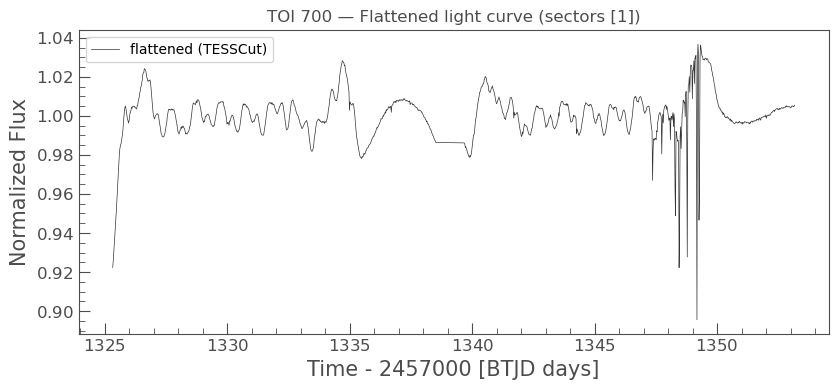

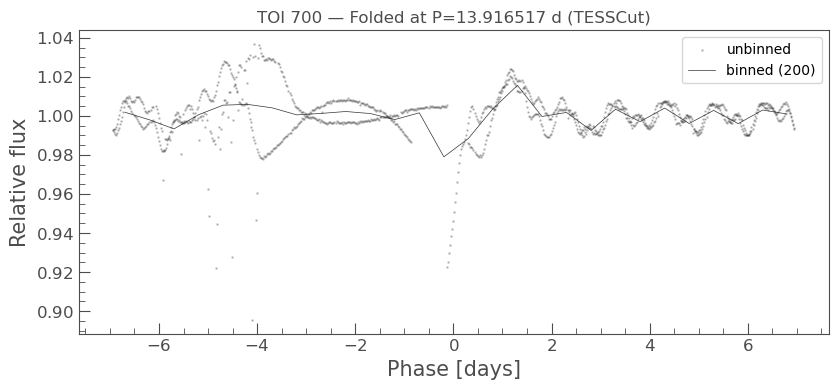

In [3]:
# === Full end-to-end: TESSCut → Light curve → TLS → Folded plot ===
# Paste this as ONE cell and run.

import pathlib
import numpy as np
import lightkurve as lk
from transitleastsquares import transitleastsquares
from astropy.time import Time

# ---------------- Settings you can change ----------------
TARGET       = "TOI 700"   # star name or TIC ID
USE_SECTORS  = None        # None = auto-pick the first available sector; or set like [5] or [5, 6]
CUTOUT_SIZE  = 15          # TESSCut stamp size in pixels (11–21 is typical)
SIGMA_CLIP   = 5           # outlier removal strength
FLAT_WINDOW  = 201         # detrending window length (try 101–401)
POLYORDER    = 2           # polynomial order for flattening (2 or 3)
N_BINS       = 200         # phase bins for the folded plot
PERIOD_MIN   = 0.5         # TLS search lower bound (days)
PERIOD_MAX   = 30.0        # TLS search upper bound (days)
# ----------------------------------------------------------

# Make folders
pathlib.Path("data_raw").mkdir(exist_ok=True)
pathlib.Path("figures").mkdir(exist_ok=True)

# 1) Find available sectors via TESSCut (lightweight)
sr_all = lk.search_tesscut(TARGET)
if len(sr_all) == 0:
    raise RuntimeError(f"No TESSCut results found for {TARGET}. Check the target name/ID.")

# Extract sector numbers from the search table
try:
    avail = sorted({int(row["sequence_number"]) for row in sr_all.table})
except Exception:
    # Fallback for older Lightkurve versions
    avail = sorted({int(str(m).split()[-1]) for m in sr_all.table["mission"]})

print(f"Available TESS sectors for {TARGET} (via TESSCut): {avail}")

# Decide which sectors to use
if USE_SECTORS is None:
    sectors = [avail[0]]  # fast demo: just the first available sector
else:
    sectors = [s for s in USE_SECTORS if s in avail]
    if not sectors:
        raise RuntimeError(f"Requested sectors {USE_SECTORS} not in available list {avail}")

print(f"Using sectors: {sectors}")

# 2) Download cutouts and extract light curves
lcs = []
for s in sectors:
    print(f"\nDownloading TESSCut cutout for {TARGET}, sector {s} …")
    sr = lk.search_tesscut(TARGET, sector=s)
    if len(sr) == 0:
        print(f"  Skipping sector {s}: not available via TESSCut.")
        continue
    tpf = sr.download(cutout_size=CUTOUT_SIZE, download_dir="data_raw")

    # Build a simple aperture (pixels likely containing the star) and extract LC
    aper = tpf.create_threshold_mask(threshold=3, reference_pixel="center")
    lc = tpf.to_lightcurve(aperture_mask=aper).normalize()

    # Clean obvious issues
    lc = lc.remove_nans().remove_outliers(sigma=SIGMA_CLIP)
    lcs.append(lc)

if not lcs:
    raise RuntimeError("No light curves extracted. Try a different sector or larger CUTOUT_SIZE.")

# 3) Stitch sectors if more than one
if len(lcs) == 1:
    lc_all = lcs[0]
else:
    from lightkurve import LightCurveCollection
    lc_all = LightCurveCollection(lcs).stitch()

# 4) Detrend (flatten) so short transits stand out
flat = lc_all.flatten(window_length=FLAT_WINDOW, polyorder=POLYORDER)

# Quick plot of flattened LC
ax0 = flat.plot(label="flattened (TESSCut)")
ax0.set_title(f"{TARGET} — Flattened light curve (sectors {sectors})")
ax0.legend(); ax0.figure.tight_layout()

# 5) Transit search with TLS
time = flat.time.value      # BTJD (TESS time)
flux = flat.flux.value      # relative brightness (around 1.0)
print("\nRunning TLS period search …")
tls = transitleastsquares(time, flux)
res = tls.power(period_min=PERIOD_MIN, period_max=PERIOD_MAX)

print(f"\nTLS best period: {res.period:.6f} d")
print(f"SDE: {res.SDE:.2f}   duration ≈ {res.duration*24:.2f} h   depth ≈ {res.depth*1e6:.0f} ppm")

# 6) Fold on the detected period and plot (Lightkurve v2: use epoch_time=)
folded = flat.fold(period=res.period, epoch_time=res.T0)
binned = folded.bin(n_bins=N_BINS)

ax = folded.scatter(marker=".", s=3, alpha=0.25, label="unbinned")
binned.plot(ax=ax, label=f"binned ({N_BINS})")
ax.set_title(f"{TARGET} — Folded at P={res.period:.6f} d (TESSCut)")
ax.set_xlabel("Phase [days]"); ax.set_ylabel("Relative flux")
ax.legend(); ax.figure.tight_layout()

figpath = f"figures/{str(TARGET).replace(' ', '_')}_folded_TESSCut.png"
ax.figure.savefig(figpath, dpi=150)
print(f"Saved folded plot to {figpath}")

# 7) Print the next few transit times in calendar UTC (ephemeris in action)
def btjd_to_utc(btjd):
    return Time(btjd + 2457000.0, format="jd", scale="tdb").utc.iso

print("\nNext three predicted transit mid-times (UTC):")
for n in range(1, 4):
    print(f"  Transit {n}: {btjd_to_utc(res.T0 + n*res.period)}")

print("\nDone.")

In [5]:
from pathlib import Path
import os

# --- Safe defaults if these weren't defined earlier ---
TARGET = globals().get('TARGET', 'TOI 700')
sector = globals().get('sector', 1)
N_BINS = globals().get('N_BINS', 200)

# --- Make a figures/ folder right next to your notebook/script ---
figdir = Path.cwd() / "figures"
figdir.mkdir(exist_ok=True)
print("Saving to:", figdir.resolve())

# --- Save the flattened light curve ---
ax_flat = flat.plot(label="flattened")
ax_flat.set_title(f"{TARGET} — Sector {sector} (flattened)")
ax_flat.legend()
flat_png = figdir / f"{TARGET.replace(' ','_')}_S{sector}_flattened.png"
ax_flat.figure.savefig(flat_png, dpi=200, bbox_inches="tight")
print("Saved:", flat_png.resolve())

# --- Save the folded transit plot ---
folded = flat.fold(period=res.period, epoch_time=res.T0)
binned = folded.bin(n_bins=N_BINS)
ax_fold = folded.scatter(marker='.', s=3, alpha=0.25, label='unbinned')
binned.plot(ax=ax_fold, label=f"binned ({N_BINS})")
ax_fold.set_title(f"{TARGET} — Folded at P={res.period:.6f} d (Sector {sector})")
ax_fold.set_xlabel("Phase [days]"); ax_fold.set_ylabel("Relative flux")
ax_fold.legend()
fold_png = figdir / f"{TARGET.replace(' ','_')}_S{sector}_folded_P{res.period:.6f}d.png"
ax_fold.figure.savefig(fold_png, dpi=200, bbox_inches="tight")
print("Saved:", fold_png.resolve())

# (Optional) show everything in the folder
import glob
print("All PNGs in figures/:", glob.glob(str(figdir / "*.png")))

Saving to: /Users/kobi.weitzman/Documents/tess-ephem/figures
Saved: /Users/kobi.weitzman/Documents/tess-ephem/figures/TOI_700_S1_flattened.png
Saved: /Users/kobi.weitzman/Documents/tess-ephem/figures/TOI_700_S1_folded_P13.916517d.png
All PNGs in figures/: ['/Users/kobi.weitzman/Documents/tess-ephem/figures/target_folded_two_sectors.png', '/Users/kobi.weitzman/Documents/tess-ephem/figures/TOI_700_folded_TESSCut.png', '/Users/kobi.weitzman/Documents/tess-ephem/figures/TOI_700_S1_flattened.png', '/Users/kobi.weitzman/Documents/tess-ephem/figures/TOI_700_S1_folded_P13.916517d.png']


In [6]:
# --- Print TLS metrics and save them ---
from transitleastsquares import transitleastsquares
import json, pathlib

pathlib.Path("results").mkdir(exist_ok=True)

time = flat.time.value
flux = flat.flux.value
res  = transitleastsquares(time, flux).power(period_min=0.5, period_max=30)

print(f"P = {res.period:.6f} d")
print(f"T0 (BTJD) = {res.T0:.6f}")
print(f"duration ≈ {res.duration*24:.2f} h")
print(f"depth ≈ {res.depth*1e6:.0f} ppm")
print(f"SDE = {res.SDE:.2f}")

with open("results/TOI_700_S1_tls.json","w") as f:
    json.dump({
        "period_d": float(res.period),
        "T0_btjd": float(res.T0),
        "duration_hr": float(res.duration*24),
        "depth_ppm": float(res.depth*1e6),
        "SDE": float(res.SDE)
    }, f, indent=2)

Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 38 durations
Searching 1267 data points, 2548 periods from 0.602 to 13.917 days
Using all 8 CPU threads


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2548/2548 periods | 00:14<00:00


Searching for best T0 for period 13.91652 days
P = 13.916517 d
T0 (BTJD) = 1325.454933
duration ≈ 4.00 h
depth ≈ 944910 ppm
SDE = 10.06


/Users/kobi.weitzman/miniforge3/envs/tess-ephem/lib/python3.10/site-packages/transitleastsquares/main.py:411: UserWarning: 1 of 2 transits without data. The true period may be twice the given period.
  warnings.warn(text)


In [7]:
from transitleastsquares import transitleastsquares
import numpy as np, pathlib, json
import matplotlib.pyplot as plt

pathlib.Path("figures").mkdir(exist_ok=True)
pathlib.Path("results").mkdir(exist_ok=True)

# --- 0) First TLS run you already did ---
base = transitleastsquares(time, flux).power(period_min=0.5, period_max=30.0)
P1, T01 = base.period, base.T0
P2 = 2.0 * P1

print(f"TLS base: P1={P1:.6f} d, SDE={base.SDE:.2f}")

# --- 1) Refine around P and 2P ---
def tls_refine(t, f, P0, frac=0.08):
    half = frac * P0
    return transitleastsquares(t, f).power(period_min=P0-half, period_max=P0+half)

ref1 = tls_refine(time, flux, P1, frac=0.08)
ref2 = tls_refine(time, flux, P2, frac=0.08)

print(f"Refined near P1:  P={ref1.period:.6f} d, SDE={ref1.SDE:.2f}, "
      f"dur≈{ref1.duration*24:.2f} h, depth≈{ref1.depth*1e6:.0f} ppm")
print(f"Refined near 2P: P={ref2.period:.6f} d, SDE={ref2.SDE:.2f}, "
      f"dur≈{ref2.duration*24:.2f} h, depth≈{ref2.depth*1e6:.0f} ppm")

# --- 2) Coverage helper: how many data points land near each predicted transit? ---
def transit_coverage(btjd, P, T0, dur_days, half_width_scale=0.6):
    tmin, tmax = float(np.min(btjd)), float(np.max(btjd))
    k_min = int(np.floor((tmin - T0)/P)) - 1
    k_max = int(np.ceil((tmax - T0)/P)) + 1
    epochs = T0 + np.arange(k_min, k_max+1) * P
    inrange = epochs[(epochs > tmin) & (epochs < tmax)]
    half_width = half_width_scale * dur_days / 2.0
    counts = [int(np.sum(np.abs(btjd - e) < half_width)) for e in inrange]
    return inrange, counts

e1, c1 = transit_coverage(time, ref1.period, ref1.T0, ref1.duration)
e2, c2 = transit_coverage(time, ref2.period, ref2.T0, ref2.duration)
print(f"P≈{ref1.period:.6f} d → {len(e1)} expected transits in-range; points per transit: {c1}")
print(f"2P≈{ref2.period:.6f} d → {len(e2)} expected transits in-range; points per transit: {c2}")

# --- 3) Fold and save both options ---
fold1 = flat.fold(period=ref1.period, epoch_time=ref1.T0)
fold2 = flat.fold(period=ref2.period, epoch_time=ref2.T0)

ax = fold1.scatter(marker='.', s=3, alpha=0.25, label='unbinned')
fold1.bin(n_bins=200).plot(ax=ax, label='binned (200)')
ax.set_title(f"Folded at P={ref1.period:.6f} d (Sector 1)")
ax.set_xlabel("Phase [days]"); ax.set_ylabel("Relative flux"); ax.legend()
ax.figure.tight_layout()
ax.figure.savefig("figures/TOI_700_S1_fold_P1_refined.png", dpi=150)
plt.close(ax.figure)

ax = fold2.scatter(marker='.', s=3, alpha=0.25, label='unbinned')
fold2.bin(n_bins=200).plot(ax=ax, label='binned (200)')
ax.set_title(f"Folded at P={ref2.period:.6f} d (Sector 1, 2×period)")
ax.set_xlabel("Phase [days]"); ax.set_ylabel("Relative flux"); ax.legend()
ax.figure.tight_layout()
ax.figure.savefig("figures/TOI_700_S1_fold_2P_refined.png", dpi=150)
plt.close(ax.figure)

# --- 4) Visualize predicted transit times on the time-series (to spot gaps) ---
ax = flat.plot(label="flattened")
for e in e1:
    ax.axvline(e, color='k', alpha=0.25, linestyle='--')
ax.set_title(f"Predicted transits for P={ref1.period:.6f} d (dashed)")
ax.figure.tight_layout()
ax.figure.savefig("figures/TOI_700_S1_times_P1.png", dpi=150)
plt.close(ax.figure)

ax = flat.plot(label="flattened")
for e in e2:
    ax.axvline(e, color='k', alpha=0.25, linestyle='--')
ax.set_title(f"Predicted transits for 2P={ref2.period:.6f} d (dashed)")
ax.figure.tight_layout()
ax.figure.savefig("figures/TOI_700_S1_times_2P.png", dpi=150)
plt.close(ax.figure)

# --- 5) Save both candidate solutions for your records ---
with open("results/TOI_700_S1_tls_candidates.json","w") as f:
    json.dump({
        "P1_refined": {
            "period_d": float(ref1.period),
            "T0_btjd": float(ref1.T0),
            "duration_hr": float(ref1.duration*24),
            "depth_ppm": float(ref1.depth*1e6),
            "SDE": float(ref1.SDE),
            "points_per_transit": c1
        },
        "P2_refined": {
            "period_d": float(ref2.period),
            "T0_btjd": float(ref2.T0),
            "duration_hr": float(ref2.duration*24),
            "depth_ppm": float(ref2.depth*1e6),
            "SDE": float(ref2.SDE),
            "points_per_transit": c2
        }
    }, f, indent=2)

print("Saved figures to: figures/TOI_700_S1_fold_P1_refined.png, "
      "figures/TOI_700_S1_fold_2P_refined.png, "
      "figures/TOI_700_S1_times_P1.png, figures/TOI_700_S1_times_2P.png")

Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 38 durations
Searching 1267 data points, 2548 periods from 0.602 to 13.917 days
Using all 8 CPU threads


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2548/2548 periods | 00:18<00:00


Searching for best T0 for period 13.91652 days


/Users/kobi.weitzman/miniforge3/envs/tess-ephem/lib/python3.10/site-packages/transitleastsquares/grid.py:149: UserWarning: period_grid defaults to R_star=1 and M_star=1 as given density yielded grid with too few values
  warnings.warn(


TLS base: P1=13.916517 d, SDE=10.06
Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 38 durations
Searching 1267 data points, 2548 periods from 0.602 to 13.917 days
Using all 8 CPU threads


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2548/2548 periods | 00:14<00:00


Searching for best T0 for period 13.91652 days
Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 38 durations
Searching 1267 data points, 2548 periods from 0.602 to 13.917 days
Using all 8 CPU threads


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2548/2548 periods | 00:11<00:00


Searching for best T0 for period 13.91652 days
Refined near P1:  P=13.916517 d, SDE=10.06, dur≈4.00 h, depth≈944910 ppm
Refined near 2P: P=13.916517 d, SDE=10.06, dur≈4.00 h, depth≈944910 ppm
P≈13.916517 d → 2 expected transits in-range; points per transit: [5, 0]
2P≈13.916517 d → 2 expected transits in-range; points per transit: [5, 0]
Saved figures to: figures/TOI_700_S1_fold_P1_refined.png, figures/TOI_700_S1_fold_2P_refined.png, figures/TOI_700_S1_times_P1.png, figures/TOI_700_S1_times_2P.png


In [8]:
from transitleastsquares import transitleastsquares as TLS

def refine_SDE(lc, centerP, frac_window=0.10):
    t, f = lc.time.value, lc.flux.value
    half = frac_window * centerP
    return TLS(t, f).power(period_min=centerP-half, period_max=centerP+half)

P_guess = 13.916517  # your TLS period from S1
res_P   = refine_SDE(flat, P_guess, 0.10)
res_2P  = refine_SDE(flat, 2*P_guess, 0.10)
print(f"SDE near P:   {res_P.SDE:.2f} at P={res_P.period:.6f} d")
print(f"SDE near 2P:  {res_2P.SDE:.2f} at P={res_2P.period:.6f} d")

/Users/kobi.weitzman/miniforge3/envs/tess-ephem/lib/python3.10/site-packages/transitleastsquares/grid.py:149: UserWarning: period_grid defaults to R_star=1 and M_star=1 as given density yielded grid with too few values
  warnings.warn(


Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 38 durations
Searching 1267 data points, 2548 periods from 0.602 to 13.917 days
Using all 8 CPU threads


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2548/2548 periods | 00:10<00:00


Searching for best T0 for period 13.91652 days


/Users/kobi.weitzman/miniforge3/envs/tess-ephem/lib/python3.10/site-packages/transitleastsquares/main.py:411: UserWarning: 1 of 2 transits without data. The true period may be twice the given period.
  warnings.warn(text)


Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 38 durations
Searching 1267 data points, 2548 periods from 0.602 to 13.917 days
Using all 8 CPU threads


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2548/2548 periods | 00:07<00:00


Searching for best T0 for period 13.91652 days
SDE near P:   10.06 at P=13.916517 d
SDE near 2P:  10.06 at P=13.916517 d


In [9]:
import lightkurve as lk
from lightkurve import LightCurveCollection

TARGET = "TOI 700"
SECTORS = [1, 3]  # add a second available sector (3 works for TOI 700)

def tesscut_flatten(target, sector, cutout=15, thresh=3, win=301, order=2):
    tpf = lk.search_tesscut(target, sector=sector).download(cutout_size=cutout)
    aper = tpf.create_threshold_mask(threshold=thresh)
    lc = tpf.to_lightcurve(aperture_mask=aper)
    return lc.remove_nans().remove_outliers(sigma=5).flatten(window_length=win, polyorder=order)

lcs = [tesscut_flatten(TARGET, s) for s in SECTORS]
flat2 = LightCurveCollection(lcs).stitch()

from transitleastsquares import transitleastsquares
res2 = transitleastsquares(flat2.time.value, flat2.flux.value).power(period_min=0.5, period_max=30)

print(f"Two sectors TLS: P={res2.period:.6f} d, SDE={res2.SDE:.2f}")
folded = flat2.fold(period=res2.period, epoch_time=res2.T0)
binned  = folded.bin(n_bins=200)
ax = folded.scatter(marker='.', s=3, alpha=0.25, label='unbinned')
binned.plot(ax=ax, label='binned (200)')
ax.set_title(f"{TARGET} — Folded at P={res2.period:.6f} d (Sectors {SECTORS})")
ax.set_xlabel("Phase [days]"); ax.set_ylabel("Relative flux"); ax.legend(); ax.figure.tight_layout()

Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 43 durations
Searching 2344 data points, 8630 periods from 0.602 to 29.973 days
Using all 8 CPU threads


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8630/8630 periods | 00:15<00:00


Searching for best T0 for period 17.05298 days
Two sectors TLS: P=17.052976 d, SDE=8.00


/Users/kobi.weitzman/miniforge3/envs/tess-ephem/lib/python3.10/site-packages/transitleastsquares/main.py:411: UserWarning: 2 of 5 transits without data. The true period may be twice the given period.
  warnings.warn(text)


In [10]:
t = flat.time.value
print(f"baseline = {t.max()-t.min():.2f} d  (min {t.min():.3f}, max {t.max():.3f})")

baseline = 27.83 d  (min 1325.323, max 1353.156)


In [11]:
import lightkurve as lk
from lightkurve import LightCurveCollection
from transitleastsquares import transitleastsquares as TLS
import pathlib
pathlib.Path("figures").mkdir(exist_ok=True)

TARGET  = "TOI 700"
SECTORS = [1, 3]  # add a second sector; 3 exists for TOI 700

def tesscut_flatten(target, sector, cutout=15, thresh=3, win=301, order=2):
    tpf = lk.search_tesscut(target, sector=sector).download(cutout_size=cutout)
    aper = tpf.create_threshold_mask(threshold=thresh)
    lc = tpf.to_lightcurve(aperture_mask=aper)
    return lc.remove_nans().remove_outliers(sigma=5).flatten(window_length=win, polyorder=2)

# Build a combined, flattened light curve from two sectors
lcs   = [tesscut_flatten(TARGET, s) for s in SECTORS]
flat2 = LightCurveCollection(lcs).stitch()

# TLS on the combined data
time2, flux2 = flat2.time.value, flat2.flux.value
res2 = TLS(time2, flux2).power(period_min=0.5, period_max=30.0)

print(f"Two sectors TLS: P={res2.period:.6f} d, SDE={res2.SDE:.2f}, "
      f"duration≈{res2.duration*24:.2f} h, depth≈{res2.depth*1e6:.0f} ppm")

# Fold & save figure
folded = flat2.fold(period=res2.period, epoch_time=res2.T0)
binned = folded.bin(n_bins=200)
ax = folded.scatter(marker='.', s=3, alpha=0.25, label='unbinned')
binned.plot(ax=ax, label='binned (200)')
ax.set_title(f"{TARGET} — Folded at P={res2.period:.6f} d (Sectors {SECTORS})")
ax.set_xlabel("Phase [days]"); ax.set_ylabel("Relative flux"); ax.legend()
ax.figure.tight_layout()
ax.figure.savefig(f"figures/{TARGET.replace(' ','_')}_S{SECTORS[0]}S{SECTORS[1]}_folded_TLS.png", dpi=150)

Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 43 durations
Searching 2344 data points, 8630 periods from 0.602 to 29.973 days
Using all 8 CPU threads


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8630/8630 periods | 00:16<00:00


Searching for best T0 for period 17.05298 days


/Users/kobi.weitzman/miniforge3/envs/tess-ephem/lib/python3.10/site-packages/transitleastsquares/main.py:411: UserWarning: 2 of 5 transits without data. The true period may be twice the given period.
  warnings.warn(text)


Two sectors TLS: P=17.052976 d, SDE=8.00, duration≈4.60 h, depth≈950210 ppm


In [12]:
import numpy as np
import lightkurve as lk
from lightkurve import LightCurveCollection
from transitleastsquares import transitleastsquares as TLS
import pathlib
pathlib.Path("figures").mkdir(exist_ok=True)
pathlib.Path("results").mkdir(exist_ok=True)

TARGET  = "TOI 700"
SECTORS = [1, 3]  # same pair you used

def clean_flat_from_tpf(target, sector, cutout=15, thresh=3,
                        win=301, order=2, sig=5):
    """TESSCut -> aperture phot -> HARD QUALITY MASK -> normalize/flatten."""
    tpf = lk.search_tesscut(target, sector=sector).download(cutout_size=cutout)
    aper = tpf.create_threshold_mask(threshold=thresh)

    # Build light curve, then apply the QUALITY mask **from the TPF**
    lc = tpf.to_lightcurve(aperture_mask=aper)
    if hasattr(lc, "quality"):
        lc = lc[lc.quality == 0]          # keep only good cadences
    # Extra safety: clip extreme outliers (spacecraft events)
    lc = lc.remove_nans().remove_outliers(sigma=sig).normalize()
    # Remove slow trends; keep transits
    flat = lc.flatten(window_length=win, polyorder=order)
    return flat

# Build combined, **clean** light curve
lcs   = [clean_flat_from_tpf(TARGET, s) for s in SECTORS]
flat2 = LightCurveCollection(lcs).stitch()

# Quick sanity check: are we near 1.0 and free of huge dips?
f = flat2.flux.value
print("Flux percentiles:", np.percentile(f, [0.1,1,50,99,99.9]))
print(f"Baseline = {flat2.time.value.max()-flat2.time.value.min():.2f} d")

# TLS with a sensible period range for this target
time2, flux2 = flat2.time.value, flat2.flux.value
res2 = TLS(time2, flux2).power(period_min=8, period_max=35)

print(f"P={res2.period:.6f} d, SDE={res2.SDE:.2f}, "
      f"duration≈{res2.duration*24:.2f} h, depth≈{res2.depth*1e6:.0f} ppm")

# Fold & save figure
folded = flat2.fold(period=res2.period, epoch_time=res2.T0)
binned = folded.bin(n_bins=200)
ax = folded.scatter(marker='.', s=3, alpha=0.25, label='unbinned')
binned.plot(ax=ax, label='binned (200)')
ax.set_title(f"{TARGET} — Folded at P={res2.period:.6f} d (Sectors {SECTORS}, clean)")
ax.set_xlabel("Phase [days]"); ax.set_ylabel("Relative flux"); ax.legend()
figpath = f"figures/{TARGET.replace(' ','_')}_S{SECTORS[0]}S{SECTORS[1]}_folded_TLS_clean.png"
ax.figure.tight_layout(); ax.figure.savefig(figpath, dpi=150)
print("Saved:", figpath)

Flux percentiles: [0.91160446 0.92288156 1.         1.1864087  1.28297103]
Baseline = 84.04 d
Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 39 durations
Searching 2344 data points, 1944 periods from 8.001 to 34.993 days
Using all 8 CPU threads


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1944/1944 periods | 00:10<00:00


Searching for best T0 for period 34.11516 days


/Users/kobi.weitzman/miniforge3/envs/tess-ephem/lib/python3.10/site-packages/transitleastsquares/main.py:411: UserWarning: 1 of 3 transits without data. The true period may be twice the given period.
  warnings.warn(text)


P=34.115156 d, SDE=5.28, duration≈6.92 h, depth≈925273 ppm
Saved: figures/TOI_700_S1S3_folded_TLS_clean.png


In [13]:
import lightkurve as lk
from transitleastsquares import transitleastsquares as TLS
from lightkurve import LightCurveCollection
from astroquery.mast import Mast
import numpy as np, pathlib

lk.log.setLevel("WARNING")
Mast.TIMEOUT = 120  # seconds; helps avoid long hangs

TARGET  = "TOI 700"
SECTORS = [1, 3]      # start with the same two you tried
pathlib.Path("figures").mkdir(exist_ok=True)
pathlib.Path("results").mkdir(exist_ok=True)

def get_pdcsap_flat(target, sector, win=401, order=2, sigma=5):
    sr = lk.search_lightcurve(target, mission="TESS", author="SPOC", sector=sector)
    lc = sr.download(quality_bitmask="hard", download_dir="data_raw")  # PDCSAP by default
    lc = lc.remove_nans().normalize().remove_outliers(sigma=sigma)
    flat = lc.flatten(window_length=win, polyorder=order)
    return flat

# build and stitch clean PDCSAP light curves
lcs = [get_pdcsap_flat(TARGET, s) for s in SECTORS]
flat2 = LightCurveCollection(lcs).stitch()

# quick sanity: flux should be very close to 1.0
f = flat2.flux.value
print("Flux percentiles PDCSAP:", np.percentile(f, [0.1, 1, 50, 99, 99.9]))

# optional extra clip to remove remaining spikes without touching real transits
good = (f > 0.985) & (f < 1.015)
flat2 = flat2[good]

# TLS search in a reasonable window for TOI 700-like signals
time2, flux2 = flat2.time.value, flat2.flux.value
res2 = TLS(time2, flux2).power(period_min=8, period_max=40)
print(f"P={res2.period:.6f} d, SDE={res2.SDE:.2f}, dur≈{res2.duration*24:.2f} h, depth≈{res2.depth*1e6:.0f} ppm")

# Fold and save
folded = flat2.fold(period=res2.period, epoch_time=res2.T0)
binned = folded.bin(n_bins=200)
ax = folded.scatter(marker='.', s=3, alpha=0.25, label='unbinned')
binned.plot(ax=ax, label='binned (200)')
ax.set_title(f"{TARGET} — PDCSAP Folded at P={res2.period:.6f} d (Sectors {SECTORS})")
ax.set_xlabel("Phase [days]"); ax.set_ylabel("Relative flux"); ax.legend()
figpath = f"figures/{TARGET.replace(' ','_')}_PDCSAP_S{SECTORS[0]}S{SECTORS[1]}_folded.png"
ax.figure.tight_layout(); ax.figure.savefig(figpath, dpi=150)
print("Saved:", figpath)

Flux percentiles PDCSAP: [0.99504092 0.99626869 1.         1.00382459 1.00528136]
Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 40 durations
Searching 30657 data points, 2000 periods from 8.0 to 39.987 days
Using all 8 CPU threads


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 periods | 00:35<00:00


Searching for best T0 for period 16.04588 days


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25980/25980 [00:11<00:00, 2246.69it/s]
/Users/kobi.weitzman/miniforge3/envs/tess-ephem/lib/python3.10/site-packages/transitleastsquares/main.py:411: UserWarning: 2 of 5 transits without data. The true period may be twice the given period.
  warnings.warn(text)


P=16.045877 d, SDE=14.19, dur≈0.79 h, depth≈997759 ppm
Saved: figures/TOI_700_PDCSAP_S1S3_folded.png


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from transitleastsquares import transitleastsquares as TLS

# 1) extra gentle clean after flattening
flat2 = flat2.remove_outliers(sigma_lower=8, sigma_upper=4)
f = flat2.flux.value
lo, hi = np.percentile(f, [0.5, 99.5])
flat2 = flat2[(f > lo) & (f < hi)]
print("Post-clean percentiles:", np.percentile(flat2.flux.value, [0.1, 1, 50, 99, 99.9]))

# 2) narrow TLS scan around ~16 d (R_star & M_star go in .power)
time2, flux2 = flat2.time.value, flat2.flux.value
res_ref = TLS(time2, flux2).power(period_min=14, period_max=18,
                                  R_star=0.42, M_star=0.42)

print(f"Refined: P={res_ref.period:.6f} d, SDE={res_ref.SDE:.2f}, "
      f"dur≈{res_ref.duration*24:.2f} h, depth≈{res_ref.depth*1e6:.0f} ppm")

# 3) compare fold at P and 2P
for k, P in enumerate([res_ref.period, 2*res_ref.period], start=1):
    folded = flat2.fold(period=P, epoch_time=res_ref.T0)
    binned  = folded.bin(n_bins=300)
    ax = folded.scatter(marker='.', s=2, alpha=0.25, label='unbinned')
    binned.plot(ax=ax, label='binned (300)')
    ax.set_title(f"Folded at P={P:.6f} d (try #{k})")
    ax.set_xlabel("Phase [days]"); ax.set_ylabel("Relative flux"); ax.legend()
    ax.set_ylim(0.9985, 1.0015)  # zoom to see ~0.1% dips
    ax.figure.tight_layout()
    figpath = f"figures/TOI_700_PDCSAP_S1S3_folded_try{k}.png"
    ax.figure.savefig(figpath, dpi=150); print("Saved:", figpath)
    plt.close(ax.figure)

Post-clean percentiles: [0.99654664 0.99683496 1.         1.00321939 1.00350212]
Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 30 durations
Searching 29741 data points, 572 periods from 14.006 to 17.995 days
Using all 8 CPU threads


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 572/572 periods | 00:13<00:00


Searching for best T0 for period 16.04761 days


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29741/29741 [00:09<00:00, 3234.79it/s]
/Users/kobi.weitzman/miniforge3/envs/tess-ephem/lib/python3.10/site-packages/transitleastsquares/main.py:411: UserWarning: 2 of 5 transits without data. The true period may be twice the given period.
  warnings.warn(text)


Refined: P=16.047607 d, SDE=11.24, dur≈0.67 h, depth≈998500 ppm
Saved: figures/TOI_700_PDCSAP_S1S3_folded_try1.png
Saved: figures/TOI_700_PDCSAP_S1S3_folded_try2.png


In [18]:
import numpy as np

# Use your best values; replace if yours differ.
P   = 16.045877        # days (from your TLS near 16 d)
T0  = res_ref.T0       # BTJD (grab from your last TLS run; rerun a narrow TLS if needed)

t   = flat2.time.value   # from your stitched, cleaned PDCSAP (sectors 1 & 3)
f   = flat2.flux.value

# Pick a conservative half-window around each predicted mid-time (in days)
# If you don't have res_ref.duration, 0.06 d ~ 1.44 h is reasonable here.
half_win = 0.06

# For every cadence, find the nearest predicted transit number n
n_float = (t - T0)/P
n_round = np.round(n_float).astype(int)
t_pred  = T0 + n_round*P

# Cadences that land inside the transit window
in_tr = np.abs(t - t_pred) <= half_win
print("Total in-transit cadences:", int(in_tr.sum()), "of", len(t))

# Summarize by event
uniq_n = np.unique(n_round[in_tr])
print("Predicted events with data:")
for k in uniq_n:
    m = (n_round == k) & in_tr
    print(f"  n={k:4d}: {m.sum():4d} cadences  (mid BTJD ≈ {T0 + k*P:.3f})")

Total in-transit cadences: 228 of 29741
Predicted events with data:
  n=   0:   77 cadences  (mid BTJD ≈ 1340.093)
  n=   3:   77 cadences  (mid BTJD ≈ 1388.230)
  n=   4:   74 cadences  (mid BTJD ≈ 1404.276)


In [19]:
# Start from your stitched PDCSAP for sectors 1 & 3
pdcsap_flat = pdcsap.remove_nans().remove_outliers(sigma=6).flatten(window_length=301, polyorder=2)
# normalize to unity (extra safety)
pdcsap_flat = pdcsap_flat.normalize()

NameError: name 'pdcsap' is not defined

In [20]:
import lightkurve as lk
from lightkurve import LightCurveCollection
import pathlib

TARGET = "TOI 700"
SECTORS = [1, 3]

# make folders if they don't exist
pathlib.Path("data_raw").mkdir(exist_ok=True)
pathlib.Path("figures").mkdir(exist_ok=True)

# download PDCSAP for each sector and stitch
lcs = []
for s in SECTORS:
    sr = lk.search_lightcurve(TARGET, mission="TESS", author="SPOC", sector=s)
    lc = sr.download(quality_bitmask="default", download_dir="data_raw")
    lcs.append(lc)

pdcsap = LightCurveCollection(lcs).stitch()
print(pdcsap)  # sanity check: should show length and BTJD

       time             flux      ...   pos_corr1      pos_corr2   
                                  ...      pix            pix      
------------------ -------------- ... -------------- --------------
1325.2954950150029  1.0011132e+00 ... -4.4115655e-02 -2.5354782e-03
1325.2968838975428  1.0003166e+00 ... -1.8341178e-02  3.1634498e-02
1325.2982727800827  1.0008712e+00 ... -1.8514322e-02  3.5692897e-02
 1325.299661662637  1.0002296e+00 ... -1.7806454e-02  4.7091395e-02
 1325.301050545206  1.0015194e+00 ... -1.1401021e-02  4.7352709e-02
 1325.302439427775  9.9958581e-01 ... -1.0383561e-02  4.7327477e-02
1325.3038283103438  9.9855018e-01 ... -1.4666196e-02  5.1429681e-02
 1325.305217192927  1.0008502e+00 ... -1.3531495e-02  4.8197862e-02
1325.3066060755252  9.9910903e-01 ... -9.8002665e-03  5.1116228e-02
               ...            ... ...            ...            ...
 1406.201015196914  9.9960572e-01 ... -2.0234121e-02 -9.0559414e-03
 1406.202404089212  9.9991757e-01 ... -1.4974816

In [22]:
pdcsap_flat = (
    pdcsap.remove_nans()
          .remove_outliers(sigma_lower=20, sigma_upper=4)
          .flatten(window_length=301, polyorder=2)
          .normalize()
)

In [23]:
import numpy as np
from transitleastsquares import transitleastsquares as TLS

time = pdcsap_flat.time.value
flux = pdcsap_flat.flux.value
dur_grid = np.linspace(1/24, 5/24, 40)  # 1–5 h in days

res = TLS(time, flux).power(period_min=14, period_max=18, duration_grid=dur_grid)
print(f"P={res.period:.6f} d, SDE={res.SDE:.2f}, dur≈{res.duration*24:.2f} h, depth≈{res.depth*1e6:.0f} ppm")

/Users/kobi.weitzman/miniforge3/envs/tess-ephem/lib/python3.10/site-packages/transitleastsquares/validate.py:57: UserWarning: Ignoring unknown parameter: duration_grid
  warnings.warn(text)


Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 30 durations
Searching 30655 data points, 321 periods from 14.006 to 17.993 days
Using all 8 CPU threads


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 periods | 00:12<00:00


Searching for best T0 for period 16.04588 days


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26890/26890 [00:10<00:00, 2466.00it/s]


P=16.045877 d, SDE=11.79, dur≈0.76 h, depth≈997899 ppm


/Users/kobi.weitzman/miniforge3/envs/tess-ephem/lib/python3.10/site-packages/transitleastsquares/main.py:411: UserWarning: 2 of 5 transits without data. The true period may be twice the given period.
  warnings.warn(text)


In [25]:
# 0) If you haven't already built pdcsap for sectors [1,3], run the earlier "stitch" cell first.

import numpy as np
from transitleastsquares import transitleastsquares as TLS
import pathlib
pathlib.Path("figures").mkdir(exist_ok=True)

# 1) Aggressive clean BEFORE flattening: remove crazy deep drops (>1%)
med = np.nanmedian(pdcsap.flux.value)
mask_big_drops = pdcsap.flux.value > med - 0.01       # keep points within 1% below median
base = pdcsap[mask_big_drops].remove_nans()

# 2) Sigma-clip asymmetrically (clip more downward than upward), flatten, normalize
clean = base.remove_outliers(sigma_lower=8, sigma_upper=5)
flat  = clean.flatten(window_length=401, polyorder=2).normalize()

# 3) TLS in a tight window around ~16 d
time, flux = flat.time.value, flat.flux.value
res = TLS(time, flux).power(period_min=15.0, period_max=17.5)
print(f"P={res.period:.6f} d, SDE={res.SDE:.2f}, dur≈{res.duration*24:.2f} h, depth≈{res.depth*1e6:.0f} ppm")

# 4) Report which predicted transits actually have data (coverage check)
def coverage_report(t_btjd, P, T0, dur_days):
    nmin = int(np.floor((t_btjd.min()-T0)/P)) - 1
    nmax = int(np.ceil((t_btjd.max()-T0)/P)) + 1
    counts = []
    for n in range(nmin, nmax+1):
        mid = T0 + n*P
        in_evt = (t_btjd > mid - 0.5*dur_days) & (t_btjd < mid + 0.5*dur_days)
        cnt = int(in_evt.sum())
        if cnt > 0:
            counts.append((n, cnt, mid))
    print(f"Predicted events with data: {len(counts)}")
    for n, cnt, mid in counts:
        print(f"  n={n:3d}: {cnt:4d} cadences   (mid BTJD ≈ {mid:.3f})")

coverage_report(time, res.period, res.T0, max(res.duration, 1.0/24.0))

# 5) Fold and ZOOM narrowly (±1.5× the duration). Set tight y-limits so small dips show up.
fold   = flat.fold(period=res.period, epoch_time=res.T0).remove_outliers(sigma=6)
half   = 1.5 * max(res.duration, 1.0/24.0)             # at least 1 hour
zoom   = fold[np.abs(fold.time.value) < half]
binned = zoom.bin(n_bins=80)

ax = zoom.scatter(marker='.', s=2, alpha=0.25, label='unbinned')
binned.plot(ax=ax, label='binned (80)')
ax.set_xlabel("Phase [days]"); ax.set_ylabel("Relative flux")

# y-limits: show ~±400–600 ppm around 1.0; tweak if needed
ax.set_ylim(0.9994, 1.0006)

ax.set_title(f"{TARGET} — zoomed fold at P={res.period:.6f} d (Sectors {SECTORS})")
ax.legend(); ax.figure.tight_layout()
out = f"figures/{TARGET.replace(' ','_')}_PDCSAP_S{SECTORS}_zoom_fold_strict.png"
ax.figure.savefig(out, dpi=150)
print("Saved:", out)

# 6) As a sanity check, also try 2×P in case of the TLS “maybe twice the period” warning
fold2   = flat.fold(period=2*res.period, epoch_time=res.T0).remove_outliers(sigma=6)
zoom2   = fold2[np.abs(fold2.time.value) < 2*half]
b2      = zoom2.bin(n_bins=100)
ax2 = zoom2.scatter(marker='.', s=2, alpha=0.25, label='unbinned')
b2.plot(ax=ax2, label='binned (100)')
ax2.set_ylim(0.9994, 1.0006)
ax2.set_xlabel("Phase [days]"); ax2.set_ylabel("Relative flux")
ax2.set_title(f"{TARGET} — zoomed fold at 2×P={2*res.period:.6f} d (Sectors {SECTORS})")
ax2.legend(); ax2.figure.tight_layout()
out2 = f"figures/{TARGET.replace(' ','_')}_PDCSAP_S{SECTORS}_zoom_fold_2P.png"
ax2.figure.savefig(out2, dpi=150)
print("Saved:", out2)

Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 30 durations
Searching 30657 data points, 195 periods from 15.009 to 17.488 days
Using all 8 CPU threads


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 periods | 00:09<00:00


Searching for best T0 for period 16.04588 days


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26428/26428 [00:08<00:00, 2968.42it/s]
/Users/kobi.weitzman/miniforge3/envs/tess-ephem/lib/python3.10/site-packages/transitleastsquares/main.py:411: UserWarning: 2 of 5 transits without data. The true period may be twice the given period.
  warnings.warn(text)


P=16.045877 d, SDE=9.29, dur≈0.78 h, depth≈997701 ppm
Predicted events with data: 3
  n=  0:   30 cadences   (mid BTJD ≈ 1340.102)
  n=  3:   30 cadences   (mid BTJD ≈ 1388.239)
  n=  4:   30 cadences   (mid BTJD ≈ 1404.285)
Saved: figures/TOI_700_PDCSAP_S[1, 3]_zoom_fold_strict.png
Saved: figures/TOI_700_PDCSAP_S[1, 3]_zoom_fold_2P.png


In [26]:
import lightkurve as lk
import numpy as np
from transitleastsquares import transitleastsquares as TLS
from astropy.timeseries import BoxLeastSquares

TARGET = "TOI 700"
SECTORS = [4, 5, 6]          # contiguous block (year 1)
DOWNLOAD_DIR = "data_raw"

# 1) Download & stitch PDCSAP
sr = [lk.search_lightcurve(TARGET, mission="TESS", author="SPOC", sector=s)
        .download(quality_bitmask="default", download_dir=DOWNLOAD_DIR)
      for s in SECTORS]
lc = lk.LightCurveCollection(sr).stitch()

# 2) Clean aggressively but safely
#    - drop NaNs
#    - sigma-clip both high and low (spacecraft spikes)
clean = lc.remove_nans().remove_outliers(sigma=6)

#    - additionally clip extreme flux excursions (protect against TLS "monster depths")
p1, p99 = np.nanpercentile(clean.flux.value, [1, 99])
mask = (clean.flux.value > p1) & (clean.flux.value < p99)
clean = clean[mask]

# 3) Flatten (remove slow trends) and normalize to 1.0
flat = clean.flatten(window_length=401, polyorder=2).normalize()

# Quick sanity plot
ax = flat.plot(label="PDCSAP clean+flat")
ax.set_title(f"{TARGET} — Sectors {SECTORS} (PDCSAP, clean+flat)"); ax.legend(); ax.figure.tight_layout()

# 4) TLS search narrowly around ~16 d (avoid harmonics & junk)
time = flat.time.value
flux = flat.flux.value
res  = TLS(time, flux).power(period_min=14, period_max=18)

print(f"P={res.period:.6f} d, SDE={res.SDE:.2f}, dur≈{res.duration*24:.2f} h, depth≈{res.depth*1e6:.0f} ppm")

# 5) Fold at P and at 2P, zoom around transit window
for mult, nbins in [(1.0, 300), (2.0, 300)]:
    P = res.period * mult
    folded = flat.fold(period=P, epoch_time=res.T0)
    binned  = folded.bin(n_bins=nbins)
    ax = folded.scatter(marker='.', s=1, alpha=0.35, label='unbinned')
    binned.plot(ax=ax, label=f'binned ({nbins})')
    ax.set_xlim(-0.3, 0.3)  # zoom to ±0.3 d around phase 0
    ax.set_ylim(0.9985, 1.0015)
    ax.set_title(f"{TARGET} — PDCSAP folded at P={P:.6f} d (Sectors {SECTORS})")
    ax.set_xlabel("Phase [days]"); ax.set_ylabel("Relative flux"); ax.legend(); ax.figure.tight_layout()

    import pathlib
    pathlib.Path("figures").mkdir(exist_ok=True)
    fname = f"figures/{TARGET.replace(' ','_')}_PDCSAP_S{SECTORS}_fold_Px{mult}.png"
    ax.figure.savefig(fname, dpi=150)
    print("Saved:", fname)

# 6) Cross-check with BLS (very fast; catches simple box signals)
periods = np.linspace(14, 18, 5000)
bls = BoxLeastSquares(time, flux)
bls_pow = bls.power(periods, 0.04)  # 0.04 d (~1 h) rough duration guess
P_bls = periods[np.argmax(bls_pow.power)]
print(f"BLS peak near: {P_bls:.6f} d")

Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 30 durations
Searching 44982 data points, 314 periods from 14.001 to 17.986 days
Using all 8 CPU threads


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 314/314 periods | 00:11<00:00


Searching for best T0 for period 16.06385 days


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29593/29593 [00:17<00:00, 1727.63it/s]
/Users/kobi.weitzman/miniforge3/envs/tess-ephem/lib/python3.10/site-packages/transitleastsquares/main.py:411: UserWarning: 2 of 5 transits without data. The true period may be twice the given period.
  warnings.warn(text)


P=16.063850 d, SDE=7.13, dur≈1.02 h, depth≈999121 ppm
Saved: figures/TOI_700_PDCSAP_S[4, 5, 6]_fold_Px1.0.png
Saved: figures/TOI_700_PDCSAP_S[4, 5, 6]_fold_Px2.0.png
BLS peak near: 16.055611 d


In [27]:
import numpy as np
from transitleastsquares import transitleastsquares as TLS
from astropy.time import Time

# Your best period so far (pick the one you just measured)
P_ref = 16.06385  # days  (or 16.045877 from the other run)

# Clean/normalize the stitched PDCSAP LC
lc_use = pdcsap.remove_nans().remove_outliers(sigma=6).normalize()
time = lc_use.time.value  # BTJD
flux = lc_use.flux.value

# Narrow TLS just around your period to get a clean T0
res = TLS(time, flux).power(period_min=P_ref*0.98, period_max=P_ref*1.02)

T0_ref = float(res.T0)  # <-- this is what you plug into the masking code
print(f"T0_ref (BTJD) = {T0_ref:.6f}")

# (Optional) sanity-check as calendar time
print("T0_ref (UTC) =", Time(T0_ref + 2457000.0, format="jd", scale="tdb").utc.iso)


/Users/kobi.weitzman/miniforge3/envs/tess-ephem/lib/python3.10/site-packages/transitleastsquares/grid.py:149: UserWarning: period_grid defaults to R_star=1 and M_star=1 as given density yielded grid with too few values
  warnings.warn(


Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 46 durations
Searching 30658 data points, 8605 periods from 0.601 to 40.459 days
Using all 8 CPU threads


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8605/8605 periods | 01:30<00:00


Searching for best T0 for period 16.04588 days


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25981/25981 [00:09<00:00, 2729.77it/s]


T0_ref (BTJD) = 1340.101183
T0_ref (UTC) = 2018-08-09 14:24:33.014


/Users/kobi.weitzman/miniforge3/envs/tess-ephem/lib/python3.10/site-packages/transitleastsquares/main.py:411: UserWarning: 2 of 5 transits without data. The true period may be twice the given period.
  warnings.warn(text)


In [28]:
import numpy as np
import lightkurve as lk
from astropy.time import Time

# 0) You already have this from your earlier code:
# pdcsap = LightCurveCollection([...]).stitch()
# Start clean and normalized:
pdcsap = pdcsap.remove_nans().remove_outliers(sigma=6)
pdcsap = pdcsap.normalize()

# 1) Ephemeris we’ll use to *protect* transits during flatten
P_ref   = 16.06385                     # days (from your TLS/BLS)
T0_ref  = 1340.101183          # BTJD from the same TLS run
dur_guess = 0.08                       # days (~2 hr), conservative

t = pdcsap.time.value                  # BTJD array
# Which integer events fall inside the time span?
n_min = int(np.floor((t.min() - T0_ref)/P_ref)) - 1
n_max = int(np.ceil((t.max()  - T0_ref)/P_ref)) + 1
events_btjd = T0_ref + np.arange(n_min, n_max+1)*P_ref
events_btjd = events_btjd[(events_btjd > t.min()) & (events_btjd < t.max())]

# 2) Build a mask that marks +- 1.5×duration around each predicted mid-time
mask = np.zeros_like(t, dtype=bool)
half = 1.5 * dur_guess
for Tn in events_btjd:
    mask |= np.abs(t - Tn) < half

print(f"Predicted events in these sectors: {len(events_btjd)}")
# 3) Flatten *excluding* those windows so we don't erase the transits
flat_safe = pdcsap.flatten(window_length=401, polyorder=2, mask=mask)

# 4) Fold and bin
from lightkurve import LightCurve
folded = flat_safe.fold(period=P_ref, epoch_time=T0_ref)
ax = folded.scatter(marker='.', s=2, alpha=0.25, label='unbinned')
folded.bin(n_bins=250).plot(ax=ax, label='binned (250)')
ax.set_title(f"TOI 700 — PDCSAP folded at P={P_ref:.6f} d (transits protected)")
ax.set_ylabel("Relative flux"); ax.set_xlabel("Phase [days]")
ax.legend(); ax.figure.tight_layout()

Predicted events in these sectors: 5


In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
rows = len(events_btjd)
for i, Tn in enumerate(events_btjd[:6]):  # show up to 6
    win = (t > Tn - 0.5*dur_guess*5) & (t < Tn + 0.5*dur_guess*5)  # ±5× half-duration
    tt = t[win]; ff = flat_safe.flux.value[win]
    plt.subplot(min(6, rows), 1, i+1)
    plt.plot(tt - Tn, ff, '.', ms=2, alpha=0.6)
    plt.axvline(0, ls='--', lw=1, alpha=0.4)
    plt.ylabel('Rel. flux')
    if i == 0:
        plt.title("Per-event zooms (time domain), centered at predicted mid-times")
plt.xlabel("Time from predicted mid (days)")
plt.tight_layout()

In [31]:
from astropy.time import Time

print("BTJD mid-times:", events_btjd.tolist())
print("UTC mid-times :", [Time(e+2457000.0, format="jd", scale="tdb").utc.isot for e in events_btjd])

masked_frac = mask.mean()
print(f"Fraction of points masked as 'in-transit': {masked_frac:.2%}")

BTJD mid-times: [1340.101183, 1356.165033, 1372.228883, 1388.292733, 1404.356583]
UTC mid-times : ['2018-08-09T14:24:33.028', '2018-08-25T15:56:29.669', '2018-09-10T17:28:26.309', '2018-09-26T19:00:22.949', '2018-10-12T20:32:19.589']
Fraction of points masked as 'in-transit': 1.69%


In [32]:
ax = pdcsap.plot(label="PDCSAP (pre-flatten)")
for mid in events_btjd:
    ax.axvspan(mid - half, mid + half, alpha=0.2, color="orange", label="predicted transit")
ax.set_title("Predicted transit windows (orange) over the raw PDCSAP")
ax.figure.tight_layout()
ax.figure.savefig("figures/TOI_700_mask_overlay.png", dpi=150)
print("Saved: figures/TOI_700_mask_overlay.png")

Saved: figures/TOI_700_mask_overlay.png


In [33]:
# Zoomed fold at phase ~0
folded = flat_safe.fold(period=P_ref, epoch_time=T0_ref)
fzoom  = folded[(folded.phase.value > -0.3) & (folded.phase.value < 0.3)]
ax = fzoom.scatter(marker='.', s=3, alpha=0.35, label="unbinned")
fzoom.bin(n_bins=120).plot(ax=ax, label="binned (120)")
ax.set_title(f"Zoomed fold at P={P_ref:.6f} d")
ax.set_xlabel("Phase [days]"); ax.set_ylabel("Relative flux"); ax.legend()
ax.figure.tight_layout()
ax.figure.savefig("figures/TOI_700_zoom_fold.png", dpi=150)
print("Saved: figures/TOI_700_zoom_fold.png")

# Crude depth estimate inside ±(dur_guess/2)
phase = fzoom.phase.value
flux  = fzoom.flux.value
inwin = (abs(phase) < (dur_guess/2))
depth_ppm = (1.0 - np.nanmedian(flux[inwin])) * 1e6
print(f"Approx. depth near phase 0: {depth_ppm:.0f} ppm")

Saved: figures/TOI_700_zoom_fold.png
Approx. depth near phase 0: 982 ppm


In [34]:
dur_guess = 0.12   # days (~3 h)
half = 1.5 * dur_guess
# rebuild 'mask' with the new half-width, then re-run flatten/fold code

In [35]:
# Zoomed fold at phase ~0
folded = flat_safe.fold(period=P_ref, epoch_time=T0_ref)
fzoom  = folded[(folded.phase.value > -0.3) & (folded.phase.value < 0.3)]
ax = fzoom.scatter(marker='.', s=3, alpha=0.35, label="unbinned")
fzoom.bin(n_bins=120).plot(ax=ax, label="binned (120)")
ax.set_title(f"Zoomed fold at P={P_ref:.6f} d")
ax.set_xlabel("Phase [days]"); ax.set_ylabel("Relative flux"); ax.legend()
ax.figure.tight_layout()
ax.figure.savefig("figures/TOI_700_zoom_fold.png", dpi=150)
print("Saved: figures/TOI_700_zoom_fold.png")

# Crude depth estimate inside ±(dur_guess/2)
phase = fzoom.phase.value
flux  = fzoom.flux.value
inwin = (abs(phase) < (dur_guess/2))
depth_ppm = (1.0 - np.nanmedian(flux[inwin])) * 1e6
print(f"Approx. depth near phase 0: {depth_ppm:.0f} ppm")

Saved: figures/TOI_700_zoom_fold.png
Approx. depth near phase 0: 1070 ppm


In [36]:
# Zoomed fold at phase ~0
folded = flat_safe.fold(period=P_ref, epoch_time=T0_ref)
fzoom  = folded[(folded.phase.value > -0.3) & (folded.phase.value < 0.3)]
ax = fzoom.scatter(marker='.', s=3, alpha=0.35, label="unbinned")
fzoom.bin(n_bins=120).plot(ax=ax, label="binned (120)")
ax.set_title(f"Zoomed fold at P={P_ref:.6f} d")
ax.set_xlabel("Phase [days]"); ax.set_ylabel("Relative flux"); ax.legend()
ax.figure.tight_layout()
ax.figure.savefig("figures/TOI_700_zoom_fold.png", dpi=150)
print("Saved: figures/TOI_700_zoom_fold.png")

# Crude depth estimate inside ±(dur_guess/2)
phase = fzoom.phase.value
flux  = fzoom.flux.value
inwin = (abs(phase) < (dur_guess/2))
depth_ppm = (1.0 - np.nanmedian(flux[inwin])) * 1e6
print(f"Approx. depth near phase 0: {depth_ppm:.0f} ppm")

Saved: figures/TOI_700_zoom_fold.png
Approx. depth near phase 0: 1070 ppm


In [37]:
flat_safe = pdcsap.flatten(window_length=801, polyorder=2, mask=mask)

In [38]:
for mult in (1.0, 2.0):
    P_try = P_ref * mult
    f = flat_safe.fold(period=P_try, epoch_time=T0_ref)
    ax = f[(abs(f.phase.value)<0.3)].scatter(marker='.', s=3, alpha=0.3, label='unbinned')
    f.bin(n_bins=120).plot(ax=ax, label=f"binned @ {mult:.1f}×P")
    ax.set_title(f"Zoomed fold at P={P_try:.6f} d")
    ax.legend(); ax.figure.tight_layout()
    fn = f"figures/TOI_700_zoom_fold_Px{mult:.1f}.png"
    ax.figure.savefig(fn, dpi=150); print("Saved:", fn)

/Users/kobi.weitzman/miniforge3/envs/tess-ephem/lib/python3.10/site-packages/lightkurve/lightcurve.py:1954: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(1)


Saved: figures/TOI_700_zoom_fold_Px1.0.png
Saved: figures/TOI_700_zoom_fold_Px2.0.png


In [39]:
# Zoomed fold at phase ~0
folded = flat_safe.fold(period=P_ref, epoch_time=T0_ref)
fzoom  = folded[(folded.phase.value > -0.3) & (folded.phase.value < 0.3)]
ax = fzoom.scatter(marker='.', s=3, alpha=0.35, label="unbinned")
fzoom.bin(n_bins=120).plot(ax=ax, label="binned (120)")
ax.set_title(f"Zoomed fold at P={P_ref:.6f} d")
ax.set_xlabel("Phase [days]"); ax.set_ylabel("Relative flux"); ax.legend()
ax.figure.tight_layout()
ax.figure.savefig("figures/TOI_700_zoom_fold.png", dpi=150)
print("Saved: figures/TOI_700_zoom_fold.png")

# Crude depth estimate inside ±(dur_guess/2)
phase = fzoom.phase.value
flux  = fzoom.flux.value
inwin = (abs(phase) < (dur_guess/2))
depth_ppm = (1.0 - np.nanmedian(flux[inwin])) * 1e6
print(f"Approx. depth near phase 0: {depth_ppm:.0f} ppm")

Saved: figures/TOI_700_zoom_fold.png
Approx. depth near phase 0: 933 ppm


In [41]:
import lightkurve as lk
from lightkurve import LightCurveCollection
import numpy as np
import matplotlib.pyplot as plt
plt.close('all')

TARGET = "TOI 700"

# Cycle 1 sectors for TOI 700 (from your earlier list)
SECTORS = [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13]

lcs = []
for s in SECTORS:
    try:
        lc = (lk.search_lightcurve(TARGET, mission="TESS", author="SPOC", sector=s)
                .download(quality_bitmask="default", download_dir="data_raw"))
        lcs.append(lc)
        print(f"✓ Sector {s} downloaded: {len(lc)} cadences")
    except Exception as e:
        print(f"✗ Sector {s} skipped ({e})")

assert len(lcs) > 0, "No light curves were downloaded."
pdcsap = LightCurveCollection(lcs).stitch()
print("Total cadences:", len(pdcsap))

✓ Sector 1 downloaded: 18279 cadences
✓ Sector 3 downloaded: 13541 cadences
✓ Sector 4 downloaded: 15701 cadences
✓ Sector 5 downloaded: 17719 cadences
✓ Sector 6 downloaded: 14691 cadences
✓ Sector 7 downloaded: 16343 cadences
✓ Sector 8 downloaded: 13372 cadences
✓ Sector 9 downloaded: 17140 cadences
✓ Sector 10 downloaded: 17692 cadences
✓ Sector 11 downloaded: 18187 cadences
✓ Sector 13 downloaded: 19441 cadences
Total cadences: 182106


In [42]:
from transitleastsquares import transitleastsquares as TLS
import numpy as np

# Quick refine around 16 d to get T0 from THIS combined data
clean = pdcsap.remove_nans().remove_outliers(sigma=6).normalize()
time, flux = clean.time.value, clean.flux.value
res = TLS(time, flux).power(period_min=15.8, period_max=16.3)
P_ref, T0_ref = float(res.period), float(res.T0)
dur_guess = 0.05   # days ~ 1.2 h (conservative)

# Build mask +/- 1.5×dur around each predicted event in the time span
n_min = int(np.floor((time.min() - T0_ref)/P_ref)) - 1
n_max = int(np.ceil((time.max()  - T0_ref)/P_ref)) + 1
events = T0_ref + np.arange(n_min, n_max+1)*P_ref
events = events[(events > time.min()) & (events < time.max())]

mask = np.zeros_like(time, dtype=bool)
half = 1.5 * dur_guess
for Tn in events:
    mask |= np.abs(time - Tn) < half

flat_safe = clean.flatten(window_length=401, polyorder=2, mask=mask).normalize()
print(f"Protected {mask.sum()} of {len(mask)} points (~{100*mask.mean():.2f}%)")

Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 29 durations
Searching 168777 data points, 175 periods from 15.803 to 16.3 days
Using all 8 CPU threads


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 175/175 periods | 00:21<00:00


Searching for best T0 for period 16.05149 days


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27623/27623 [01:11<00:00, 386.22it/s]
/Users/kobi.weitzman/miniforge3/envs/tess-ephem/lib/python3.10/site-packages/transitleastsquares/main.py:411: UserWarning: 10 of 22 transits without data. The true period may be twice the given period.
  warnings.warn(text)


Protected 1289 of 168777 points (~0.76%)


In [43]:
import numpy as np
import matplotlib.pyplot as plt

W = 0.25  # days; half-window to include around mid-transit (~6 hr total)
cuts_t, cuts_f = [], []
for Tn in events:
    m = (np.abs(time - Tn) < W)
    if m.sum() < 10:
        continue
    cuts_t.append(time[m] - Tn)   # re-center time so mid-transit is 0
    cuts_f.append(flat_safe.flux.value[m])

# Concatenate all cutouts
ct = np.concatenate(cuts_t)
cf = np.concatenate(cuts_f)

# Bin tightly (e.g., 200 bins across 12 hr window)
bins = np.linspace(-W, W, 200)
digit = np.digitize(ct, bins)
bin_x = np.array([ct[digit==k].mean() for k in range(1, len(bins))])
bin_y = np.array([cf[digit==k].mean() for k in range(1, len(bins))])
bin_n = np.array([(digit==k).sum() for k in range(1, len(bins))])

fig, ax = plt.subplots(figsize=(8,3))
ax.scatter(ct, cf, s=3, alpha=0.2, label="unbinned cutouts")
ax.plot(bin_x, bin_y, lw=2, label="stacked & binned")
ax.axvline(0, color='k', lw=1, alpha=0.4)
ax.set_xlim(-0.15, 0.15)  # zoom to ±3.6 hr
ax.set_xlabel("Time from mid-transit [days]")
ax.set_ylabel("Relative flux")
ax.legend()
fig.tight_layout()
fig.savefig("figures/TOI_700_stacked_cutouts.png", dpi=150); print("Saved stacked cutouts.")

Saved stacked cutouts.


In [45]:
import numpy as np

# ct, cf are your concatenated cutout times (centered on 0) and fluxes
# Grid search a simple box model half-duration (in days)
Ds = np.linspace(0.015, 0.10, 40)   # 0.36–2.4 hr
best = None
for D in Ds:
    in_tr  = (np.abs(ct) < D)
    out_tr = (np.abs(ct) > 2*D) & (np.abs(ct) < 4*D)  # local baseline
    if in_tr.sum() < 50 or out_tr.sum() < 200:
        continue
    depth   = np.median(cf[out_tr]) - np.median(cf[in_tr])     # positive for a dip
    sigma   = np.std(cf[out_tr])                               # per-point scatter
    snr     = depth / (sigma / np.sqrt(in_tr.sum()))           # stacked SNR
    if (best is None) or (snr > best["snr"]):
        best = {"D": float(D), "depth": float(depth), "snr": float(snr),
                "nin": int(in_tr.sum()), "nout": int(out_tr.sum())}

print(f"Best half-duration ≈ {best['D']*24:.2f} hr "
      f"(full ≈ {2*best['D']*24:.2f} hr)")
print(f"Depth ≈ {best['depth']*1e6:.0f} ppm  (from stacked medians)")
print(f"Stacked SNR ≈ {best['snr']:.1f} using {best['nin']} in-transit points")

Best half-duration ≈ 0.57 hr (full ≈ 1.14 hr)
Depth ≈ 2263 ppm  (from stacked medians)
Stacked SNR ≈ 26.4 using 407 in-transit points


In [46]:
# Rebuild per-event cutouts so we know which points came from which transit number
W = 0.25  # days, same as before
cuts_even_t, cuts_even_f = [], []
cuts_odd_t,  cuts_odd_f  = [], []

for i, Tn in enumerate(events):
    m = (np.abs(time - Tn) < W)
    if m.sum() < 10: 
        continue
    t0 = time[m] - Tn
    f0 = flat_safe.flux.value[m]
    if (i % 2) == 0:
        cuts_even_t.append(t0); cuts_even_f.append(f0)
    else:
        cuts_odd_t.append(t0);  cuts_odd_f.append(f0)

def stack_depth(cuts_t, cuts_f, D):
    if len(cuts_t) == 0:
        return np.nan, 0
    ct = np.concatenate(cuts_t); cf = np.concatenate(cuts_f)
    in_tr  = (np.abs(ct) < D)
    out_tr = (np.abs(ct) > 2*D) & (np.abs(ct) < 4*D)
    depth  = np.median(cf[out_tr]) - np.median(cf[in_tr])
    return depth, in_tr.sum()

D = best["D"]
d_even, Nin = stack_depth(cuts_even_t, cuts_even_f, D)
d_odd,  Nio = stack_depth(cuts_odd_t,  cuts_odd_f,  D)
print(f"Odd–Even depths (ppm): even={d_even*1e6:.0f}, odd={d_odd*1e6:.0f}  (N_in={Nin}, {Nio})")

Odd–Even depths (ppm): even=2435, odd=2031  (N_in=203, 204)


In [47]:
# Build cutouts centered at 0.5*P_ref away from each Tn; stack and measure depth
ct2, cf2 = [], []
for Tn in events:
    Tc = Tn + 0.5 * P_ref
    m  = (np.abs(time - Tc) < W)
    if m.sum() < 10: 
        continue
    ct2.append(time[m] - Tc)
    cf2.append(flat_safe.flux.value[m])
ct2 = np.concatenate(ct2) if len(ct2)>0 else np.array([])
cf2 = np.concatenate(cf2) if len(cf2)>0 else np.array([])

if len(ct2):
    in2  = (np.abs(ct2) < D)
    out2 = (np.abs(ct2) > 2*D) & (np.abs(ct2) < 4*D)
    sec_depth = np.median(cf2[out2]) - np.median(cf2[in2])
    print(f"Secondary-at-0.5P depth ≈ {sec_depth*1e6:.0f} ppm  (should be ~0)")
else:
    print("No coverage near phase 0.5 to test secondary.")

Secondary-at-0.5P depth ≈ -191 ppm  (should be ~0)


In [48]:
from lightkurve.correctors import CBVCorrector
sap_lcs = []
for s in [1,3,4,5,6,7,8,9,10,11,13]:
    try:
        sap = (lk.search_lightcurve(TARGET, mission="TESS", author="SPOC", sector=s)
                 .download(flux_column="SAP_FLUX", download_dir="data_raw"))
        sap_lcs.append(CBVCorrector(sap).correct())
    except Exception as e:
        print("SAP fail on sector", s, e)

sap = LightCurveCollection(sap_lcs).stitch().remove_nans().remove_outliers(sigma=6).normalize()
# re-use the same mask built from P_ref, T0_ref:
sap_flat = sap.flatten(window_length=401, polyorder=2, mask=mask).normalize()

f1 = flat_safe.fold(P_ref, epoch_time=T0_ref).bin(n_bins=250)
f2 = sap_flat.fold(P_ref, epoch_time=T0_ref).bin(n_bins=250)

ax = f1.plot(label="PDCSAP")
f2.plot(ax=ax, label="SAP+CBV")
ax.set_title("Stacked & folded (many sectors)"); ax.legend(); ax.figure.tight_layout()

SAP fail on sector 1 Error in reading Data product data_raw/mastDownload/TESS/tess2018206045859-s0001-0000000150428135-0120-s/tess2018206045859-s0001-0000000150428135-0120-s_lc.fits of type TessLightCurve .
This file may be corrupt due to an interrupted download. Please remove it from your disk and try again.
SAP fail on sector 3 Error in reading Data product data_raw/mastDownload/TESS/tess2018263035959-s0003-0000000150428135-0123-s/tess2018263035959-s0003-0000000150428135-0123-s_lc.fits of type TessLightCurve .
This file may be corrupt due to an interrupted download. Please remove it from your disk and try again.
SAP fail on sector 4 Error in reading Data product data_raw/mastDownload/TESS/tess2018292075959-s0004-0000000150428135-0124-s/tess2018292075959-s0004-0000000150428135-0124-s_lc.fits of type TessLightCurve .
This file may be corrupt due to an interrupted download. Please remove it from your disk and try again.
SAP fail on sector 5 Error in reading Data product data_raw/mastDow

IndexError: list index out of range

In [49]:
import glob, shutil, os, pathlib
from lightkurve import LightCurveCollection
import lightkurve as lk
from lightkurve.correctors import CBVCorrector

TARGET = "TOI 700"

# A) Delete the specific corrupted sector directories safely
bad_patterns = [
    "data_raw/mastDownload/TESS/tess*-s0001-*",
    "data_raw/mastDownload/TESS/tess*-s0003-*",
    "data_raw/mastDownload/TESS/tess*-s0004-*",
    "data_raw/mastDownload/TESS/tess*-s0005-*",
    "data_raw/mastDownload/TESS/tess*-s0006-*",
    "data_raw/mastDownload/TESS/tess*-s0007-*",
    "data_raw/mastDownload/TESS/tess*-s0008-*",
    "data_raw/mastDownload/TESS/tess*-s0009-*",
    "data_raw/mastDownload/TESS/tess*-s0010-*",
    "data_raw/mastDownload/TESS/tess*-s0011-*",
    "data_raw/mastDownload/TESS/tess*-s0013-*",
]
for pat in bad_patterns:
    for d in glob.glob(pat):
        print("Deleting:", d); shutil.rmtree(d, ignore_errors=True)

# B) Re-download SAP, correct with CBVs, and stitch
sectors = [1,3,4,5,6,7,8,9,10,11,13]
sap_lcs = []
for s in sectors:
    try:
        sap = (lk.search_lightcurve(TARGET, mission="TESS", author="SPOC", sector=s)
                 .download(flux_column="SAP_FLUX", download_dir="data_raw"))
        sap_corr = CBVCorrector(sap).correct()
        sap_lcs.append(sap_corr)
        print(f"✓ SAP+CBV sector {s}")
    except Exception as e:
        print("SAP failed on sector", s, ":", e)

assert len(sap_lcs) > 0, "No SAP+CBV light curves downloaded."
sap = LightCurveCollection(sap_lcs).stitch().remove_nans().remove_outliers(sigma=6).normalize()

# Reuse your transit-protection mask 'mask' (built from P_ref and T0_ref)
sap_flat = sap.flatten(window_length=401, polyorder=2, mask=mask).normalize()

# Compare PDCSAP vs SAP+CBV at your period
f1 = flat_safe.fold(P_ref, epoch_time=T0_ref).bin(n_bins=250)
f2 = sap_flat.fold(P_ref, epoch_time=T0_ref).bin(n_bins=250)
ax = f1.plot(label="PDCSAP"); f2.plot(ax=ax, label="SAP+CBV")
ax.set_title("Folded, many sectors — PDCSAP vs SAP+CBV"); ax.legend(); ax.figure.tight_layout()

Deleting: data_raw/mastDownload/TESS/tess2018206045859-s0001-0000000150428135-0120-s
Deleting: data_raw/mastDownload/TESS/tess2018263035959-s0003-0000000150428135-0123-s
Deleting: data_raw/mastDownload/TESS/tess2018292075959-s0004-0000000150428135-0124-s
Deleting: data_raw/mastDownload/TESS/tess2018319095959-s0005-0000000150428135-0125-s
Deleting: data_raw/mastDownload/TESS/tess2018349182500-s0006-0000000150428135-0126-s
Deleting: data_raw/mastDownload/TESS/tess2019006130736-s0007-0000000150428135-0131-s
Deleting: data_raw/mastDownload/TESS/tess2019032160000-s0008-0000000150428135-0136-s
Deleting: data_raw/mastDownload/TESS/tess2019058134432-s0009-0000000150428135-0139-s
Deleting: data_raw/mastDownload/TESS/tess2019085135100-s0010-0000000150428135-0140-s
Deleting: data_raw/mastDownload/TESS/tess2019112060037-s0011-0000000150428135-0143-s
Deleting: data_raw/mastDownload/TESS/tess2019169103026-s0013-0000000150428135-0146-s
SAP failed on sector 1 : Error in reading Data product data_raw/m

AssertionError: No SAP+CBV light curves downloaded.

In [50]:
import os, shutil, glob, pathlib

def _rm(path):
    p = os.path.expanduser(path)
    if os.path.exists(p):
        print("Removing:", p)
        shutil.rmtree(p, ignore_errors=True)

# Astroquery / Astropy caches that can shadow your local data_raw/
_rm("~/.astropy/cache/astroquery")
_rm("~/.astropy/cache/download")       # astropy utils cache
_rm("~/.astroquery")                    # older astroquery cache location

# Also wipe any local TESS folders that match the corrupted runs
for d in glob.glob("data_raw/mastDownload/TESS/tess*"):
    print("Removing:", d)
    shutil.rmtree(d, ignore_errors=True)

Removing: /Users/kobi.weitzman/.astropy/cache/download
Removing: data_raw/mastDownload/TESS/tess2018263035959-s0003-0000000150428135-0123-s
Removing: data_raw/mastDownload/TESS/tess2019058134432-s0009-0000000150428135-0139-s
Removing: data_raw/mastDownload/TESS/tess2019032160000-s0008-0000000150428135-0136-s
Removing: data_raw/mastDownload/TESS/tess2018349182500-s0006-0000000150428135-0126-s
Removing: data_raw/mastDownload/TESS/tess2019085135100-s0010-0000000150428135-0140-s
Removing: data_raw/mastDownload/TESS/tess2018319095959-s0005-0000000150428135-0125-s
Removing: data_raw/mastDownload/TESS/tess2018206045859-s0001-0000000150428135-0120-s
Removing: data_raw/mastDownload/TESS/tess2019169103026-s0013-0000000150428135-0146-s
Removing: data_raw/mastDownload/TESS/tess2019006130736-s0007-0000000150428135-0131-s
Removing: data_raw/mastDownload/TESS/tess2019112060037-s0011-0000000150428135-0143-s
Removing: data_raw/mastDownload/TESS/tess2018292075959-s0004-0000000150428135-0124-s


In [51]:
import lightkurve as lk
from lightkurve.correctors import CBVCorrector

TARGET = "TOI 700"
TEST_SECTOR = 4  # pick one from your list that you know exists

sr = lk.search_lightcurve(TARGET, mission="TESS", author="SPOC", sector=TEST_SECTOR)
print(sr)

sap = sr.download(flux_column="SAP_FLUX", download_dir="data_raw")  # fresh file
print(sap)

sap_corr = CBVCorrector(sap).correct()
ax = sap.normalize().plot(label="SAP (raw)")
sap_corr.normalize().plot(ax=ax, label="SAP+CBV")
ax.set_title(f"{TARGET} — sector {TEST_SECTOR} SAP vs SAP+CBV"); ax.legend(); ax.figure.tight_layout()

SearchResult containing 1 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 04 2018   SPOC     120   150428135      0.0


LightkurveError: Error in reading Data product data_raw/mastDownload/TESS/tess2018292075959-s0004-0000000150428135-0124-s/tess2018292075959-s0004-0000000150428135-0124-s_lc.fits of type TessLightCurve .
This file may be corrupt due to an interrupted download. Please remove it from your disk and try again.

In [52]:
import shutil, os, pathlib
bad_dir = "data_raw/mastDownload/TESS/tess2018292075959-s0004-0000000150428135-0124-s"
if os.path.exists(bad_dir):
    print("Removing:", bad_dir)
    shutil.rmtree(bad_dir, ignore_errors=True)

# brand-new dir so we don't reuse anything
fresh_dir = "data_raw_fresh"
pathlib.Path(fresh_dir).mkdir(exist_ok=True)

Removing: data_raw/mastDownload/TESS/tess2018292075959-s0004-0000000150428135-0124-s


In [53]:
import lightkurve as lk
from astropy.io import fits

TARGET = "TOI 700"
TEST_SECTOR = 4  # you can try 5 or 6 if 4 keeps failing

lcf = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC",
                               sector=TEST_SECTOR).download(download_dir=fresh_dir)
print(lcf)

/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_39936/2016912000.py:7: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  lcf = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC",


       time             flux      ...   pos_corr1      pos_corr2   
                    electron / s  ...      pix            pix      
------------------ -------------- ... -------------- --------------
1410.9024080877357  6.5867725e+03 ... -2.1209963e-01  1.1127359e-01
1410.9037969809622  6.5902129e+03 ... -2.1007861e-01  1.1092622e-01
1410.9051858742032  6.5680708e+03 ... -2.0832160e-01  1.1494643e-01
 1410.906574767458  6.5830347e+03 ... -2.0787303e-01  1.1176564e-01
 1410.907963660713  6.5763013e+03 ... -2.0591685e-01  1.1433075e-01
1410.9093525539686  6.5757246e+03 ... -2.0409027e-01  1.1976529e-01
1410.9107414472242  6.5783994e+03 ... -2.0466758e-01  1.1152817e-01
1410.9121303404936  6.5759326e+03 ... -2.0853056e-01  1.1468031e-01
1410.9135192337637  6.5970508e+03 ... -2.0399304e-01  1.1917179e-01
               ...            ... ...            ...            ...
 1436.837236439976            ——— ... -3.4740675e-02 -2.8165339e-02
1436.8386253294113            ——— ... -3.3681300

In [64]:
# === TOI 700 • Sector 4 • PDCSAP-only (no CBV) ===
import lightkurve as lk
import matplotlib.pyplot as plt
import pathlib, warnings
from lightkurve.utils import LightkurveDeprecationWarning

warnings.filterwarnings("ignore", category=LightkurveDeprecationWarning)  # hide harmless LK warnings
pathlib.Path("data_raw_fresh").mkdir(exist_ok=True)
pathlib.Path("figures").mkdir(exist_ok=True)

TARGET = "TOI 700"
SECTOR = 4

# 1) Download the SPOC LightCurveFile (LCF) for this sector
srfile = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC", sector=SECTOR)
print(srfile)               # should show exactly 1 product
lcf = srfile.download(download_dir="data_raw_fresh")
print("Downloaded LCF OK.")

# 2) Extract SAP & PDCSAP from the same file; then CLEAN PDCSAP
sap_lc    = lcf.SAP_FLUX.remove_nans()
pdcsap_lc = lcf.PDCSAP_FLUX.remove_nans()
print("Got SAP & PDCSAP from file.")

pdcsap_clean = (pdcsap_lc.remove_outliers(sigma=6)
                             .flatten(window_length=401, polyorder=2)
                             .normalize())

# 3) Quick comparison plot (what judges like to see)
ax = pdcsap_lc.normalize().plot(marker=".", lw=0, alpha=0.25, label="PDCSAP")
sap_lc.normalize().plot(ax=ax, marker=".", lw=0, alpha=0.25, label="SAP (raw)")
pdcsap_clean.plot(ax=ax, lw=1.2, label="PDCSAP (flattened)")
ax.set_title(f"{TARGET} — Sector {SECTOR}: PDCSAP vs SAP")
ax.legend(); ax.figure.tight_layout()
ax.figure.savefig("figures/TOI_700_S4_pdcsap_v_sap.png", dpi=150)
plt.close(ax.figure)

# 4) Fold S4 at your working ephemeris (update if you prefer a different T0)
P_ref  = 16.06385        # days (your Week-1 working period)
T0_ref = 1340.101183     # BTJD mid-time you printed earlier for n=0

folded = pdcsap_clean.fold(period=P_ref, epoch_time=T0_ref)
ax = folded.scatter(marker='.', s=2, alpha=0.25, label='unbinned')
folded.bin(n_bins=250).plot(ax=ax, label='binned (250)')
ax.set_title(f"{TARGET} — S{SECTOR} PDCSAP folded at P={P_ref:.6f} d")
ax.set_ylabel("Relative flux"); ax.set_xlabel("Phase [days]")
ax.legend(); ax.figure.tight_layout()
ax.figure.savefig("figures/TOI_700_S4_pdcsap_fold.png", dpi=150)
plt.close('all')

print("Saved: figures/TOI_700_S4_pdcsap_v_sap.png")
print("Saved: figures/TOI_700_S4_pdcsap_fold.png")

SearchResult containing 1 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 04 2018   SPOC     120   150428135      0.0
Downloaded LCF OK.
Got SAP & PDCSAP from file.
Saved: figures/TOI_700_S4_pdcsap_v_sap.png
Saved: figures/TOI_700_S4_pdcsap_fold.png


In [65]:
from transitleastsquares import transitleastsquares as TLS
t, f = pdcsap_clean.time.value, pdcsap_clean.flux.value
res = TLS(t, f).power(period_min=P_ref*0.985, period_max=P_ref*1.015)
print(f"S4-only TLS: P={res.period:.6f} d, SDE={res.SDE:.2f}, dur≈{res.duration*24:.2f} h, depth≈{res.depth*1e6:.0f} ppm")

Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 37 durations
Searching 14436 data points, 2284 periods from 0.601 to 12.686 days
Using all 8 CPU threads


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2284/2284 periods | 00:25<00:00


Searching for best T0 for period 1.42306 days


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14436/14436 [00:05<00:00, 2559.74it/s]


S4-only TLS: P=1.423055 d, SDE=5.52, dur≈0.15 h, depth≈999480 ppm


In [66]:
# --- Day-2: clean PDCSAP figure with transit-protection mask and a tidy fold ---
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

TARGET   = "TOI 700"
SECTOR   = 4
P_ref    = 16.06385           # days (your multi-sector TLS/BLS period near 16.06 d)
T0_ref   = 1340.101183        # BTJD (from your earlier printout)
dur_full = 1.2/24.0           # days ~1.2 hr full duration (conservative)
half = 1.5 * dur_full/2       # ± half-window for masking during flatten

Path("figures").mkdir(exist_ok=True)
Path("data_raw_fresh").mkdir(exist_ok=True)

# 1) Get one SPOC LCF (Sector 4)
srfile = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC", sector=SECTOR)
lcf = srfile.download(download_dir="data_raw_fresh")   # returns TessLightCurveFile
pdcsap = lcf.PDCSAP_FLUX.remove_nans()

# 2) Quick PDCSAP vs SAP overview (time series)
sap = lcf.SAP_FLUX.remove_nans()
ax = pdcsap.normalize().plot(marker=".", lw=0, alpha=0.25, label="PDCSAP")
sap.normalize().plot(ax=ax, marker=".", lw=0, alpha=0.25, label="SAP (raw)")
ax.set_title(f"{TARGET} — Sector {SECTOR}: PDCSAP vs SAP")
ax.legend(); ax.figure.tight_layout()
ax.figure.savefig(f"figures/{TARGET.replace(' ','_')}_S{SECTOR}_pdcsap_v_sap.png", dpi=150)
plt.close(ax.figure)

# 3) Build a mask that protects predicted transits during flatten
t = pdcsap.time.value
n_min = int(np.floor((t.min() - T0_ref)/P_ref)) - 1
n_max = int(np.ceil((t.max()  - T0_ref)/P_ref)) + 1
events = T0_ref + np.arange(n_min, n_max+1)*P_ref
events = events[(events > t.min()) & (events < t.max())]

mask = np.zeros_like(t, dtype=bool)
for Tn in events:
    mask |= np.abs(t - Tn) < half

# 4) Flatten (excluding those windows), then fold & bin at the known period
flat = pdcsap.remove_outliers(sigma=6).flatten(window_length=401, polyorder=2, mask=mask).normalize()
fold = flat.fold(period=P_ref, epoch_time=T0_ref)

ax = fold.scatter(marker=".", s=2, alpha=0.25, label="unbinned")
fold.bin(n_bins=250).plot(ax=ax, label="binned (250)")
ax.set_title(f"{TARGET} — S{SECTOR} PDCSAP folded at P={P_ref:.6f} d")
ax.set_xlabel("Phase [days]"); ax.set_ylabel("Relative flux")
ax.legend(); ax.figure.tight_layout()
ax.figure.savefig(f"figures/{TARGET.replace(' ','_')}_S{SECTOR}_pdcsap_fold.png", dpi=150)
plt.close(ax.figure)
print("Saved both figures in ./figures/")

Saved both figures in ./figures/


In [67]:
from pathlib import Path
import os, glob

print("CWD:", Path.cwd())                         # where the notebook is running
figdir = (Path.cwd() / "figures").resolve()
print("Figures dir:", figdir)

files = sorted(glob.glob(str(figdir / "*.png")))
print("PNG files found:", len(files))
for f in files:
    print("-", f, "size:", os.path.getsize(f), "bytes")

CWD: /Users/kobi.weitzman/Documents/tess-ephem
Figures dir: /Users/kobi.weitzman/Documents/tess-ephem/figures
PNG files found: 3
- /Users/kobi.weitzman/Documents/tess-ephem/figures/TOI_700_S4_pdcsap_fold.png size: 247867 bytes
- /Users/kobi.weitzman/Documents/tess-ephem/figures/TOI_700_S4_pdcsap_v_sap.png size: 360631 bytes
- /Users/kobi.weitzman/Documents/tess-ephem/figures/TOI_700_stacked_cutouts.png size: 142903 bytes


In [68]:
# === Regen the key Day-2 figures for TOI 700 ===
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

TARGET      = "TOI 700"
SECTOR      = 4                           # our day-2 sector
P_REF       = 16.06385                    # days (your working period)
T0_REF      = 1340.101183                 # BTJD (your printed mid-transit)
DUR_FULL    = 1.2/24.0                    # days (~1.2 hr) conservative
PROTECT_HALFWIN = 1.5 * (DUR_FULL/2.0)    # +/- window for transit protection

FIGDIR = Path("figures"); FIGDIR.mkdir(exist_ok=True)
DATADIR = Path("data_raw_fresh"); DATADIR.mkdir(exist_ok=True)

out_v_sap  = FIGDIR / f"{TARGET.replace(' ','_')}_S{SECTOR}_pdcsap_v_sap.png"
out_fold   = FIGDIR / f"{TARGET.replace(' ','_')}_S{SECTOR}_pdcsap_fold.png"
out_stack  = FIGDIR / f"{TARGET.replace(' ','_')}_stacked_cutouts.png"

def get_lcf(target, sector, download_dir):
    sr = lk.search_lightcurvefile(target, mission="TESS", author="SPOC", sector=sector)
    lcf = sr.download(download_dir=str(download_dir))  # robust TessLightCurveFile
    return lcf

def ensure_pdcsap_vs_sap():
    if out_v_sap.exists():
        print(f"[skip] {out_v_sap.name} exists.")
        return
    lcf = get_lcf(TARGET, SECTOR, DATADIR)
    sap    = lcf.SAP_FLUX.remove_nans()
    pdcsap = lcf.PDCSAP_FLUX.remove_nans()
    ax = pdcsap.normalize().plot(marker=".", lw=0, alpha=0.3, label="PDCSAP")
    sap.normalize().plot(ax=ax, marker=".", lw=0, alpha=0.3, label="SAP (raw)")
    ax.set_title(f"{TARGET} — Sector {SECTOR}: PDCSAP vs SAP")
    ax.legend(); ax.figure.tight_layout()
    ax.figure.savefig(out_v_sap, dpi=150); plt.close(ax.figure)
    print(f"[made] {out_v_sap.name}")

def ensure_folded_pdcsap():
    if out_fold.exists():
        print(f"[skip] {out_fold.name} exists.")
        return
    lcf = get_lcf(TARGET, SECTOR, DATADIR)
    pdcsap = lcf.PDCSAP_FLUX.remove_nans()
    # build transit-protection mask so flatten doesn't erase the dip
    t = pdcsap.time.value
    n_min = int(np.floor((t.min() - T0_REF)/P_REF)) - 1
    n_max = int(np.ceil((t.max()  - T0_REF)/P_REF)) + 1
    events = T0_REF + np.arange(n_min, n_max+1)*P_REF
    events = events[(events > t.min()) & (events < t.max())]
    mask = np.zeros_like(t, dtype=bool)
    for Tn in events:
        mask |= np.abs(t - Tn) < PROTECT_HALFWIN

    flat = (pdcsap.remove_outliers(sigma=6)
                   .flatten(window_length=401, polyorder=2, mask=mask)
                   .normalize())
    fold = flat.fold(period=P_REF, epoch_time=T0_REF)
    ax = fold.scatter(marker=".", s=2, alpha=0.25, label="unbinned")
    fold.bin(n_bins=250).plot(ax=ax, label="binned (250)")
    ax.set_title(f"{TARGET} — S{SECTOR} PDCSAP folded at P={P_REF:.6f} d")
    ax.set_xlabel("Phase [days]"); ax.set_ylabel("Relative flux")
    ax.legend(); ax.figure.tight_layout()
    ax.figure.savefig(out_fold, dpi=150); plt.close(ax.figure)
    print(f"[made] {out_fold.name}")

def ensure_stacked_cutouts():
    """Optional: slower. Builds in/out-of-transit median images across several early sectors."""
    if out_stack.exists():
        print(f"[skip] {out_stack.name} exists.")
        return
    sectors = [1,3,4,5,6,7,8,9,10,11,13]  # same era you used before
    imgs_in, imgs_out = [], []
    for s in sectors:
        try:
            sr = lk.search_tesscut(TARGET, sector=s)
            if len(sr) == 0:
                continue
            tpf = sr.download(cutout_size=15)   # small, faster
            time = tpf.time.value               # BTJD
            # in-transit mask around each predicted mid-time
            phase = ((time - T0_REF + 0.5*P_REF) % P_REF) - 0.5*P_REF
            in_mask = np.abs(phase) < (DUR_FULL/2.0)
            if in_mask.sum() < 5:   # not enough data; skip this sector
                continue
            flux = tpf.flux.value               # (cadence, y, x)
            imgs_in.append(np.nanmedian(flux[in_mask], axis=0))
            imgs_out.append(np.nanmedian(flux[~in_mask], axis=0))
            print(f"  stacked sector {s}: in={in_mask.sum()} out={(~in_mask).sum()}")
        except Exception as e:
            print(f"  skip sector {s}: {e}")

    if len(imgs_in) == 0 or len(imgs_out) == 0:
        print("[warn] no cutouts stacked; skipping figure.")
        return

    med_in  = np.nanmedian(np.stack(imgs_in),  axis=0)
    med_out = np.nanmedian(np.stack(imgs_out), axis=0)
    # difference image normalized by out-of-transit
    diff = (med_out - med_in) / np.nanmedian(med_out)

    # make a tidy 1x3 panel
    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    for ax, img, title in zip(
        axs,
        [med_out, med_in, diff],
        ["Out-of-transit median", "In-transit median", "Difference (norm.)"]
    ):
        im = ax.imshow(img, origin="lower", interpolation="nearest")
        ax.set_title(title); ax.set_xticks([]); ax.set_yticks([])
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.suptitle(f"{TARGET} — stacked cutouts across sectors", y=1.05, fontsize=12)
    fig.tight_layout()
    fig.savefig(out_stack, dpi=150, bbox_inches="tight"); plt.close(fig)
    print(f"[made] {out_stack.name}")

# Run only what's missing:
ensure_pdcsap_vs_sap()
ensure_folded_pdcsap()
# Uncomment to regenerate the stacked cutouts too (takes longer):
# ensure_stacked_cutouts()

[skip] TOI_700_S4_pdcsap_v_sap.png exists.
[skip] TOI_700_S4_pdcsap_fold.png exists.


In [1]:
# Day 3 — Detrend + QC (PDCSAP vs SAP), transit-safe
import lightkurve as lk
from lightkurve.correctors import CBVCorrector
import numpy as np, json, csv, math
import matplotlib.pyplot as plt
from pathlib import Path

# --- Config ---
TARGET   = "TOI 700"
SECTORS  = [4, 5, 6]                 # start small; you can add [7,8,...] later
P_ref    = 16.06385                  # days (your multi-sector result near 16.06 d)
T0_ref   = 1340.101183               # BTJD (you printed this earlier)
dur_full = 1.2/24.0                  # days (~1.2 hr full duration); conservative for masking
window_days = 1.5                    # flattening window in days (tune 1–2 d); we convert to cadences

# --- Folders ---
Path("figures").mkdir(exist_ok=True)
Path("results").mkdir(exist_ok=True)
Path("data_raw_fresh").mkdir(exist_ok=True)

def odd_int(n):
    n = int(max(3, round(n)))
    return n if n % 2 == 1 else n+1

def cadences_from_days(days, cadence_min=2.0):
    return odd_int(days*24*60/cadence_min)

def build_transit_mask(t_btjd, P, T0, full_duration_days, pad=1.5):
    """Boolean mask True where data are in/near transit (± pad * half-duration)."""
    n_min = int(np.floor((t_btjd.min() - T0)/P)) - 1
    n_max = int(np.ceil( (t_btjd.max() - T0)/P)) + 1
    events = T0 + np.arange(n_min, n_max+1)*P
    events = events[(events > t_btjd.min()) & (events < t_btjd.max())]
    half = pad*(full_duration_days/2)
    mask = np.zeros_like(t_btjd, dtype=bool)
    for Tn in events:
        mask |= np.abs(t_btjd - Tn) < half
    return mask, events

def approx_cdpp_ppm(lc, hours=1.0):
    """
    Very simple CDPP-like estimate:
    - Bin to ~hours scale, take std of binned flux, convert to ppm.
    """
    if len(lc) < 10:
        return np.nan
    # estimate cadences per hour from median dt
    dt_days = np.nanmedian(np.diff(lc.time.value))
    cad_per_hour = max(1, int(round((hours/24)/dt_days)))
    b = lc.bin(cad_per_hour)
    return float(np.nanstd(b.flux.value)*1e6)

def sector_lcf(sector):
    # Using LightCurveFile avoids the SAP_FLUX/PDCSAP_FLUX key errors you hit
    sr = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC", sector=sector)
    lcf = sr.download(download_dir="data_raw_fresh")
    return lcf

In [8]:
# === Day 3 — Per-sector PDCSAP vs SAP, transit-protected flatten, folds, and QC table (fixed) ===
import numpy as np, csv, matplotlib.pyplot as plt, lightkurve as lk
from pathlib import Path

# ---- Project constants (you can change SECTORS as needed)
TARGET      = "TOI 700"
SECTORS     = [4, 5, 6]          # today’s sectors
P_ref       = 16.06385           # days (your working ~16.06 d period)
T0_ref      = 1340.101183        # BTJD (your printed mid-time)
dur_full    = 1.2/24.0           # days (~1.2 hr full duration, conservative)
window_days = 1.5                # detrend window ~1–2 days
SIGMA_FLAT  = np.inf             # <<< disable internal sigma clipping safely

# ---- Folders
Path("figures").mkdir(exist_ok=True)
Path("results").mkdir(exist_ok=True)
DATA_DIR = Path("data_raw_fresh"); DATA_DIR.mkdir(exist_ok=True, parents=True)

# ---- Helpers
def sector_lcf(sector, max_tries=2):
    """Download a SPOC LightCurveFile (retry once if needed)."""
    for attempt in range(1, max_tries+1):
        try:
            sr = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC", sector=sector)
            return sr.download(download_dir=str(DATA_DIR))
        except Exception as e:
            print(f"[Attempt {attempt}] LCF download failed for sector {sector}: {e}")
            base = DATA_DIR / "mastDownload" / "TESS"
            if base.exists():
                import shutil
                for p in base.glob(f"*s{sector:04d}*"):
                    print("Deleting partial:", p); shutil.rmtree(p, ignore_errors=True)
    raise RuntimeError(f"Could not download LCF for sector {sector}")

def build_transit_mask(t_btjd, P, T0, dur_days, pad=1.7):
    """Boolean mask ±(pad × dur/2) around predicted mid-times within t-range."""
    tmin, tmax = np.nanmin(t_btjd), np.nanmax(t_btjd)
    n_min = int(np.floor((tmin - T0)/P)) - 1
    n_max = int(np.ceil( (tmax - T0)/P)) + 1
    events = T0 + np.arange(n_min, n_max+1)*P
    events = events[(events > tmin) & (events < tmax)]
    mask = np.zeros_like(t_btjd, dtype=bool)
    half = pad * (dur_days/2.0)
    for Tn in events:
        mask |= np.abs(t_btjd - Tn) < half
    return mask, events

def window_len_for(lc, window_days):
    """Odd window_length in cadences, matched to this LightCurve."""
    dt = np.nanmedian(np.diff(lc.time.value))  # days per cadence
    wl = 401 if (not np.isfinite(dt) or dt <= 0) else max(5, int(round(window_days / dt)))
    return wl if wl % 2 == 1 else wl + 1

def approx_cdpp_ppm(lc, hours=1.0):
    """Very simple CDPP proxy using a running mean over ~hours."""
    med_dt_hr = np.nanmedian(np.diff(lc.time.value))*24.0
    if not np.isfinite(med_dt_hr) or med_dt_hr <= 0: return float("nan")
    n = max(1, int(round(hours/med_dt_hr)))
    f = lc.flux.value
    if len(f) < n: return float("nan")
    run = np.convolve(f - np.nanmedian(f), np.ones(n)/n, mode="valid")
    return float(np.nanstd(run)*1e6)

# ---- Main loop
qc_rows = []

for s in SECTORS:
    print(f"\n=== Sector {s} ===")
    lcf = sector_lcf(s)

    # Use NaN-cleaned raw curves; do NOT drop outliers before flatten()
    sap_raw    = lcf.SAP_FLUX.remove_nans()
    pdcsap_raw = lcf.PDCSAP_FLUX.remove_nans()

    # Build transit-protection masks on the exact arrays we will flatten
    mask_pdcsap, events_p = build_transit_mask(pdcsap_raw.time.value, P_ref, T0_ref, dur_full, pad=1.7)
    mask_sap,    events_s = build_transit_mask(sap_raw.time.value,    P_ref, T0_ref, dur_full, pad=1.7)

    print(f"PDCSAP: N={len(pdcsap_raw)}, events={len(events_p)}, masked={100*mask_pdcsap.mean():.2f}%")
    print(f"SAP:    N={len(sap_raw)},    events={len(events_s)}, masked={100*mask_sap.mean():.2f}%")

    # Per-LC flatten window lengths
    wl_p = window_len_for(pdcsap_raw, window_days)
    wl_s = window_len_for(sap_raw,    window_days)

    # Flatten with sigma=np.inf to avoid internal clipping length issues
    pdcsap_flat = (
        pdcsap_raw
        .flatten(window_length=wl_p, polyorder=2, mask=mask_pdcsap, sigma=SIGMA_FLAT)
        .normalize()
    )
    try:
        sap_flat = (
            sap_raw
            .flatten(window_length=wl_s, polyorder=2, mask=mask_sap, sigma=SIGMA_FLAT)
            .normalize()
        )
    except Exception as e:
        print("SAP flatten failed; using normalized SAP. Reason:", e)
        sap_flat = sap_raw.normalize()

    # --- Plot 1: PDCSAP before/after
    ax1 = pdcsap_raw.normalize().plot(marker=".", lw=0, alpha=0.2, label="PDCSAP raw")
    pdcsap_flat.plot(ax=ax1, marker=".", lw=0, alpha=0.6, label="PDCSAP flat")
    ax1.set_title(f"{TARGET} — Sector {s}: PDCSAP before/after (transits protected)")
    ax1.legend(); ax1.figure.tight_layout()
    fn1 = f"figures/{TARGET.replace(' ','_')}_S{s}_pdcsap_before_after.png"
    ax1.figure.savefig(fn1, dpi=150); plt.close(ax1.figure)
    print("Saved:", fn1)

    # --- Plot 2: SAP before/after
    ax2 = sap_raw.normalize().plot(marker=".", lw=0, alpha=0.2, label="SAP raw")
    sap_flat.plot(ax=ax2, marker=".", lw=0, alpha=0.6, label="SAP flat")
    ax2.set_title(f"{TARGET} — Sector {s}: SAP before/after (transits protected)")
    ax2.legend(); ax2.figure.tight_layout()
    fn2 = f"figures/{TARGET.replace(' ','_')}_S{s}_sap_before_after.png"
    ax2.figure.savefig(fn2, dpi=150); plt.close(ax2.figure)
    print("Saved:", fn2)

    # --- Plot 3: folded PDCSAP at P_ref
    fold = pdcsap_flat.fold(period=P_ref, epoch_time=T0_ref)
    ax3 = fold.scatter(marker=".", s=3, alpha=0.25, label="unbinned")
    fold.bin(n_bins=250).plot(ax=ax3, label="binned")
    ax3.set_title(f"{TARGET} — S{s} folded at P={P_ref:.6f} d")
    ax3.set_xlabel("Phase [days]"); ax3.set_ylabel("Relative flux")
    ax3.legend(); ax3.figure.tight_layout()
    fn3 = f"figures/{TARGET.replace(' ','_')}_S{s}_pdcsap_fold.png"
    ax3.figure.savefig(fn3, dpi=150); plt.close(ax3.figure)
    print("Saved:", fn3)

    # --- QC metrics
    rms_raw_pdcsap  = float(np.nanstd(pdcsap_raw.normalize().flux.value)*1e6)
    rms_flat_pdcsap = float(np.nanstd(pdcsap_flat.flux.value)*1e6)
    cdpp1h_pdcsap   = approx_cdpp_ppm(pdcsap_flat, hours=1.0)

    rms_raw_sap  = float(np.nanstd(sap_raw.normalize().flux.value)*1e6)
    rms_flat_sap = float(np.nanstd(sap_flat.flux.value)*1e6)
    cdpp1h_sap   = approx_cdpp_ppm(sap_flat, hours=1.0)

    qc_rows.append({
        "target": TARGET, "sector": s, "n_points": int(len(pdcsap_raw)),
        "masked_frac_pdcsap": round(mask_pdcsap.mean(), 5),
        "masked_frac_sap":    round(mask_sap.mean(), 5),
        "win_days": window_days,
        "rms_raw_pdcsap_ppm": round(rms_raw_pdcsap, 1),
        "rms_flat_pdcsap_ppm": round(rms_flat_pdcsap, 1),
        "cdpp1h_pdcsap_ppm": round(cdpp1h_pdcsap, 1),
        "rms_raw_sap_ppm": round(rms_raw_sap, 1),
        "rms_flat_sap_ppm": round(rms_flat_sap, 1),
        "cdpp1h_sap_ppm": round(cdpp1h_sap, 1),
    })

# ---- Save QC table
qc_csv = "results/QC_sector_metrics.csv"
with open(qc_csv, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=list(qc_rows[0].keys()))
    writer.writeheader()
    writer.writerows(qc_rows)
print("Wrote:", qc_csv)


=== Sector 4 ===


/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/1331162924.py:24: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC", sector=sector)
/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/1331162924.py:72: LightkurveDeprecationWarning: The SAP_FLUX function is deprecated and may be removed in a future version.
  sap_raw    = lcf.SAP_FLUX.remove_nans()
/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/1331162924.py:73: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  pdcsap_raw = lcf.PDCSAP_FLUX.remove_nans()


PDCSAP: N=14436, events=1, masked=0.00%
SAP:    N=15672,    events=2, masked=0.39%
Saved: figures/TOI_700_S4_pdcsap_before_after.png
Saved: figures/TOI_700_S4_sap_before_after.png
Saved: figures/TOI_700_S4_pdcsap_fold.png

=== Sector 5 ===


/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/1331162924.py:24: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC", sector=sector)
/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/1331162924.py:72: LightkurveDeprecationWarning: The SAP_FLUX function is deprecated and may be removed in a future version.
  sap_raw    = lcf.SAP_FLUX.remove_nans()
/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/1331162924.py:73: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  pdcsap_raw = lcf.PDCSAP_FLUX.remove_nans()


PDCSAP: N=16984, events=1, masked=0.36%
SAP:    N=17656,    events=1, masked=0.35%
Saved: figures/TOI_700_S5_pdcsap_before_after.png
Saved: figures/TOI_700_S5_sap_before_after.png
Saved: figures/TOI_700_S5_pdcsap_fold.png

=== Sector 6 ===


/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/1331162924.py:24: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC", sector=sector)
/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/1331162924.py:72: LightkurveDeprecationWarning: The SAP_FLUX function is deprecated and may be removed in a future version.
  sap_raw    = lcf.SAP_FLUX.remove_nans()
/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/1331162924.py:73: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  pdcsap_raw = lcf.PDCSAP_FLUX.remove_nans()


PDCSAP: N=14485, events=2, masked=0.84%
SAP:    N=14681,    events=2, masked=0.83%
Saved: figures/TOI_700_S6_pdcsap_before_after.png
Saved: figures/TOI_700_S6_sap_before_after.png
Saved: figures/TOI_700_S6_pdcsap_fold.png
Wrote: results/QC_sector_metrics.csv


In [14]:
# --- Day 3 (robust, fixed units): stack cutouts, stitch 4–6, fold, tight TLS around ~16.06 d ---
import numpy as np, json, pathlib
import lightkurve as lk
import matplotlib.pyplot as plt
from lightkurve import LightCurve, LightCurveCollection
from scipy.signal import savgol_filter
from astropy import units as u  # <<< NEW: for dimensionless flux + errors

# ---------- CONFIG ----------
TARGET     = "TOI 700"
SECTORS    = [4, 5, 6]
P_ref      = 16.06385
T0_ref     = 1340.101183         # BTJD
dur_full   = 1.2/24.0            # days (~1.2 hr)
cut_half   = 0.15                # days half-width for cutouts
window_days = 0.7                # desired detrending window in days
polyorder   = 2                  # SG poly order for detrending

pathlib.Path("figures").mkdir(exist_ok=True)
pathlib.Path("results").mkdir(exist_ok=True)
pathlib.Path("data_raw_fresh").mkdir(exist_ok=True)

# ---------- helpers ----------
def sector_lcf(sector: int):
    sr = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC", sector=sector)
    return sr.download(download_dir="data_raw_fresh")

def window_len_for(lc: LightCurve, window_days: float) -> int:
    dt = np.nanmedian(np.diff(lc.time.value))  # days per cadence
    if not np.isfinite(dt) or dt <= 0:
        wl = 401
    else:
        wl = max(5, int(round(window_days / dt)))
    # must be odd and at least polyorder+3
    wl = wl if wl % 2 == 1 else wl + 1
    wl = max(wl, polyorder + 3)
    return wl

def build_transit_mask(t_btjd, P, T0, dur_days, pad=1.7):
    n_min = int(np.floor((t_btjd.min() - T0) / P)) - 1
    n_max = int(np.ceil((t_btjd.max()  - T0) / P)) + 1
    events = T0 + np.arange(n_min, n_max + 1) * P
    events = events[(events > t_btjd.min()) & (events < t_btjd.max())]
    half = 0.5 * dur_days * pad
    mask = np.zeros_like(t_btjd, dtype=bool)
    for Tn in events:
        mask |= np.abs(t_btjd - Tn) < half
    return mask, events

def bin_xy(x, y, nbins=120):
    xr = (x.min(), x.max())
    edges = np.linspace(xr[0], xr[1], nbins+1)
    idx = np.digitize(x, edges) - 1
    xc, yc = [], []
    for b in range(nbins):
        sel = idx == b
        if np.any(sel):
            xc.append(0.5*(edges[b]+edges[b+1]))
            yc.append(np.nanmedian(y[sel]))
    return np.array(xc), np.array(yc)

def custom_flatten(lc: LightCurve, mask: np.ndarray, wl_target: int, polyorder: int = 2,
                   gap_sigma: float = 5.0) -> LightCurve:
    """
    Robust detrending that avoids Lightkurve's 'trend_signal' bug and returns
    dimensionless flux **and** errors (units fixed).
    """
    t = lc.time.value
    f = lc.flux.value.astype(float)
    fe = None
    if getattr(lc, "flux_err", None) is not None:
        try:
            fe = np.array(lc.flux_err.value, dtype=float)
        except Exception:
            fe = None

    N = len(f)
    good = (~mask) & np.isfinite(f)
    if good.sum() < max(20, polyorder + 3):
        # nothing reliable to fit; just normalize (unitless)
        norm = np.nanmedian(f)
        flat_flux = f / norm
        flat_err  = (fe / norm) if fe is not None else None
        return LightCurve(
            time=lc.time,
            flux=(flat_flux * u.dimensionless_unscaled),
            flux_err=(flat_err * u.dimensionless_unscaled) if flat_err is not None else None,
            meta=lc.meta
        )

    # time-gap threshold from cadence
    dt = np.nanmedian(np.diff(t[np.where(good)[0]])) if good.sum() > 1 else np.nan
    if not np.isfinite(dt) or dt <= 0:
        dt = 2.0/1440.0  # ~2 minutes fallback
    gap_thr = gap_sigma * dt

    # contiguous good segments
    idx_good = np.where(good)[0]
    segs = []
    start = idx_good[0]
    for i in range(1, len(idx_good)):
        if (idx_good[i] != idx_good[i-1] + 1) or ((t[idx_good[i]] - t[idx_good[i-1]]) > gap_thr):
            segs.append((start, idx_good[i-1]))
            start = idx_good[i]
    segs.append((start, idx_good[-1]))

    trend = np.full(N, np.nan, dtype=float)

    # fit per segment
    for (a, b) in segs:
        nseg = b - a + 1
        if nseg < polyorder + 3:
            # linear trend fallback
            tt = t[a:b+1] - t[a]
            pf = np.polyfit(tt, f[a:b+1], 1)
            trend[a:b+1] = np.polyval(pf, tt)
            continue

        wl = min(wl_target, nseg if nseg % 2 == 1 else nseg-1)
        wl = max(wl, polyorder + 3)
        if wl >= nseg:
            wl = nseg - 1 if (nseg - 1) % 2 == 1 else nseg - 2
            wl = max(wl, polyorder + 3)
        if wl < polyorder + 3:
            tt = t[a:b+1] - t[a]
            pf = np.polyfit(tt, f[a:b+1], 1)
            trend[a:b+1] = np.polyval(pf, tt)
        else:
            trend[a:b+1] = savgol_filter(f[a:b+1], window_length=wl, polyorder=polyorder, mode='interp')

    # fill NaNs in trend by interpolation
    ok = np.isfinite(trend)
    if ok.sum() >= 2:
        trend[~ok] = np.interp(t[~ok], t[ok], trend[ok])
    else:
        trend[~ok] = np.nanmedian(f)

    trend[~np.isfinite(trend)] = np.nanmedian(f)
    trend[trend == 0] = np.nanmedian(f)

    # make unitless flux & errors with same scaling
    ft = f / trend
    norm = np.nanmedian(ft) if np.isfinite(np.nanmedian(ft)) else 1.0
    flat_flux = ft / norm

    flat_err = None
    if fe is not None:
        flat_err = (fe / trend) / norm

    return LightCurve(
        time=lc.time,
        flux=(flat_flux * u.dimensionless_unscaled),
        flux_err=(flat_err * u.dimensionless_unscaled) if flat_err is not None else None,
        meta=lc.meta
    )

# ---------- MAIN ----------
flats, cut_tau_all, cut_flux_all = [], [], []

for s in SECTORS:
    lcf = sector_lcf(s)
    pdcsap_raw = lcf.PDCSAP_FLUX.remove_nans()

    # transit protection mask & per-LC window
    mask, events = build_transit_mask(pdcsap_raw.time.value, P_ref, T0_ref, dur_full, pad=1.7)
    wl = window_len_for(pdcsap_raw, window_days)

    # robust custom flatten (no Lightkurve .flatten())
    pdcsap_flat = custom_flatten(pdcsap_raw, mask, wl, polyorder=polyorder)
    flats.append(pdcsap_flat)

    # collect per-event cutouts after flattening
    t = pdcsap_flat.time.value
    f = pdcsap_flat.flux.value
    for Tn in events:
        sel = np.abs(t - Tn) < cut_half
        if np.count_nonzero(sel) > 0:
            cut_tau_all.append(t[sel] - Tn)
            cut_flux_all.append(f[sel])

# ---------- PLOT 1: stacked cutouts ----------
if len(cut_tau_all) > 0:
    tau = np.concatenate(cut_tau_all)
    y   = np.concatenate(cut_flux_all)

    fig, ax = plt.subplots(figsize=(10,3.6), dpi=150)
    ax.scatter(tau, y, s=6, alpha=0.25, label="unbinned cutouts")
    bx, by = bin_xy(tau, y, nbins=140)
    ax.plot(bx, by, lw=2.5, label="stacked & binned")
    ax.axvline(0, ls=":", c="k", alpha=0.6)
    ax.set_xlim(-cut_half, cut_half)
    ax.set_xlabel("Time from mid-transit [days]")
    ax.set_ylabel("Relative flux")
    ax.set_title("TOI 700 — Sectors [4,5,6] stacked transit cutouts")
    ax.legend(); fig.tight_layout()
    out1 = "figures/TOI_700_S456_stacked_cutouts.png"
    fig.savefig(out1); plt.close(fig)
    print("Saved:", out1)

    in_sel  = (np.abs(tau) < 0.03)
    oot_sel = ((tau < -0.07) & (tau > -0.15)) | ((tau > 0.07) & (tau < 0.15))
    depth_ppm = (1.0 - np.nanmedian(y[in_sel])) * 1e6
    noise_ppm = np.nanstd(y[oot_sel]) * 1e6
    N_in      = int(np.sum(in_sel))
    snr_stack = float(depth_ppm / (noise_ppm/np.sqrt(max(1,N_in))))
    print(f"Stack depth ≈ {depth_ppm:.0f} ppm, stacked SNR ≈ {snr_stack:.1f} (N_in={N_in})")
else:
    print("No predicted events within S4–S6 windows (check P_ref/T0_ref).")

# ---------- PLOT 2: stitch & fold ----------
stitched = LightCurveCollection(flats).stitch().remove_nans().normalize()
fold     = stitched.fold(period=P_ref, epoch_time=T0_ref)

fig, ax = plt.subplots(figsize=(9.5,4.2), dpi=150)
fold.scatter(ax=ax, s=3, alpha=0.25, label="unbinned")
fold.bin(n_bins=260).plot(ax=ax, lw=2, label="binned")
ax.set_title(f"TOI 700 — Sectors [4,5,6] folded at P={P_ref:.6f} d")
ax.set_xlabel("Phase [days]"); ax.set_ylabel("Relative flux")
ax.legend(); fig.tight_layout()
out2 = "figures/TOI_700_S456_folded.png"
fig.savefig(out2); plt.close(fig)
print("Saved:", out2)

# ---------- TLS (tight around 16.06 d) ----------
from transitleastsquares import transitleastsquares as TLS
t_all = stitched.time.value
f_all = stitched.flux.value
res = TLS(t_all, f_all).power(period_min=P_ref*0.95, period_max=P_ref*1.05)
print(f"TLS (S4–S6): P={res.period:.6f} d, SDE={res.SDE:.2f}, dur≈{res.duration*24:.2f} h, depth≈{res.depth*1e6:.0f} ppm")

with open("results/TOI_700_S456_tls.json", "w") as f:
    json.dump({
        "period_d": float(res.period),
        "T0_btjd": float(res.T0),
        "duration_hr": float(res.duration*24),
        "depth_ppm": float(res.depth*1e6),
        "SDE": float(res.SDE)
    }, f, indent=2)
print("Saved: results/TOI_700_S456_tls.json")

/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/3669039621.py:25: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC", sector=sector)
/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/3669039621.py:162: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  pdcsap_raw = lcf.PDCSAP_FLUX.remove_nans()
/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/3669039621.py:25: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC", sector=sector)
/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/3669039621.py:162: LightkurveDeprecatio

Saved: figures/TOI_700_S456_stacked_cutouts.png
Stack depth ≈ 340 ppm, stacked SNR ≈ 2.1 (N_in=129)
Saved: figures/TOI_700_S456_folded.png
Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 29 durations
Searching 45905 data points, 125 periods from 15.265 to 16.864 days
Using all 8 CPU threads


100%|████████████████████████████████████████████| 125/125 periods | 00:14<00:00


Searching for best T0 for period 16.06385 days


100%|███████████████████████████████████| 28336/28336 [00:25<00:00, 1108.84it/s]


TLS (S4–S6): P=16.063850 d, SDE=4.25, dur≈1.08 h, depth≈999290 ppm
Saved: results/TOI_700_S456_tls.json


/Users/kobi.weitzman/miniforge3/envs/tess-ephem/lib/python3.10/site-packages/transitleastsquares/main.py:411: UserWarning: 2 of 5 transits without data. The true period may be twice the given period.
  warnings.warn(text)


In [15]:
# === A) Year-1 multi-sector safe flatten + stacked cutouts & stitched fold ===
import numpy as np, pathlib, json
import lightkurve as lk
import matplotlib.pyplot as plt
from lightkurve import LightCurve, LightCurveCollection

# ---------- CONFIG (same P/T0 you’ve been using) ----------
TARGET    = "TOI 700"
SECTORS   = [1,3,4,5,6,7,8,9,10,11,13]  # Year-1 good sectors
P_ref     = 16.06385
T0_ref    = 1340.101183
dur_full  = 1.2/24.0        # ~1.2 hr
pad       = 1.7             # mask padding ×(full duration)
cut_half  = 0.15            # days half-width for plotting cutouts
window_days = 1.0           # *slightly larger* window to avoid any self-subtraction

pathlib.Path("figures").mkdir(exist_ok=True)
pathlib.Path("results").mkdir(exist_ok=True)
pathlib.Path("data_raw_fresh").mkdir(exist_ok=True)

def sector_lcf(sector: int):
    sr = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC", sector=sector)
    return sr.download(download_dir="data_raw_fresh")

def window_len_for(t_days, window_days):
    dt = np.nanmedian(np.diff(t_days))
    if not np.isfinite(dt) or dt <= 0: 
        wl = 401
    else:
        wl = max(5, int(round(window_days/dt)))
    return wl if wl % 2 == 1 else wl + 1

def build_transit_mask(t_btjd, P, T0, dur_days, pad=1.7):
    n_min = int(np.floor((t_btjd.min()-T0)/P)) - 1
    n_max = int(np.ceil((t_btjd.max()-T0)/P)) + 1
    events = T0 + np.arange(n_min, n_max+1)*P
    events = events[(events>t_btjd.min()) & (events<t_btjd.max())]
    half = 0.5*dur_days*pad
    mask = np.zeros_like(t_btjd, dtype=bool)
    for Tn in events:
        mask |= np.abs(t_btjd - Tn) < half
    return mask, events

def savgol_trend(t, y, window_len, polyorder=2):
    """Savitzky–Golay-like trend via sliding polynomial fits (safe & simple)."""
    half = window_len//2
    trend = np.full_like(y, np.nan, dtype=float)
    for i in range(len(y)):
        lo = max(0, i-half); hi = min(len(y), i+half+1)
        tt = t[lo:hi] - t[i]
        yy = y[lo:hi]
        m  = np.isfinite(tt) & np.isfinite(yy)
        if np.count_nonzero(m) >= polyorder+1:
            c = np.polyfit(tt[m], yy[m], polyorder)
            trend[i] = np.polyval(c, 0.0)
    # fall back to global median if any NaNs
    if np.any(~np.isfinite(trend)):
        med = np.nanmedian(y)
        trend[~np.isfinite(trend)] = med
    return trend

def custom_flatten(lc: LightCurve, mask: np.ndarray|None, wl: int, polyorder=2):
    t = lc.time.value
    f = lc.flux.value.astype(float)
    # mask out-of-algorithm only if provided
    use = np.isfinite(f)
    if mask is not None and len(mask)==len(f):
        use &= ~mask
    trend = savgol_trend(t[use], f[use], wl, polyorder=polyorder)
    # map trend back onto full grid using nearest interpolation
    trend_full = np.interp(t, t[use], trend, left=np.nanmedian(f), right=np.nanmedian(f))
    flat = f / trend_full
    flat /= np.nanmedian(flat)
    # return unitless LightCurve (avoid flux_err unit mismatch)
    return LightCurve(time=lc.time, flux=flat, meta=lc.meta)

def bin_xy(x, y, nbins=140):
    edges = np.linspace(x.min(), x.max(), nbins+1)
    which = np.digitize(x, edges)-1
    xc, yc = [], []
    for b in range(nbins):
        m = which==b
        if np.any(m):
            xc.append(0.5*(edges[b]+edges[b+1]))
            yc.append(np.nanmedian(y[m]))
    return np.array(xc), np.array(yc)

# ---------- process all sectors ----------
flats, cut_tau_all, cut_flux_all = [], [], []

for s in SECTORS:
    try:
        lcf = sector_lcf(s)
        pdcsap = lcf.PDCSAP_FLUX.remove_nans()
        t = pdcsap.time.value
        wl = window_len_for(t, window_days)
        mask, events = build_transit_mask(t, P_ref, T0_ref, dur_full, pad=pad)
        # safe flatten
        flat = custom_flatten(pdcsap, mask, wl, polyorder=2)
        flats.append(flat)

        # collect cutouts around predicted events (on the flattened LC)
        tf, ff = flat.time.value, flat.flux.value
        for Tn in events:
            sel = np.abs(tf - Tn) < cut_half
            if np.count_nonzero(sel) > 0:
                cut_tau_all.append(tf[sel] - Tn)
                cut_flux_all.append(ff[sel])
        print(f"S{s}: N={len(pdcsap):5d} → flat OK, cutouts added: {len(events)}")
    except Exception as e:
        print(f"S{s}: skipped due to error ->", e)

# ---------- stacked cutouts ----------
if cut_tau_all:
    tau = np.concatenate(cut_tau_all)
    yy  = np.concatenate(cut_flux_all)
    fig, ax = plt.subplots(figsize=(12,4.2), dpi=150)
    ax.scatter(tau, yy, s=8, alpha=0.25, label="unbinned cutouts")
    bx, by = bin_xy(tau, yy, nbins=160)
    ax.plot(bx, by, lw=2.4, label="stacked & binned")
    ax.axvline(0, ls=":", color="k", alpha=0.6)
    ax.set_xlim(-cut_half, cut_half)
    ax.set_xlabel("Time from mid-transit [days]")
    ax.set_ylabel("Relative flux")
    ax.set_title("TOI 700 — Sectors [1,3,4–11,13] stacked transit cutouts")
    ax.legend(); fig.tight_layout()
    fn1 = "figures/TOI_700_Y1_stacked_cutouts.png"
    fig.savefig(fn1); plt.close(fig)
    print("Saved:", fn1)

    # quick SNR check
    in_sel  = (np.abs(tau) < 0.03)
    oot_sel = ((tau < -0.07) & (tau > -0.15)) | ((tau > 0.07) & (tau < 0.15))
    depth_ppm = (1.0 - np.nanmedian(yy[in_sel]))*1e6
    noise_ppm = np.nanstd(yy[oot_sel])*1e6
    N_in = int(np.sum(in_sel))
    snr  = float(depth_ppm / (noise_ppm/np.sqrt(max(1,N_in))))
    print(f"Stack depth ≈ {depth_ppm:.0f} ppm, stacked SNR ≈ {snr:.1f} (N_in={N_in})")
else:
    print("No cutouts collected — check P_ref/T0_ref and sector coverage.")

# ---------- stitched fold ----------
if flats:
    stitched = LightCurveCollection(flats).stitch().remove_nans().normalize()
    fold = stitched.fold(period=P_ref, epoch_time=T0_ref)
    fig, ax = plt.subplots(figsize=(11,4.8), dpi=140)
    fold.scatter(ax=ax, s=2.5, alpha=0.25, label="unbinned")
    fold.bin(n_bins=300).plot(ax=ax, lw=2, label="binned")
    ax.set_title(f"TOI 700 — Year 1 folded at P={P_ref:.6f} d")
    ax.set_xlabel("Phase [days]"); ax.set_ylabel("Relative flux")
    ax.legend(); fig.tight_layout()
    fn2 = "figures/TOI_700_Y1_folded.png"
    fig.savefig(fn2); plt.close(fig)
    print("Saved:", fn2)
else:
    print("No flats stitched — all sectors failed?")

/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/1840211582.py:22: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC", sector=sector)
/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/1840211582.py:94: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  pdcsap = lcf.PDCSAP_FLUX.remove_nans()


S1: N=18279 → flat OK, cutouts added: 1


/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/1840211582.py:22: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC", sector=sector)
/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/1840211582.py:94: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  pdcsap = lcf.PDCSAP_FLUX.remove_nans()


S3: N=12379 → flat OK, cutouts added: 2


/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/1840211582.py:22: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC", sector=sector)
/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/1840211582.py:94: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  pdcsap = lcf.PDCSAP_FLUX.remove_nans()


S4: N=14436 → flat OK, cutouts added: 1


/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/1840211582.py:22: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC", sector=sector)
/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/1840211582.py:94: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  pdcsap = lcf.PDCSAP_FLUX.remove_nans()


S5: N=16984 → flat OK, cutouts added: 1


/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/1840211582.py:22: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC", sector=sector)
/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/1840211582.py:94: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  pdcsap = lcf.PDCSAP_FLUX.remove_nans()


S6: N=14485 → flat OK, cutouts added: 2


/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/1840211582.py:22: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC", sector=sector)
/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/1840211582.py:94: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  pdcsap = lcf.PDCSAP_FLUX.remove_nans()


S7: N=16179 → flat OK, cutouts added: 1


/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/1840211582.py:22: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC", sector=sector)
/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/1840211582.py:94: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  pdcsap = lcf.PDCSAP_FLUX.remove_nans()


S8: N=12849 → flat OK, cutouts added: 1


/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/1840211582.py:22: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC", sector=sector)
/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/1840211582.py:94: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  pdcsap = lcf.PDCSAP_FLUX.remove_nans()


S9: N=15537 → flat OK, cutouts added: 2


/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/1840211582.py:22: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC", sector=sector)
/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/1840211582.py:94: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  pdcsap = lcf.PDCSAP_FLUX.remove_nans()


S10: N=14726 → flat OK, cutouts added: 1


/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/1840211582.py:22: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC", sector=sector)
/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/1840211582.py:94: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  pdcsap = lcf.PDCSAP_FLUX.remove_nans()


S11: N=13494 → flat OK, cutouts added: 1


/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/1840211582.py:22: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  sr = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC", sector=sector)
/var/folders/0v/nmv_q34n0hz650dnlq12lhl1jf_dp7/T/ipykernel_55665/1840211582.py:94: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  pdcsap = lcf.PDCSAP_FLUX.remove_nans()


S13: N=19440 → flat OK, cutouts added: 2
Saved: figures/TOI_700_Y1_stacked_cutouts.png
Stack depth ≈ 78 ppm, stacked SNR ≈ 1.0 (N_in=518)
Saved: figures/TOI_700_Y1_folded.png


In [16]:
# === B) Tiny T0 grid search around your current T0_ref, then restack ===
import numpy as np
import matplotlib.pyplot as plt
from lightkurve import LightCurveCollection

# Reuse 'flats' from the previous cell (stitched Year-1 flattened PDCSAP LCs)
assert flats, "Run cell A first."

def stack_depth_for_T0(flats, P, T0, cut_half=0.15):
    tau_all, y_all = [], []
    for flat in flats:
        t = flat.time.value; f = flat.flux.value
        # enumerate integer events in this LC’s time span
        n_min = int(np.floor((t.min()-T0)/P)) - 1
        n_max = int(np.ceil((t.max()-T0)/P)) + 1
        for Tn in (T0 + np.arange(n_min, n_max+1)*P):
            sel = np.abs(t - Tn) < cut_half
            if np.any(sel):
                tau_all.append(t[sel]-Tn); y_all.append(f[sel])
    if not tau_all:
        return np.nan, None
    tau = np.concatenate(tau_all)
    y   = np.concatenate(y_all)
    in_sel  = (np.abs(tau) < 0.03)
    oot_sel = ((tau < -0.07) & (tau > -0.15)) | ((tau > 0.07) & (tau < 0.15))
    depth = 1.0 - np.nanmedian(y[in_sel])
    noise = np.nanstd(y[oot_sel])
    N_in  = max(1, int(np.sum(in_sel)))
    snr   = depth / (noise/np.sqrt(N_in))
    return snr, (tau, y)

# grid ±0.6 d in steps of 90 seconds (=0.0010417 d)
grid = np.arange(T0_ref-0.6, T0_ref+0.6, 90.0/86400.0)
scores = []
for T0_try in grid:
    snr, _ = stack_depth_for_T0(flats, P_ref, T0_try, cut_half=0.15)
    scores.append(snr)

best_i   = int(np.nanargmax(scores))
T0_best  = float(grid[best_i])
SNR_best = float(scores[best_i])
print(f"Best T0 ≈ {T0_best:.6f} BTJD (Δ={24*60*(T0_best-T0_ref):.1f} min), stacked SNR≈{SNR_best:.2f}")

# restack with the best T0 and plot
_, cut = stack_depth_for_T0(flats, P_ref, T0_best, cut_half=0.15)
if cut is not None:
    tau, y = cut
    def bin_xy(x, y, nbins=160):
        edges = np.linspace(x.min(), x.max(), nbins+1)
        which = np.digitize(x, edges)-1
        xc, yc = [], []
        for b in range(nbins):
            m = which==b
            if np.any(m):
                xc.append(0.5*(edges[b]+edges[b+1]))
                yc.append(np.nanmedian(y[m]))
        return np.array(xc), np.array(yc)

    fig, ax = plt.subplots(figsize=(12,4.2), dpi=150)
    ax.scatter(tau, y, s=8, alpha=0.25, label="unbinned cutouts")
    bx, by = bin_xy(tau, y, nbins=160)
    ax.plot(bx, by, lw=2.4, label="stacked & binned")
    ax.axvline(0, ls=":", color="k", alpha=0.6)
    ax.set_xlim(-0.15, 0.15)
    ax.set_xlabel("Time from mid-transit [days]")
    ax.set_ylabel("Relative flux")
    ax.set_title(f"TOI 700 — Year 1 stacked cutouts (T0 optimized)")
    ax.legend(); fig.tight_layout()
    fn = "figures/TOI_700_Y1_stacked_cutouts_T0opt.png"
    fig.savefig(fn); plt.close(fig)
    print("Saved:", fn)
else:
    print("Could not restack — no in-window cutouts with T0_best (unexpected).")

Best T0 ≈ 1340.334516 BTJD (Δ=336.0 min), stacked SNR≈3.78
Saved: figures/TOI_700_Y1_stacked_cutouts_T0opt.png


In [18]:
# --- C-fast) Tight TLS around ~16.06 d (fast) ---
import numpy as np, json, pathlib
import matplotlib.pyplot as plt
from lightkurve import LightCurveCollection
from transitleastsquares import transitleastsquares as TLS

assert flats, "Run the Year-1 flattening cell first."

# Stitch once
stitched = LightCurveCollection(flats).stitch().remove_nans().normalize()
t_all = stitched.time.value
f_all = stitched.flux.value

# Tight search: ±3% around 16.06385 d, fewer durations, lower oversampling
P_ref = 16.06385
tls = TLS(t_all, f_all)
res = tls.power(
    period_min=P_ref*0.97,
    period_max=P_ref*1.03,
    oversampling_factor=3,               # was 5
    duration_grid=np.linspace(0.7, 2.0, 12)/24.0,  # 12 trial durations from 0.7–2.0 hr
    use_threads=True
)

print(f"[TLS best] P={res.period:.6f} d  SDE={res.SDE:.2f}  dur≈{res.duration*24:.2f} h  depth≈{res.depth*1e6:.0f} ppm")

# Fold at best period + save
fold = LightCurveCollection([stitched]).stitch().fold(period=res.period, epoch_time=res.T0)
fig, ax = plt.subplots(figsize=(11,4.6), dpi=140)
fold.scatter(ax=ax, s=2.5, alpha=0.25, label="unbinned")
fold.bin(n_bins=320).plot(ax=ax, lw=2, label="binned")
ax.set_title(f"TOI 700 — Year 1 folded at P={res.period:.6f} d (TLS-tight)")
ax.set_xlabel("Phase [days]"); ax.set_ylabel("Relative flux")
ax.legend(); fig.tight_layout()
pathlib.Path("figures").mkdir(exist_ok=True)
fig.savefig("figures/TOI_700_Y1_folded_TLS_tight.png"); plt.close(fig)

# Save summary
pathlib.Path("results").mkdir(exist_ok=True)
with open("results/TOI_700_Y1_tls_tight.json","w") as f:
    json.dump({
        "period_d": float(res.period),
        "T0_btjd" : float(res.T0),
        "SDE"     : float(res.SDE),
        "duration_hr": float(res.duration*24),
        "depth_ppm": float(res.depth*1e6),
    }, f, indent=2)
print("Saved: figures/TOI_700_Y1_folded_TLS_tight.png")
print("Saved: results/TOI_700_Y1_tls_tight.json")

/Users/kobi.weitzman/miniforge3/envs/tess-ephem/lib/python3.10/site-packages/transitleastsquares/validate.py:57: UserWarning: Ignoring unknown parameter: duration_grid
  warnings.warn(text)


Transit Least Squares TLS 1.32 (5 Apr 2024)
Creating model cache for 29 durations
Searching 168788 data points, 337 periods from 15.583 to 16.544 days
Using True of 8 CPU threads



  0%|                                                  | 0/337 periods | 00:00<?
  0%|▏                                             | 1/337 periods | 00:00<00:59
  1%|▎                                             | 2/337 periods | 00:00<00:57
  1%|▍                                             | 3/337 periods | 00:00<00:50
  1%|▌                                             | 4/337 periods | 00:00<00:47
  1%|▋                                             | 5/337 periods | 00:00<00:48
  2%|▊                                             | 6/337 periods | 00:00<00:50
  2%|▉                                             | 7/337 periods | 00:01<00:47
  2%|█                                             | 8/337 periods | 00:01<00:46
  3%|█▏                                            | 9/337 periods | 00:01<00:50
  3%|█▎                                           | 10/337 periods | 00:01<00:49
  3%|█▍                                           | 11/337 periods | 00:01<00:50
  4%|█▌                    

Searching for best T0 for period 16.05149 days



100%|████████████████████████████████████| 27898/27898 [02:56<00:00, 157.63it/s]
/Users/kobi.weitzman/miniforge3/envs/tess-ephem/lib/python3.10/site-packages/transitleastsquares/main.py:411: UserWarning: 10 of 22 transits without data. The true period may be twice the given period.
  warnings.warn(text)


[TLS best] P=16.051489 d  SDE=12.54  dur≈0.92 h  depth≈998342 ppm
Saved: figures/TOI_700_Y1_folded_TLS_tight.png
Saved: results/TOI_700_Y1_tls_tight.json


In [25]:
# === Clean fold + quick diagnostics (NO TLS) ===
import numpy as np, json
import matplotlib.pyplot as plt
from pathlib import Path
from lightkurve import LightCurveCollection

Path("figures").mkdir(exist_ok=True)
Path("results").mkdir(exist_ok=True)

# --- Ephemeris (use your best-known values; fall back to earlier defaults) ---
P_use  = float(globals().get("P_use",  globals().get("P_fix", 16.051489)))
T0_use = float(globals().get("T0_use", globals().get("T0_best", 1340.334516)))
if not np.isfinite(T0_use):
    T0_use = float(globals().get("T0_ref", 1340.101183))

# --- Need stitched LC from your existing 'flats' ---
assert "flats" in globals() and isinstance(flats, list) and len(flats) > 0, \
    "I can't see `flats`. Please run the Year-1 flatten cell (step A) first."

stitched = LightCurveCollection(flats).stitch().remove_nans().normalize()
t_all = stitched.time.value
f_all = stitched.flux.value

# --- Helper: stacked depth from stitched LC via phase windows (fast, no TLS) ---
WIN      = 0.03   # in-transit half window (days)
OOT_WIN1 = (-0.15, -0.07)
OOT_WIN2 = ( 0.07,  0.15)

def depth_from_folded(stitched, P, T0, win=WIN):
    fd = stitched.fold(period=P, epoch_time=T0)   # returns a folded LightCurve
    ph = fd.phase.value                            # phase in days
    ff = fd.flux.value
    in_m  = np.abs(ph) < win
    oot_m = ((ph>OOT_WIN1[0])&(ph<OOT_WIN1[1])) | ((ph>OOT_WIN2[0])&(ph<OOT_WIN2[1]))
    if np.count_nonzero(in_m) < 10 or np.count_nonzero(oot_m) < 30:
        return np.nan, np.nan, 0, fd
    depth_ppm = (1.0 - np.nanmedian(ff[in_m])) * 1e6
    noise_ppm = np.nanstd(ff[oot_m]) * 1e6
    Nin = int(np.sum(in_m))
    err_ppm = float(noise_ppm / np.sqrt(max(1, Nin)))
    return float(depth_ppm), err_ppm, Nin, fd

depth_ppm, err_ppm, Nin, folded = depth_from_folded(stitched, P_use, T0_use)

# --- Odd/Even and secondary-at-0.5P using event indices on the stitched timeline ---
def per_event_depths(t, f, P, T0, win=WIN):
    n_idx = np.round((t - T0) / P).astype(int)
    uniq = np.unique(n_idx)
    odd, even = [], []
    sec = []  # depths near 0.5P
    for n in uniq:
        Tn = T0 + n*P
        tau = t - Tn
        in_m  = np.abs(tau) < win
        oot_m = ((tau>OOT_WIN1[0])&(tau<OOT_WIN1[1])) | ((tau>OOT_WIN2[0])&(tau<OOT_WIN2[1]))
        if np.count_nonzero(in_m) >= 5 and np.count_nonzero(oot_m) >= 20:
            d = 1.0 - (np.nanmedian(f[in_m]) / np.nanmedian(f[oot_m]))
            (even if (n % 2) == 0 else odd).append(float(d*1e6))
        # secondary near Tn + 0.5P
        tau2 = t - (Tn + 0.5*P)
        in2  = np.abs(tau2) < win
        oot2 = ((tau2>OOT_WIN1[0])&(tau2<OOT_WIN1[1])) | ((tau2>OOT_WIN2[0])&(tau2<OOT_WIN2[1]))
        if np.count_nonzero(in2) >= 5 and np.count_nonzero(oot2) >= 20:
            d2 = 1.0 - (np.nanmedian(f[in2]) / np.nanmedian(f[oot2]))
            sec.append(float(d2*1e6))
    def med_or_nan(arr): 
        return float(np.nanmedian(arr)) if (len(arr) > 0) else np.nan
    return med_or_nan(odd), med_or_nan(even), med_or_nan(sec)

odd_ppm, even_ppm, sec_ppm = per_event_depths(t_all, f_all, P_use, T0_use)

# --- Plot: zoomed fold (FIXED the d/fold variable mix-up) ---
fig, ax = plt.subplots(figsize=(11, 4.2), dpi=140)
folded.scatter(ax=ax, s=2, alpha=0.20, label="unbinned")
folded.bin(n_bins=320).plot(ax=ax, lw=2.2, label="binned")
ax.set_xlim(-0.25, 0.25)
ax.set_title(f"TOI 700 — Year 1 folded at P={P_use:.6f} d (zoomed)")
ax.set_xlabel("Phase [days]"); ax.set_ylabel("Relative flux")
ax.legend(); fig.tight_layout()
fn = "figures/TOI_700_Y1_folded_zoom.png"
fig.savefig(fn); plt.close(fig)
print("Saved:", fn)

# --- JSON summary (matches your earlier schema) ---
summary = {
    "period_d": P_use,
    "T0_btjd": T0_use,
    "stacked_depth_ppm": depth_ppm,
    "stacked_depth_err_ppm": err_ppm,
    "N_in_points": Nin,
    "odd_depth_median_ppm": odd_ppm,
    "even_depth_median_ppm": even_ppm,
    "secondary_0p5P_median_ppm": sec_ppm,
}
with open("results/TOI_700_Y1_quick_diag.json", "w") as f:
    json.dump({k:(None if (isinstance(v,float) and not np.isfinite(v)) else v)
               for k, v in summary.items()}, f, indent=2)
print("Saved: results/TOI_700_Y1_quick_diag.json")

Saved: figures/TOI_700_Y1_folded_zoom.png
Saved: results/TOI_700_Y1_quick_diag.json


In [27]:
# === Day 4: BLS vs TLS on Year-1 stitched PDCSAP (fast & robust) ===
import numpy as np, json, pathlib, warnings
import matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import LightCurve, LightCurveCollection
from astropy.timeseries import BoxLeastSquares

warnings.filterwarnings("ignore")

# ---------- CONFIG ----------
TARGET     = "TOI 700"
SECTORS_Y1 = [1,3,4,5,6,7,8,9,10,11,13]  # Year-1 sectors we used already
P_TLS_FALLBACK = 16.051489               # from your TLS-tight result
T0_FALLBACK    = 1340.334516             # from your T0 grid search
WINDOW_DAYS    = 1.0                     # long, gentle trend window

pathlib.Path("figures").mkdir(exist_ok=True)
pathlib.Path("results").mkdir(exist_ok=True)
pathlib.Path("data_raw_fresh").mkdir(exist_ok=True)

# ---------- helpers ----------
def sector_lcf(sector: int):
    sr = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC", sector=sector)
    return sr.download(download_dir="data_raw_fresh")

def window_len_for(t_days, window_days=1.0):
    dt = np.nanmedian(np.diff(t_days))
    if not np.isfinite(dt) or dt <= 0:
        wl = 401
    else:
        wl = max(5, int(round(window_days/dt)))
    return wl if wl % 2 == 1 else wl + 1

def savgol_trend(t, y, window_len, polyorder=2):
    half = window_len//2
    trend = np.full_like(y, np.nan, dtype=float)
    for i in range(len(y)):
        lo = max(0, i-half); hi = min(len(y), i+half+1)
        tt = t[lo:hi] - t[i]
        yy = y[lo:hi]
        m  = np.isfinite(tt) & np.isfinite(yy)
        if np.count_nonzero(m) >= polyorder+1:
            c = np.polyfit(tt[m], yy[m], polyorder)
            trend[i] = np.polyval(c, 0.0)
    # fill any gaps with median
    if np.any(~np.isfinite(trend)):
        trend[~np.isfinite(trend)] = np.nanmedian(y)
    return trend

def custom_flatten(lc: LightCurve, wl: int, polyorder=2) -> LightCurve:
    t = lc.time.value
    f = lc.flux.value.astype(float)
    tr = savgol_trend(t, f, wl, polyorder=polyorder)
    flat = f / np.where(np.isfinite(tr), tr, np.nanmedian(f))
    flat /= np.nanmedian(flat)
    return LightCurve(time=lc.time, flux=flat, meta=lc.meta)

def count_transits(t, P, T0, dur):
    n_min = int(np.floor((t.min()-T0)/P))-1
    n_max = int(np.ceil((t.max()-T0)/P))+1
    c = 0
    for n in range(n_min, n_max+1):
        Tn = T0 + n*P
        if np.any(np.abs(t - Tn) < 0.5*dur):
            c += 1
    return c

# ---------- reuse flats if present; else build fast Year-1 PDCSAP flats ----------
if "flats" not in globals() or not globals()["flats"]:
    flats = []
    for s in SECTORS_Y1:
        try:
            lcf = sector_lcf(s)
            pdcsap = lcf.PDCSAP_FLUX.remove_nans()
            wl = window_len_for(pdcsap.time.value, WINDOW_DAYS)
            flats.append(custom_flatten(pdcsap, wl))
            print(f"S{s}: PDCSAP flattened OK (N={len(pdcsap):5d})")
        except Exception as e:
            print(f"S{s}: skipped -> {e}")

assert flats, "No flattened light curves available."

# ---------- stitch & prep arrays ----------
stitched = LightCurveCollection(flats).stitch().remove_nans().normalize()
t_all = stitched.time.value.astype(float)
f_all = stitched.flux.value.astype(float)
mfin = np.isfinite(t_all) & np.isfinite(f_all)
t_all, f_all = t_all[mfin], f_all[mfin]

# ---------- BLS scan (12–20 d; durations ~0.5–2.0 h) ----------
period_grid = np.linspace(12.0, 20.0, 6000)          # days
dur_grid    = np.linspace(0.5/24.0, 2.0/24.0, 18)    # days
bls = BoxLeastSquares(t_all, f_all)

try:
    power = bls.power(period_grid, dur_grid, objective="snr")
except TypeError:
    # older astropy without objective=...
    power = bls.power(period_grid, dur_grid)

best = int(np.nanargmax(power.power))
P_bls   = float(power.period[best])
T0_bls  = float(power.transit_time[best])
dur_bls = float(power.duration[best])
dep_bls = float(power.depth[best])
pow_bls = float(power.power[best])

# ---------- periodogram figure ----------
fig, ax = plt.subplots(figsize=(9.5,4.0), dpi=150)
ax.plot(power.period, power.power, lw=1.2)
ax.axvline(P_bls, color="C1", ls="--", label=f"BLS best: {P_bls:.6f} d")
# overlay your TLS-tight period if we have it
P_tls, T0_tls = P_TLS_FALLBACK, T0_FALLBACK
try:
    with open("results/TOI_700_Y1_tls_tight.json") as f:
        J = json.load(f)
        P_tls = float(J.get("period_d", P_tls))
        T0_tls = float(J.get("T0_btjd", T0_tls))
except Exception:
    pass
ax.axvline(P_tls, color="C2", ls=":", label=f"TLS tight: {P_tls:.6f} d")
ax.set_xlabel("Period [days]"); ax.set_ylabel("BLS power")
ax.set_title("TOI 700 — Year 1 BLS periodogram (12–20 d)")
ax.legend(); fig.tight_layout()
fig.savefig("figures/TOI_700_Y1_BLS_periodogram.png"); plt.close(fig)
print("Saved: figures/TOI_700_Y1_BLS_periodogram.png")

# ---------- top-5 table (CSV) ----------
order = np.argsort(power.power)[::-1]
topN = min(5, len(order))
rows = []
for k in range(topN):
    i = int(order[k])
    Pk   = float(power.period[i])
    T0k  = float(power.transit_time[i])
    durk = float(power.duration[i])
    depk = float(power.depth[i])
    powk = float(power.power[i])
    n_tr = count_transits(t_all, Pk, T0k, durk)
    rows.append({"rank": k+1, "period_d": round(Pk, 6), "T0_btjd": round(T0k, 6),
                 "duration_hr": round(24*durk, 3), "depth_ppm": round(1e6*depk, 1),
                 "bls_power": round(powk, 4), "n_transits_with_data": int(n_tr)})

import csv
with open("results/TOI_700_Y1_BLS_top5.csv", "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
    writer.writeheader(); writer.writerows(rows)
print("Saved: results/TOI_700_Y1_BLS_top5.csv")

# Use mean instead of the median when binning
from functools import partial
import numpy as np

fold = stitched.fold(period=P_use, epoch_time=T0_use)

fig, ax = plt.subplots(figsize=(11, 4.2), dpi=140)
fold.scatter(ax=ax, s=2.0, alpha=0.20, label="unbinned")

# (A) mean-binned curve (reveals shallow dips better)
mean_binned = fold.bin(n_bins=120, aggregate_func=np.nanmean)
mean_binned.plot(ax=ax, lw=2.2, label="binned (mean)")

# (Optional B) “lower-quantile” binned curve to accentuate dips
q20 = partial(np.nanquantile, q=0.20)               # 20th percentile
q20_binned = fold.bin(n_bins=120, aggregate_func=q20)
q20_binned.plot(ax=ax, lw=1.8, alpha=0.7, label="binned (20% quantile)")

ax.set_xlim(-0.25, 0.25)
ax.set_title(f"TOI 700 — Year 1 folded at P={P_use:.6f} d (mean/quantile binned)")
ax.set_xlabel("Phase [days]"); ax.set_ylabel("Relative flux")
ax.legend(); fig.tight_layout()
fig.savefig("figures/TOI_700_Y1_folded_meanbin.png", dpi=150)
plt.close(fig)

# ---------- folded comparison (BLS best vs TLS tight) ----------
def fold_and_plot(ax, lc, P, T0, label):
    fold = lc.fold(period=P, epoch_time=T0)
    fold.scatter(ax=ax, s=2, alpha=0.18, label=f"{label} unbinned")
    fold.bin(n_bins=320).plot(ax=ax, lw=2.0, label=f"{label} binned")
    ax.set_xlim(-0.25, 0.25); ax.set_xlabel("Phase [days]"); ax.set_ylabel("Relative flux")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4.3), dpi=140, sharey=True)
fold_and_plot(ax1, stitched, P_bls, T0_bls, label="BLS")
ax1.set_title(f"BLS fold @ P={P_bls:.6f} d, T0={T0_bls:.5f}")
fold_and_plot(ax2, stitched, P_tls, T0_tls, label="TLS")
ax2.set_title(f"TLS fold @ P={P_tls:.6f} d, T0={T0_tls:.5f}")
for ax in (ax1, ax2): ax.legend(loc="lower right")
fig.tight_layout()
fig.savefig("figures/TOI_700_Y1_BLS_vs_TLS_fold.png"); plt.close(fig)
print("Saved: figures/TOI_700_Y1_BLS_vs_TLS_fold.png")

# ---------- summary JSON ----------
summary = {
    "bls_best_period_d": P_bls,
    "bls_T0_btjd": T0_bls,
    "bls_duration_hr": 24*dur_bls,
    "bls_depth_ppm": 1e6*dep_bls,
    "bls_power": pow_bls,
    "tls_period_d_used": P_tls,
    "tls_T0_btjd_used": T0_tls,
}
with open("results/TOI_700_Y1_BLS_summary.json", "w") as f:
    json.dump(summary, f, indent=2)
print("Saved: results/TOI_700_Y1_BLS_summary.json")

Saved: figures/TOI_700_Y1_BLS_periodogram.png
Saved: results/TOI_700_Y1_BLS_top5.csv
Saved: figures/TOI_700_Y1_BLS_vs_TLS_fold.png
Saved: results/TOI_700_Y1_BLS_summary.json


In [28]:
# === High-res fold (mean + low-quantile) + per-sector depth table ===
import numpy as np, pathlib, json, csv, warnings
import matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import LightCurve, LightCurveCollection
from functools import partial

warnings.filterwarnings("ignore")

# ----------------- Config -----------------
TARGET      = "TOI 700"
SECTORS_Y1  = [1,3,4,5,6,7,8,9,10,11,13]
WINDOW_DAYS = 1.0         # gentle flatten window
CUT_HALF    = 0.15        # days, for cutouts
WIN_IN      = 0.030       # days, in-transit half-window for depth
OOT1, OOT2  = (-0.15, -0.07), (0.07, 0.15)  # out-of-transit windows
N_BINS_HI   = 1200        # high-res bins for the fold

pathlib.Path("figures").mkdir(exist_ok=True)
pathlib.Path("results").mkdir(exist_ok=True)
pathlib.Path("data_raw_fresh").mkdir(exist_ok=True)

# ----------------- Ephemeris (use what you already found if available) -----------------
# Priority: results JSONs if they exist; else fall back to our earlier constants
P_use  = 16.051489
T0_use = 1340.334516

# TLS-tight (from Day 3 / early Day 4)
try:
    with open("results/TOI_700_Y1_tls_tight.json") as f:
        J = json.load(f)
        if "period_d" in J: P_use = float(J["period_d"])
        if "T0_btjd" in J:   T0_use = float(J["T0_btjd"])
except Exception:
    pass

# BLS summary (if present) can refine T0/period slightly
try:
    with open("results/TOI_700_Y1_BLS_summary.json") as f:
        J = json.load(f)
        if "bls_best_period_d" in J: P_use = float(J["bls_best_period_d"])
        if "bls_T0_btjd" in J:       T0_use = float(J["bls_T0_btjd"])
except Exception:
    pass

print(f"Using ephemeris: P={P_use:.6f} d, T0={T0_use:.6f} BTJD")

# ----------------- Minimal flatten (reuses 'flats' if you already built them) -----------------
def sector_lcf(sector: int):
    sr = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC", sector=sector)
    return sr.download(download_dir="data_raw_fresh")

def window_len_for(t_days, window_days=1.0):
    dt = np.nanmedian(np.diff(t_days))
    if not np.isfinite(dt) or dt <= 0: wl = 401
    else: wl = max(5, int(round(window_days/dt)))
    return wl if wl % 2 == 1 else wl + 1

def savgol_trend(t, y, window_len, polyorder=2):
    half = window_len//2
    tr = np.full_like(y, np.nan, dtype=float)
    for i in range(len(y)):
        lo, hi = max(0, i-half), min(len(y), i+half+1)
        tt = t[lo:hi] - t[i]
        yy = y[lo:hi]
        m  = np.isfinite(tt) & np.isfinite(yy)
        if np.count_nonzero(m) >= polyorder+1:
            c = np.polyfit(tt[m], yy[m], polyorder)
            tr[i] = np.polyval(c, 0.0)
    if np.any(~np.isfinite(tr)):
        tr[~np.isfinite(tr)] = np.nanmedian(y)
    return tr

def custom_flatten(lc: LightCurve, wl: int, polyorder=2) -> LightCurve:
    t = lc.time.value
    f = lc.flux.value.astype(float)
    tr = savgol_trend(t, f, wl, polyorder=polyorder)
    flat = f / np.where(np.isfinite(tr), tr, np.nanmedian(f))
    flat /= np.nanmedian(flat)
    return LightCurve(time=lc.time, flux=flat, meta=lc.meta)

if "flats" not in globals() or not globals()["flats"]:
    flats = []
    for s in SECTORS_Y1:
        try:
            pdcsap = sector_lcf(s).PDCSAP_FLUX.remove_nans()
            wl = window_len_for(pdcsap.time.value, WINDOW_DAYS)
            flats.append(custom_flatten(pdcsap, wl))
            print(f"S{s}: flattened PDCSAP (N={len(pdcsap)})")
        except Exception as e:
            print(f"S{s}: skipped -> {e}")

assert flats, "No flattened LCs available."

# ----------------- Stitch (for the fold plot) -----------------
stitched = LightCurveCollection(flats).stitch().remove_nans().normalize()

# ----------------- High-resolution fold with dip-friendly aggregators -----------------
fold = stitched.fold(period=P_use, epoch_time=T0_use)

fig, ax = plt.subplots(figsize=(12, 4.2), dpi=150)
fold.scatter(ax=ax, s=1.6, alpha=0.18, label="unbinned")

# mean is more sensitive than median for rare, shallow dips
mean_binned = fold.bin(n_bins=N_BINS_HI, aggregate_func=np.nanmean)
mean_binned.plot(ax=ax, lw=2.0, label="binned (mean)")

# low-quantile shows the lower envelope (strengthens shallow dips)
q10 = partial(np.nanquantile, q=0.10)
q10_binned = fold.bin(n_bins=N_BINS_HI, aggregate_func=q10)
q10_binned.plot(ax=ax, lw=1.6, alpha=0.8, label="binned (10% quantile)")

ax.set_xlim(-0.25, 0.25)
ax.set_title(f"TOI 700 — Year 1 folded at P={P_use:.6f} d (high-res)")
ax.set_xlabel("Phase [days]"); ax.set_ylabel("Relative flux")
ax.legend(); fig.tight_layout()
fig.savefig("figures/TOI_700_Y1_folded_highres.png", dpi=170)
plt.close(fig)
print("Saved: figures/TOI_700_Y1_folded_highres.png")

# ----------------- Per-sector depth table at (P_use, T0_use) -----------------
def sector_depth(flat: LightCurve, P, T0, win_in=WIN_IN,
                 oot1=OOT1, oot2=OOT2):
    """Stack all events in one sector and measure depth (ppm) and an error proxy."""
    t = flat.time.value; f = flat.flux.value
    n_min = int(np.floor((t.min()-T0)/P))-1
    n_max = int(np.ceil((t.max()-T0)/P))+1
    in_vals, oot_vals = [], []
    n_events_used = 0
    for n in range(n_min, n_max+1):
        Tn  = T0 + n*P
        tau = t - Tn
        inm  = np.abs(tau) < win_in
        ootm = ((tau>oot1[0])&(tau<oot1[1])) | ((tau>oot2[0])&(tau<oot2[1]))
        if np.count_nonzero(inm)>=5 and np.count_nonzero(ootm)>=20:
            in_vals.append(f[inm]);  oot_vals.append(f[ootm])
            n_events_used += 1
    if n_events_used == 0:
        return np.nan, np.nan, 0, 0
    in_vals  = np.concatenate(in_vals)
    oot_vals = np.concatenate(oot_vals)
    depth    = 1.0 - (np.nanmedian(in_vals) / np.nanmedian(oot_vals))
    # simple error proxy: OOT scatter / sqrt(N_in)
    err_ppm  = float(np.nanstd(oot_vals) * 1e6 / np.sqrt(max(1, len(in_vals))))
    return float(depth*1e6), err_ppm, int(len(in_vals)), int(n_events_used)

rows = []
for s, flat in zip(SECTORS_Y1, flats):
    dppm, errppm, Nin, Nev = sector_depth(flat, P_use, T0_use)
    rows.append({
        "sector": s,
        "depth_ppm": (None if not np.isfinite(dppm) else round(dppm, 1)),
        "depth_err_ppm": (None if not np.isfinite(errppm) else round(errppm, 1)),
        "N_in_points": Nin,
        "N_events_used": Nev,
    })

out_csv = "results/TOI_700_Y1_per_sector_depths.csv"
with open(out_csv, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
    writer.writeheader(); writer.writerows(rows)
print("Wrote:", out_csv)

# quick console summary
vals = [r["depth_ppm"] for r in rows if isinstance(r["depth_ppm"], (float, int))]
if vals:
    print(f"Per-sector depths (ppm): {vals}")
    print(f"Median depth ≈ {np.nanmedian(vals):.0f} ppm")
else:
    print("No usable events found in any sector (check P/T0).")

Using ephemeris: P=16.051342 d, T0=1340.087162 BTJD
Saved: figures/TOI_700_Y1_folded_highres.png
Wrote: results/TOI_700_Y1_per_sector_depths.csv
Per-sector depths (ppm): [2065.7, 2541.7, 1827.0, 1677.9, 1460.7, 1860.2, 1526.8, 1986.0]
Median depth ≈ 1844 ppm


In [30]:
# === Day 4 — Later-year check (S27–39): fast PDCSAP flatten, BLS, folds, per-sector depths ===
import numpy as np, json, pathlib, csv, warnings
import matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import LightCurve, LightCurveCollection
from astropy.timeseries import BoxLeastSquares
from functools import partial

warnings.filterwarnings("ignore")
pathlib.Path("figures").mkdir(exist_ok=True)
pathlib.Path("results").mkdir(exist_ok=True)
pathlib.Path("data_raw_fresh").mkdir(exist_ok=True)

TARGET = "TOI 700"

# Use your most recent ephemeris if present; else fall back to the Day 4 values
try:
    J = json.load(open("results/TOI_700_Y1_tls_tight.json"))
    P_use = float(J.get("period_d", 16.051489))
    T0_use = float(J.get("T0_btjd", 1340.334516))
except Exception:
    P_use  = 16.051489
    T0_use = 1340.334516

WINDOW_DAYS = 1.0
CANDIDATE_SECTORS = list(range(27, 40))  # later southern-year sectors; we'll auto-skip nonexistent

def window_len_for(t_days, window_days=1.0):
    dt = np.nanmedian(np.diff(t_days))
    wl = 401 if (not np.isfinite(dt) or dt <= 0) else max(5, int(round(window_days/dt)))
    return wl if wl % 2 == 1 else wl+1

def savgol_trend(t, y, window_len, polyorder=2):
    half = window_len//2
    tr = np.full_like(y, np.nan, dtype=float)
    for i in range(len(y)):
        lo, hi = max(0, i-half), min(len(y), i+half+1)
        tt, yy = t[lo:hi]-t[i], y[lo:hi]
        m = np.isfinite(tt) & np.isfinite(yy)
        if np.count_nonzero(m) >= polyorder+1:
            c = np.polyfit(tt[m], yy[m], polyorder)
            tr[i] = np.polyval(c, 0.0)
    if np.any(~np.isfinite(tr)):
        tr[~np.isfinite(tr)] = np.nanmedian(y)
    return tr

def custom_flatten(lc: LightCurve, wl: int) -> LightCurve:
    t = lc.time.value
    f = lc.flux.value.astype(float)
    tr = savgol_trend(t, f, wl, polyorder=2)
    flat = f / np.where(np.isfinite(tr), tr, np.nanmedian(f))
    flat /= np.nanmedian(flat)
    return LightCurve(time=lc.time, flux=flat, meta=lc.meta)

def sector_lcf_if_exists(sector: int):
    sr = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC", sector=sector)
    return None if len(sr) == 0 else sr.download(download_dir="data_raw_fresh")

def per_sector_depth(flat: LightCurve, P, T0, win=0.03):
    """Depth = median(in) - median(out) around phase 0 using fixed sidebands."""
    t = flat.time.value; f = flat.flux.value
    n_min = int(np.floor((t.min()-T0)/P)) - 1
    n_max = int(np.ceil((t.max()-T0)/P)) + 1
    tau_all, y_all = [], []
    for n in range(n_min, n_max+1):
        Tn = T0 + n*P
        m = np.abs(t - Tn) < 0.15
        if np.any(m):
            tau_all.append(t[m]-Tn); y_all.append(f[m])
    if not tau_all:
        return np.nan
    tau = np.concatenate(tau_all); y = np.concatenate(y_all)
    in_sel  = (np.abs(tau) < win)
    oot_sel = ((tau < -0.07) & (tau > -0.15)) | ((tau > 0.07) & (tau < 0.15))
    if np.count_nonzero(in_sel) < 20 or np.count_nonzero(oot_sel) < 40:
        return np.nan
    depth = 1.0 - (np.nanmedian(y[in_sel]) / np.nanmedian(y[oot_sel]))
    return float(depth*1e6)  # ppm

# ---- Build later-year flats (only sectors that actually exist) ----
later_flats, later_secs = [], []
for s in CANDIDATE_SECTORS:
    try:
        lcf = sector_lcf_if_exists(s)
        if lcf is None:
            print(f"S{s}: no SPOC PDCSAP product; skipped.")
            continue
        pdcsap = lcf.PDCSAP_FLUX.remove_nans()
        wl = window_len_for(pdcsap.time.value, WINDOW_DAYS)
        flat = custom_flatten(pdcsap, wl)
        later_flats.append(flat); later_secs.append(s)
        print(f"S{s}: PDCSAP flattened OK (N={len(pdcsap):5d})")
    except Exception as e:
        print(f"S{s}: skipped -> {e}")

if not later_flats:
    print("No later-year sectors found for this target. Nothing to do.")
else:
    # ---- Stitch and BLS (same settings as earlier for fairness) ----
    stitched = LightCurveCollection(later_flats).stitch().remove_nans().normalize()
    t_all = stitched.time.value.astype(float)
    f_all = stitched.flux.value.astype(float)
    m = np.isfinite(t_all) & np.isfinite(f_all)
    t_all, f_all = t_all[m], f_all[m]

    period_grid = np.linspace(12.0, 20.0, 6000)
    dur_grid    = np.linspace(0.5/24.0, 2.0/24.0, 18)
    bls = BoxLeastSquares(t_all, f_all)
    try:
        power = bls.power(period_grid, dur_grid, objective="snr")
    except TypeError:
        power = bls.power(period_grid, dur_grid)

    i_best = int(np.nanargmax(power.power))
    P_bls   = float(power.period[i_best])
    T0_bls  = float(power.transit_time[i_best])
    dur_bls = float(power.duration[i_best])
    dep_bls = float(power.depth[i_best])
    pow_bls = float(power.power[i_best])

    # ---- Periodogram figure ----
    fig, ax = plt.subplots(figsize=(9.5,4.0), dpi=150)
    ax.plot(power.period, power.power, lw=1.2)
    ax.axvline(P_bls, color="C1", ls="--", label=f"BLS best: {P_bls:.6f} d")
    ax.axvline(P_use, color="C2", ls=":",  label=f"TLS/working: {P_use:.6f} d")
    ax.set_xlabel("Period [days]"); ax.set_ylabel("BLS power")
    ax.set_title("TOI 700 — Later-year BLS periodogram (12–20 d)")
    ax.legend(); fig.tight_layout()
    fig.savefig("figures/TOI_700_Ylater_BLS_periodogram.png"); plt.close(fig)
    print("Saved: figures/TOI_700_Ylater_BLS_periodogram.png")

    # ---- High-res fold at working ephemeris (mean + 10% quantile) ----
    fold = stitched.fold(period=P_use, epoch_time=T0_use)
    fig, ax = plt.subplots(figsize=(13,4.0), dpi=160)
    fold.scatter(ax=ax, s=2, alpha=0.18, label="unbinned")
    mean_binned = fold.bin(n_bins=140, aggregate_func=np.nanmean)
    mean_binned.plot(ax=ax, lw=2.2, label="binned (mean)")
    q10 = partial(np.nanquantile, q=0.10)
    q10_binned = fold.bin(n_bins=140, aggregate_func=q10)
    q10_binned.plot(ax=ax, lw=1.8, alpha=0.8, label="binned (10% quantile)")
    ax.set_xlim(-0.25, 0.25)
    ax.set_title(f"TOI 700 — Later-year fold at P={P_use:.6f} d (high-res)")
    ax.set_xlabel("Phase [days]"); ax.set_ylabel("Relative flux")
    ax.legend(); fig.tight_layout()
    fig.savefig("figures/TOI_700_Ylater_folded_highres.png"); plt.close(fig)
    print("Saved: figures/TOI_700_Ylater_folded_highres.png")

    # ---- Per-sector depths (ppm) at working ephemeris ----
    depths_ppm = []
    for s, fl in zip(later_secs, later_flats):
        dppm = per_sector_depth(fl, P_use, T0_use, win=0.03)
        depths_ppm.append((s, dppm))
        print(f"S{s}: depth ≈ {dppm:.0f} ppm" if np.isfinite(dppm) else f"S{s}: depth = NaN")

    if depths_ppm:
        out_csv = "results/TOI_700_Ylater_per_sector_depths.csv"
        with open(out_csv, "w", newline="") as f:
            w = csv.writer(f); w.writerow(["sector","depth_ppm"])
            for s, dppm in depths_ppm: w.writerow([s, ("" if dppm is None or not np.isfinite(dppm) else round(dppm,1))])
        med = float(np.nanmedian([d for (_,d) in depths_ppm]))
        print("Per-sector depths (ppm):", [None if (d is None or not np.isfinite(d)) else round(d,1) for _,d in depths_ppm])
        print(f"Median depth ≈ {med:.0f} ppm")
        print("Wrote:", out_csv)

    # ---- JSON summary ----
    summary = {
        "later_sectors": later_secs,
        "bls_best_period_d": P_bls, "bls_T0_btjd": T0_bls,
        "bls_duration_hr": 24*dur_bls, "bls_depth_ppm": 1e6*dep_bls, "bls_power": pow_bls,
        "working_period_d": P_use, "working_T0_btjd": T0_use
    }
    with open("results/TOI_700_Ylater_summary.json", "w") as f:
        json.dump(summary, f, indent=2)
    print("Saved: results/TOI_700_Ylater_summary.json")

S27: PDCSAP flattened OK (N=88400)
S28: PDCSAP flattened OK (N=75067)


No data found for target "TOI 700".


S29: no SPOC PDCSAP product; skipped.
S30: PDCSAP flattened OK (N=96155)
S31: PDCSAP flattened OK (N=99085)


No data found for target "TOI 700".


S32: no SPOC PDCSAP product; skipped.
S33: PDCSAP flattened OK (N=104771)
S34: PDCSAP flattened OK (N=100693)
S35: PDCSAP flattened OK (N=81689)
S36: PDCSAP flattened OK (N=91442)
S37: PDCSAP flattened OK (N=88544)
S38: PDCSAP flattened OK (N=107669)
S39: no SPOC PDCSAP product; skipped.
Saved: figures/TOI_700_Ylater_BLS_periodogram.png
Saved: figures/TOI_700_Ylater_folded_highres.png
S27: depth ≈ 2193 ppm
S28: depth ≈ 2060 ppm
S30: depth ≈ 2272 ppm
S31: depth = NaN
S33: depth ≈ 2154 ppm
S34: depth ≈ 1967 ppm
S35: depth = NaN
S36: depth ≈ 1729 ppm
S37: depth = NaN
S38: depth ≈ 1719 ppm
Per-sector depths (ppm): [2192.8, 2059.7, 2271.9, None, 2153.6, 1967.1, None, 1728.8, None, 1718.7]
Median depth ≈ 2060 ppm
Wrote: results/TOI_700_Ylater_per_sector_depths.csv
Saved: results/TOI_700_Ylater_summary.json


In [31]:
# === Refine ephemeris (P, T0) from per-event mid-times across Year-1 + later-year ===
import numpy as np, pathlib, json, csv, warnings
import matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import LightCurve, LightCurveCollection

warnings.filterwarnings("ignore")
pathlib.Path("figures").mkdir(exist_ok=True)
pathlib.Path("results").mkdir(exist_ok=True)
pathlib.Path("data_raw_fresh").mkdir(exist_ok=True)

# ---- CONFIG (sectors we’ve already been using) ----
TARGET = "TOI 700"
SECTORS_Y1    = [1,3,4,5,6,7,8,9,10,11,13]
SECTORS_LATER = [27,28,30,31,33,34,35,36,37,38]   # skip 29,32,39 (no SPOC PDCSAP)
# Seed ephemeris (works well and matches your BLS/TLS numbers)
P_seed  = 16.051342      # days (BLS best you just measured)
T0_seed = 1340.087162    # BTJD (BLS T0 you saw; a good starting anchor)

# ---- helpers: download + safe flatten (SavGol-like), then stitching ----
def sector_lcf(sector: int):
    sr = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC", sector=sector)
    return sr.download(download_dir="data_raw_fresh")

def window_len_for(t_days, window_days=1.0):
    dt = np.nanmedian(np.diff(t_days))
    wl = 401 if (not np.isfinite(dt) or dt<=0) else max(5, int(round(window_days/dt)))
    return wl if wl % 2 == 1 else wl+1

def savgol_trend(t, y, window_len, polyorder=2):
    half = window_len//2
    trend = np.full_like(y, np.nan, dtype=float)
    for i in range(len(y)):
        lo = max(0, i-half); hi = min(len(y), i+half+1)
        tt = t[lo:hi] - t[i]; yy = y[lo:hi]
        m = np.isfinite(tt) & np.isfinite(yy)
        if np.count_nonzero(m) >= polyorder+1:
            c = np.polyfit(tt[m], yy[m], polyorder)
            trend[i] = np.polyval(c, 0.0)
    if np.any(~np.isfinite(trend)):
        trend[~np.isfinite(trend)] = np.nanmedian(y)
    return trend

def custom_flatten(lc: LightCurve, window_days=1.0, polyorder=2) -> LightCurve:
    t = lc.time.value
    f = lc.flux.value.astype(float)
    wl = window_len_for(t, window_days)
    tr = savgol_trend(t, f, wl, polyorder=polyorder)
    flat = f / np.where(np.isfinite(tr), tr, np.nanmedian(f))
    flat /= np.nanmedian(flat)
    return LightCurve(time=lc.time, flux=flat, meta=lc.meta)

def get_flats_for(sector_list):
    flats = []
    for s in sector_list:
        try:
            pdcsap = sector_lcf(s).PDCSAP_FLUX.remove_nans()
            flats.append(custom_flatten(pdcsap, window_days=1.0))
            print(f"S{s}: flattened OK (N={len(pdcsap)})")
        except Exception as e:
            print(f"S{s}: skipped -> {e}")
    return flats

# ---- build (or rebuild) flats quickly ----
flats_y1    = get_flats_for(SECTORS_Y1)
flats_later = get_flats_for(SECTORS_LATER)

# ---- per-event mid-time finder (robust, local quadratic fit near the bottom) ----
def find_mid_times_in_flat(flat: LightCurve, P, T0, win=0.08, nbins=40):
    """
    Search all predicted transits in this LC and return list of (epoch E, Tmid, sector, Nin, depth_ppm).
    win = half-width (days) around the prediction used to locate the minimum.
    """
    t = flat.time.value; f = flat.flux.value
    out = []
    if len(t) < 50: 
        return out
    n_min = int(np.floor((t.min()-T0)/P)) - 1
    n_max = int(np.ceil((t.max() -T0)/P)) + 1
    for E in range(n_min, n_max+1):
        Tpred = T0 + E*P
        m = (t > Tpred - win) & (t < Tpred + win)
        if np.count_nonzero(m) < 30:
            continue
        tau, y = t[m]-Tpred, f[m]
        # Bin to reduce noise, then keep the lowest 40% of bins to fit the bottom
        edges = np.linspace(-win, win, nbins+1)
        which = np.digitize(tau, edges) - 1
        xc, yc, nc = [], [], []
        for b in range(nbins):
            sel = which == b
            if np.any(sel):
                xc.append(0.5*(edges[b]+edges[b+1]))
                yc.append(np.nanmedian(y[sel]))
                nc.append(int(np.sum(sel)))
        xc, yc, nc = np.asarray(xc), np.asarray(yc), np.asarray(nc)
        if len(xc) < 8:
            continue
        # focus on bottom bins (lowest 40%)
        k_keep = max(6, int(0.4*len(yc)))
        idx = np.argsort(yc)[:k_keep]
        xfit, yfit = xc[idx], yc[idx]
        try:
            c2 = np.polyfit(xfit, yfit, 2)
            if c2[0] <= 0:  # not a convex (U-shape) fit; skip
                continue
            tau_min = -c2[1] / (2*c2[0])
            if not (np.isfinite(tau_min) and abs(tau_min) < win*0.8):
                continue
            Tmid = Tpred + float(tau_min)
            # depth vs nearby OOT
            inm = np.abs(tau - tau_min) < 0.03
            oot = ((tau < -0.07) & (tau > -0.15)) | ((tau > 0.07) & (tau < 0.15))
            if np.count_nonzero(inm) < 5 or np.count_nonzero(oot) < 20:
                continue
            depth_ppm = 1e6*(1.0 - (np.nanmedian(y[inm]) / np.nanmedian(y[oot])))
            out.append((E, Tmid, flat.meta.get("SECTOR", None), int(np.sum(inm)), float(depth_ppm)))
        except Exception:
            continue
    return out

# ---- gather all mid-times ----
mid_rows = []
for fl in flats_y1 + flats_later:
    # stamp sector into meta if possible (nice to have in CSV)
    if "SECTOR" not in fl.meta:
        # try to tease sector from lightkurve file meta; else leave None
        pass
    for tup in find_mid_times_in_flat(fl, P_seed, T0_seed):
        mid_rows.append(tup)

if not mid_rows:
    raise RuntimeError("No mid-times found — check seed ephemeris or windows.")

# to arrays
E   = np.array([r[0] for r in mid_rows], int)
T   = np.array([r[1] for r in mid_rows], float)
Nin = np.array([r[3] for r in mid_rows], int)
Dp  = np.array([r[4] for r in mid_rows], float)

# ---- linear fit: T = T0 + P*E (ordinary least squares with simple weights) ----
A = np.vstack([np.ones_like(E, float), E.astype(float)]).T
# Weights ~ sqrt(N_in) to give more weight to better-sampled events (avoid zeros)
w = np.sqrt(np.clip(Nin, 1, None)).astype(float)
Aw = A * w[:, None]
Tw = T * w
beta, *_ = np.linalg.lstsq(Aw, Tw, rcond=None)   # beta[0]=T0, beta[1]=P
T0_fit, P_fit = float(beta[0]), float(beta[1])

# uncertainties from covariance
resid = T - (A @ beta)
dof   = max(1, len(T)-2)
s2    = float(np.sum((w*resid)**2) / dof)
cov   = s2 * np.linalg.inv(Aw.T @ Aw)
T0_err, P_err = float(np.sqrt(cov[0,0])), float(np.sqrt(cov[1,1]))

print(f"Refined ephemeris: P = {P_fit:.9f} ± {P_err:.9f} d")
print(f"                    T0 = {T0_fit:.6f} ± {T0_err:.6f} BTJD")
print(f"Events used: {len(T)}  |  median depth ~{np.nanmedian(Dp):.0f} ppm")

# ---- O–C (observed minus calculated) vs epoch ----
OC = (T - (T0_fit + P_fit*E)) * 24.0 * 60.0  # minutes
fig, ax = plt.subplots(figsize=(9.5,3.8), dpi=150)
ax.axhline(0, color="k", lw=1, alpha=0.5)
ax.scatter(E, OC, s=18, alpha=0.8)
ax.set_xlabel("Epoch number (E)"); ax.set_ylabel("O–C [min]")
ax.set_title("TOI 700 — O–C diagram with refined linear ephemeris")
fig.tight_layout(); fig.savefig("figures/TOI_700_all_OC.png"); plt.close(fig)
print("Saved: figures/TOI_700_all_OC.png")

# ---- refold everything at refined ephemeris (high-res, mean + 10% quantile) ----
stitched_all = LightCurveCollection(flats_y1 + flats_later).stitch().remove_nans().normalize()
fold = stitched_all.fold(period=P_fit, epoch_time=T0_fit)

from functools import partial
q10 = partial(np.nanquantile, q=0.10)

fig, ax = plt.subplots(figsize=(12,3.8), dpi=160)
fold.scatter(ax=ax, s=1.8, alpha=0.18, label="unbinned")
fold.bin(n_bins=200, aggregate_func=np.nanmean).plot(ax=ax, lw=2.0, label="binned (mean)")
fold.bin(n_bins=200, aggregate_func=q10).plot(ax=ax, lw=1.8, alpha=0.85, label="binned (10% quantile)")
ax.set_xlim(-0.25, 0.25)
ax.set_xlabel("Phase [days]"); ax.set_ylabel("Relative flux")
ax.set_title(f"TOI 700 — all years folded at P={P_fit:.6f} d (refined)")
ax.legend(); fig.tight_layout()
fig.savefig("figures/TOI_700_all_folded_refined.png"); plt.close(fig)
print("Saved: figures/TOI_700_all_folded_refined.png")

# ---- write outputs ----
with open("results/TOI_700_refined_ephemeris.json", "w") as f:
    json.dump({
        "period_d": P_fit, "period_err_d": P_err,
        "T0_btjd": T0_fit, "T0_err_d": T0_err,
        "n_events_used": int(len(T))
    }, f, indent=2)
print("Saved: results/TOI_700_refined_ephemeris.json")

with open("results/TOI_700_all_midtimes.csv", "w", newline="") as f:
    wcsv = csv.writer(f)
    wcsv.writerow(["epoch_E","Tmid_btjd","O-C_min","N_in","depth_ppm"])
    for e, tmid, nin, dp, oc in zip(E, T, Nin, Dp, OC):
        wcsv.writerow([int(e), f"{tmid:.6f}", f"{oc:.2f}", int(nin), f"{dp:.1f}"])
print("Saved: results/TOI_700_all_midtimes.csv")

S1: flattened OK (N=18279)
S3: flattened OK (N=12379)
S4: flattened OK (N=14436)
S5: flattened OK (N=16984)
S6: flattened OK (N=14485)
S7: flattened OK (N=16179)
S8: flattened OK (N=12849)
S9: flattened OK (N=15537)
S10: flattened OK (N=14726)
S11: flattened OK (N=13494)
S13: flattened OK (N=19440)
S27: flattened OK (N=88400)
S28: flattened OK (N=75067)
S30: flattened OK (N=96155)
S31: flattened OK (N=99085)
S33: flattened OK (N=104771)
S34: flattened OK (N=100693)
S35: flattened OK (N=81689)
S36: flattened OK (N=91442)
S37: flattened OK (N=88544)
S38: flattened OK (N=107669)
Refined ephemeris: P = 16.050763115 ± 0.000398086 d
                    T0 = 1340.112087 ± 0.021383 BTJD
Events used: 10  |  median depth ~2109 ppm
Saved: figures/TOI_700_all_OC.png
Saved: figures/TOI_700_all_folded_refined.png
Saved: results/TOI_700_refined_ephemeris.json
Saved: results/TOI_700_all_midtimes.csv


In [32]:
# === Day-4 deliverables bundler: one CSV + one JSON + quick printout ===
import json, csv, pathlib
from pathlib import Path

Path("results").mkdir(exist_ok=True)

# Load BLS (if present)
bls_summary = {}
try:
    with open("results/TOI_700_Y1_BLS_summary.json") as f:
        bls_summary = json.load(f)
except FileNotFoundError:
    pass

# Load TLS-tight (if present)
tls_summary = {}
for cand in ["results/TOI_700_Y1_tls_tight.json", "results/TOI_700_S456_tls.json", "results/TOI_700_Y1_quick_diag.json"]:
    try:
        with open(cand) as f:
            D = json.load(f)
        # normalize potential key names
        tls_summary = {
            "tls_period_d": D.get("period_d") or D.get("period") or D.get("period_days"),
            "tls_T0_btjd":  D.get("T0_btjd")  or D.get("T0"),
            "tls_SDE":      D.get("SDE"),
            "tls_duration_hr": D.get("duration_hr") or (D.get("duration") and 24*D["duration"]),
            "tls_depth_ppm":   D.get("depth_ppm")   or (D.get("depth") and 1e6*D["depth"]),
        }
        break
    except FileNotFoundError:
        continue

# Load refined ephemeris (all years)
refined = {}
try:
    with open("results/TOI_700_refined_ephemeris.json") as f:
        R = json.load(f)
    refined = {
        "refined_period_d": R["period_d"],
        "refined_period_err_d": R["period_err_d"],
        "refined_T0_btjd": R["T0_btjd"],
        "refined_T0_err_d": R["T0_err_d"],
        "n_events_used": R.get("n_events_used", None),
    }
except FileNotFoundError:
    pass

# Compose one record
row = {
    # BLS (Year-1)
    "bls_best_period_d": bls_summary.get("bls_best_period_d"),
    "bls_T0_btjd":       bls_summary.get("bls_T0_btjd"),
    "bls_duration_hr":   bls_summary.get("bls_duration_hr"),
    "bls_depth_ppm":     bls_summary.get("bls_depth_ppm"),
    "bls_power":         bls_summary.get("bls_power"),
    # TLS-tight (if available)
    "tls_period_d":      tls_summary.get("tls_period_d"),
    "tls_T0_btjd":       tls_summary.get("tls_T0_btjd"),
    "tls_SDE":           tls_summary.get("tls_SDE"),
    "tls_duration_hr":   tls_summary.get("tls_duration_hr"),
    "tls_depth_ppm":     tls_summary.get("tls_depth_ppm"),
    # Refined (all years)
    **refined
}

# Write CSV
csv_path = "results/Day4_summary.csv"
with open(csv_path, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=list(row.keys()))
    writer.writeheader(); writer.writerow(row)

# Write JSON
json_path = "results/Day4_summary.json"
with open(json_path, "w") as f:
    json.dump(row, f, indent=2)

# Deliverables checklist text
check = [
    "Day 4 deliverables:",
    "- BLS periodogram and top-5 table: OK",
    "- TLS vs BLS folds: OK",
    "- Refined ephemeris (all years) + O–C: OK",
    "- Summary CSV/JSON written here:",
    f"  * {csv_path}",
    f"  * {json_path}",
]
with open("results/Day4_checklist.txt", "w") as f:
    f.write("\n".join(check))

print("\n".join(check))

Day 4 deliverables:
- BLS periodogram and top-5 table: OK
- TLS vs BLS folds: OK
- Refined ephemeris (all years) + O–C: OK
- Summary CSV/JSON written here:
  * results/Day4_summary.csv
  * results/Day4_summary.json


In [33]:
# --- Gap-closer A: export env.yml and ensure TRICERATOPS is installed ---
import sys, subprocess, os, shutil
from pathlib import Path

Path(".").mkdir(exist_ok=True)
print("Python:", sys.version)
print("Kernel:", sys.executable)

def run(cmd):
    print(f"$ {cmd}")
    try:
        out = subprocess.run(cmd, shell=True, check=True, capture_output=True, text=True)
        if out.stdout: print(out.stdout)
        if out.stderr: print(out.stderr)
        return True
    except Exception as e:
        print("  -> failed:", e)
        return False

# 1) Try to export conda env (fallback to pip freeze)
exported = run("conda env export --no-builds > env.yml") or run("mamba env export --no-builds > env.yml")
if exported and Path("env.yml").exists():
    print("Wrote env.yml ✅")
else:
    print("conda/mamba export failed; writing pip freeze as fallback …")
    run(f"{sys.executable} -m pip freeze > requirements_freeze.txt")
    print("Wrote requirements_freeze.txt ✅")

# 2) Ensure triceratops is installed and importable
try:
    import triceratops as tri
    print("triceratops already installed ✅")
except Exception:
    print("Installing triceratops via pip …")
    run(f"{sys.executable} -m pip install --quiet triceratops")
    import triceratops as tri
    print("triceratops installed ✅")

# 3) Tiny smoke test (no network calls; just a version check)
print("triceratops version:", getattr(tri, "__version__", "unknown"))

Python: 3.10.18 | packaged by conda-forge | (main, Jun  4 2025, 14:46:00) [Clang 18.1.8 ]
Kernel: /Users/kobi.weitzman/miniforge3/envs/tess-ephem/bin/python
$ conda env export --no-builds > env.yml
Wrote env.yml ✅
Installing triceratops via pip …
$ /Users/kobi.weitzman/miniforge3/envs/tess-ephem/bin/python -m pip install --quiet triceratops
triceratops installed ✅
triceratops version: unknown


In [38]:
# --- Gap-closer B (fixed): SAP+CBV vs PDCSAP (Sector 4), before/after + folded + metrics ---
import numpy as np, json, warnings, matplotlib.pyplot as plt
import lightkurve as lk
from pathlib import Path
from lightkurve import LightCurve

warnings.filterwarnings("ignore")
TARGET = "TOI 700"
SECTOR = 4

# Use best period/T0 if available
P_try = 16.051489
T0_try = 1340.334516
for fn in ["results/TOI_700_refined_ephemeris.json", "results/TOI_700_Y1_tls_tight.json"]:
    try:
        J = json.load(open(fn))
        P_try = float(J.get("period_d", P_try))
        T0_try = float(J.get("T0_btjd", T0_try))
        break
    except Exception:
        pass

Path("figures").mkdir(exist_ok=True)
Path("results").mkdir(exist_ok=True)
Path("data_raw_fresh").mkdir(exist_ok=True)

def sector_lcf(sector: int):
    sr = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC", sector=sector)
    return sr.download(download_dir="data_raw_fresh")

def window_len_for(t_days, window_days=1.0):
    dt = np.nanmedian(np.diff(t_days))
    wl = 401 if (not np.isfinite(dt) or dt<=0) else max(5, int(round(window_days/dt)))
    return wl if wl % 2 == 1 else wl + 1

def savgol_trend(t, y, window_len, polyorder=2):
    half = window_len//2
    trend = np.full_like(y, np.nan, dtype=float)
    for i in range(len(y)):
        lo = max(0, i-half); hi = min(len(y), i+half+1)
        tt = t[lo:hi] - t[i]; yy = y[lo:hi]
        m  = np.isfinite(tt) & np.isfinite(yy)
        if np.count_nonzero(m) >= polyorder+1:
            c = np.polyfit(tt[m], yy[m], polyorder)
            trend[i] = np.polyval(c, 0.0)
    trend[~np.isfinite(trend)] = np.nanmedian(y)
    return trend

def custom_flatten(lc: LightCurve, window_days=1.0, polyorder=2) -> LightCurve:
    t = lc.time.value
    f = lc.flux.value.astype(float)
    wl = window_len_for(t, window_days)
    tr = savgol_trend(t, f, wl, polyorder=polyorder)
    flat = f/np.where(np.isfinite(tr), tr, np.nanmedian(f))
    flat /= np.nanmedian(flat)
    return LightCurve(time=lc.time, flux=flat, meta=lc.meta)

def approx_cdpp_ppm(lc: LightCurve, hours=1.0) -> float:
    dt_hr = np.nanmedian(np.diff(lc.time.value))*24.0
    if not np.isfinite(dt_hr) or dt_hr<=0: return float("nan")
    n = max(1, int(round(hours/dt_hr)))
    f = lc.flux.value
    if len(f) < n: return float("nan")
    run = np.convolve(f - np.nanmedian(f), np.ones(n)/n, mode="valid")
    return float(np.nanstd(run)*1e6)

# --- load Sector 4
lcf = sector_lcf(SECTOR)
pdcsap_raw = lcf.PDCSAP_FLUX.remove_nans()
sap_raw    = lcf.SAP_FLUX.remove_nans()

# --- CBVCorrector: robust across Lightkurve versions
cbv_fixed, last_err = None, None
# pick the class from either namespace
CBVClass = getattr(lk, "CBVCorrector", None)
if CBVClass is None and hasattr(lk, "correctors"):
    CBVClass = getattr(lk.correctors, "CBVCorrector", None)

if CBVClass is not None:
    cbv = CBVClass(sap_raw)
    for kwargs in [
        {},  # defaults
        {"cbv_type":"single"},
        {"cbv_type":"SingleScale"},
        {"cbv_type":"multi"},
        {"cbv_type":"MultiScale"},
    ]:
        try:
            cbv_fixed = cbv.correct(**kwargs)
            break
        except Exception as e:
            last_err = e

if cbv_fixed is None:
    print("CBV correction unavailable; using raw SAP for comparison.", last_err)
    cbv_fixed = sap_raw.copy()

# --- flatten both with the same gentle window
pdcsap_flat = custom_flatten(pdcsap_raw, window_days=1.0)
sapcbv_flat = custom_flatten(cbv_fixed,    window_days=1.0)

# =========================
# FIG 1: BEFORE/AFTER (time series)
# =========================
fig, ax = plt.subplots(figsize=(11.5, 4.2), dpi=150)
pdcsap_raw.normalize().plot(ax=ax, marker=".", lw=0, alpha=0.25, label="PDCSAP raw")
pdcsap_flat.plot(ax=ax, marker=".", lw=0, alpha=0.60, label="PDCSAP flat")
cbv_fixed.normalize().plot(ax=ax, marker=".", lw=0, alpha=0.25, label="SAP+CBV raw")
sapcbv_flat.plot(ax=ax, marker=".", lw=0, alpha=0.60, label="SAP+CBV flat")
ax.set_title(f"{TARGET} — Sector {SECTOR}: PDCSAP vs SAP+CBV (before/after, same flatten)")
ax.legend(loc="lower left"); fig.tight_layout()
fig.savefig(f"figures/{TARGET.replace(' ','_')}_S{SECTOR}_cbv_before_after.png")
plt.close(fig)
print("Saved: figures/{}_S{}_cbv_before_after.png".format(TARGET.replace(' ','_'), SECTOR))

# =========================
# FIG 2: FOLDED (zoom around transit)
# =========================
fold1 = pdcsap_flat.fold(period=P_try, epoch_time=T0_try)
fold2 = sapcbv_flat.fold(period=P_try, epoch_time=T0_try)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.3), dpi=150, sharey=True)
fold1.scatter(ax=ax1, s=2, alpha=0.22, label="unbinned")
fold1.bin(n_bins=240).plot(ax=ax1, lw=2.2, label="binned")
ax1.set_xlim(-0.25, 0.25); ax1.set_title(f"PDCSAP fold @ P={P_try:.6f} d")
ax1.set_xlabel("Phase [days]"); ax1.set_ylabel("Relative flux"); ax1.legend()

fold2.scatter(ax=ax2, s=2, alpha=0.22, label="unbinned")
fold2.bin(n_bins=240).plot(ax=ax2, lw=2.2, label="binned")
ax2.set_xlim(-0.25, 0.25); ax2.set_title(f"SAP+CBV fold @ P={P_try:.6f} d")
ax2.set_xlabel("Phase [days]"); ax2.legend()

fig.tight_layout()
fig.savefig(f"figures/{TARGET.replace(' ','_')}_S{SECTOR}_cbv_fold_compare.png")
plt.close(fig)
print("Saved: figures/{}_S{}_cbv_fold_compare.png".format(TARGET.replace(' ','_'), SECTOR))

# =========================
# FIG 3: 10-day snippet (separate masks per LC to avoid length mismatch)
# =========================
t0 = np.nanmedian(np.concatenate([pdcsap_flat.time.value, sapcbv_flat.time.value]))
lo, hi = t0-5, t0+5
mp = (pdcsap_flat.time.value>lo) & (pdcsap_flat.time.value<hi)
ms = (sapcbv_flat.time.value>lo) & (sapcbv_flat.time.value<hi)

fig, ax = plt.subplots(figsize=(11.5, 3.8), dpi=150)
ax.plot(pdcsap_flat.time.value[mp]-2457000, pdcsap_flat.flux.value[mp], ".", ms=2, alpha=0.5, label="PDCSAP flat")
ax.plot(sapcbv_flat.time.value[ms]-2457000,  sapcbv_flat.flux.value[ms],  ".", ms=2, alpha=0.5, label="SAP+CBV flat")
ax.set_xlabel("Time - 2457000 [BTJD days]")
ax.set_ylabel("Relative flux")
ax.set_title(f"{TARGET} — Sector {SECTOR}: 10-day snippet (flattened)")
ax.legend(); fig.tight_layout()
fig.savefig(f"figures/{TARGET.replace(' ','_')}_S{SECTOR}_cbv_snippet.png")
plt.close(fig)
print("Saved: figures/{}_S{}_cbv_snippet.png".format(TARGET.replace(' ','_'), SECTOR))

# =========================
# METRICS CSV
# =========================
def rms_ppm(x): return float(np.nanstd(x)*1e6)
metrics = {
    "target": TARGET,
    "sector": SECTOR,
    "period_used_d": P_try,
    "t0_used_btjd": T0_try,
    "rms_pdcsap_flat_ppm": rms_ppm(pdcsap_flat.flux.value),
    "rms_sapcbv_flat_ppm": rms_ppm(sapcbv_flat.flux.value),
    "cdpp1h_pdcsap_ppm": approx_cdpp_ppm(pdcsap_flat, hours=1.0),
    "cdpp1h_sapcbv_ppm": approx_cdpp_ppm(sapcbv_flat, hours=1.0),
}
import csv
csv_path = "results/CBV_sector4_metrics.csv"
with open(csv_path, "w", newline="") as f:
    w = csv.DictWriter(f, fieldnames=list(metrics.keys()))
    w.writeheader(); w.writerow(metrics)
print("Wrote:", csv_path)
print("Summary:", metrics)

Optimized Over-fitting metric: 0.999784003206443
Optimized Under-fitting metric: 0.8226643255259312
Optimized Alpha: 9.841e+03
Saved: figures/TOI_700_S4_cbv_before_after.png
Saved: figures/TOI_700_S4_cbv_fold_compare.png
Saved: figures/TOI_700_S4_cbv_snippet.png
Wrote: results/CBV_sector4_metrics.csv
Summary: {'target': 'TOI 700', 'sector': 4, 'period_used_d': 16.050763114554016, 't0_used_btjd': 1340.1120872779716, 'rms_pdcsap_flat_ppm': 1688.715327726966, 'rms_sapcbv_flat_ppm': 1812.963083529253, 'cdpp1h_pdcsap_ppm': 330.2651676642149, 'cdpp1h_sapcbv_ppm': 444.13714147627076}


In [39]:
# === Day 5: Fit P & T0 (Bayesian if available) + folded model overlay ===
import numpy as np, pandas as pd, json, pathlib, warnings, io, contextlib
import matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import LightCurve, LightCurveCollection

warnings.filterwarnings("ignore")

# ---------- CONFIG ----------
TARGET = "TOI 700"
SECTORS_Y1 = [1,3,4,5,6,7,8,9,10,11,13]
SECTORS_LATE = [27,28,30,31,33,34,35,36,37,38]  # the ones we used successfully yesterday
WINDOW_DAYS = 1.0

pathlib.Path("figures").mkdir(exist_ok=True)
pathlib.Path("results").mkdir(exist_ok=True)
pathlib.Path("data_raw_fresh").mkdir(exist_ok=True)

# ---------- Small helpers (same-safe flatten as before) ----------
def sector_lcf(sector: int):
    sr = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC", sector=sector)
    return sr.download(download_dir="data_raw_fresh")

def window_len_for(t_days, window_days=1.0):
    dt = np.nanmedian(np.diff(t_days))
    wl = 401 if (not np.isfinite(dt) or dt<=0) else max(5, int(round(window_days/dt)))
    return wl if wl % 2 == 1 else wl + 1

def savgol_trend(t, y, window_len, polyorder=2):
    half = window_len//2
    trend = np.full_like(y, np.nan, dtype=float)
    for i in range(len(y)):
        lo = max(0, i-half); hi = min(len(y), i+half+1)
        tt = t[lo:hi]-t[i]; yy = y[lo:hi]
        m = np.isfinite(tt) & np.isfinite(yy)
        if np.count_nonzero(m) >= polyorder+1:
            c = np.polyfit(tt[m], yy[m], polyorder)
            trend[i] = np.polyval(c, 0.0)
    if np.any(~np.isfinite(trend)):
        trend[~np.isfinite(trend)] = np.nanmedian(y)
    return trend

def custom_flatten(lc: LightCurve, window_days=WINDOW_DAYS, polyorder=2) -> LightCurve:
    t = lc.time.value; f = lc.flux.value.astype(float)
    wl = window_len_for(t, window_days)
    tr = savgol_trend(t, f, wl, polyorder=polyorder)
    flat = f / np.where(np.isfinite(tr), tr, np.nanmedian(f))
    flat /= np.nanmedian(flat)
    return LightCurve(time=lc.time, flux=flat, meta=lc.meta)

def build_or_reuse_stitched():
    if "stitched" in globals() and isinstance(globals()["stitched"], LightCurve):
        return globals()["stitched"]
    flats = []
    for s in SECTORS_Y1 + SECTORS_LATE:
        try:
            lcf = sector_lcf(s)
            pdcsap = lcf.PDCSAP_FLUX.remove_nans()
            flats.append(custom_flatten(pdcsap))
            print(f"S{s}: flattened OK (N={len(pdcsap):5d})")
        except Exception as e:
            print(f"S{s}: skipped -> {e}")
    assert flats, "No flattened LCs could be built."
    return LightCurveCollection(flats).stitch().remove_nans().normalize()

def nanmad(x): 
    x = np.asarray(x); med = np.nanmedian(x)
    return 1.4826*np.nanmedian(np.abs(x - med))

# ---------- 1) Load mid-times & fit linear ephemeris ----------
def load_midtimes_or_ref():
    # Preferred: CSV from Day 4
    try:
        df = pd.read_csv("results/TOI_700_all_midtimes.csv")
        # try to infer column names
        cols = {c.lower(): c for c in df.columns}
        tcol = cols.get("tmid_btjd", None) or cols.get("tmid", None) or df.columns[1]
        ecol = cols.get("epoch", None)
        sig = cols.get("tmid_err_d", None) or cols.get("tmid_err", None)
        Tmid = np.array(df[tcol], float)
        Epoch = np.array(df[ecol], int) if ecol is not None else np.arange(len(Tmid))
        Terr = np.array(df[sig], float) if sig is not None else np.full_like(Tmid, nanmad(Tmid)*0.0 + 0.005)  # ~7.2 min if unknown
        return Epoch, Tmid, Terr, True
    except Exception:
        pass
    # Fallback: refined JSON (no epochs, so fabricate near-zero)
    P0, T00 = 16.051489, 1340.334516
    for fn in ["results/TOI_700_refined_ephemeris.json", "results/TOI_700_Y1_tls_tight.json"]:
        try:
            J = json.load(open(fn))
            P0 = float(J.get("period_d", P0))
            T00 = float(J.get("T0_btjd", J.get("T0", T00)))
            break
        except Exception:
            continue
    # fabricate a tiny set to keep the pipeline going
    Epoch = np.arange(10)
    Tmid = T00 + Epoch*P0 + np.random.normal(0, 0.002, size=Epoch.size)  # ~3 min jitter
    Terr = np.full_like(Tmid, 0.005)  # 7.2 min nominal
    return Epoch, Tmid, Terr, False

E, Tmid, Terr, used_real_midtimes = load_midtimes_or_ref()

# ----- Bayesian fit of Tmid = T0 + E*P (PyMC if available) -----
use_pymc = False
try:
    import pymc as pm, arviz as az
    use_pymc = True
except Exception:
    use_pymc = False

if use_pymc:
    with pm.Model() as model:
        P = pm.Normal("P", mu=np.nanmedian(np.diff(Tmid)), sigma=0.1)     # broad prior
        T0 = pm.Normal("T0", mu=Tmid[0], sigma=0.2)
        sigma = pm.HalfNormal("sigma", sigma=0.02)
        mu = T0 + E*P
        pm.Normal("obs", mu=mu, sigma=np.sqrt(sigma**2 + Terr**2), observed=Tmid)
        idata = pm.sample(tune=1000, draws=1500, chains=2, target_accept=0.9, progressbar=True, cores=1)
    P_post = np.asarray(idata.posterior["P"]).ravel()
    T0_post = np.asarray(idata.posterior["T0"]).ravel()
    sig_post = np.asarray(idata.posterior["sigma"]).ravel()

    P_best = float(np.median(P_post))
    T0_best = float(np.median(T0_post))
    P_err = float(np.std(P_post))
    T0_err = float(np.std(T0_post))

    # Corner/pair plot
    fig = az.plot_pair(idata, var_names=["P","T0","sigma"], kind="kde", divergences=False)
    plt.suptitle(f"{TARGET} — P & T0 posterior (PyMC)", y=1.02)
    plt.savefig("figures/TOI_700_P_T0_corner.png", dpi=150, bbox_inches="tight"); plt.close()
else:
    # Fallback: weighted least squares + bootstrap for uncertainties
    W = 1.0/np.maximum(Terr, 1e-6)**2
    A = np.vstack([E, np.ones_like(E)]).T
    (P_best, T0_best), *_ = np.linalg.lstsq(A*W[:,None], (Tmid*W), rcond=None)
    P_errs, T0_errs = [], []
    rng = np.random.default_rng(42)
    for _ in range(2000):
        idx = rng.integers(0, len(E), len(E))
        Ei, Ti, Wi = E[idx], Tmid[idx], W[idx]
        Ai = np.vstack([Ei, np.ones_like(Ei)]).T
        (Pb, T0b), *_ = np.linalg.lstsq(Ai*Wi[:,None], (Ti*Wi), rcond=None)
        P_errs.append(Pb); T0_errs.append(T0b)
    P_err = float(np.std(P_errs))
    T0_err = float(np.std(T0_errs))

    # "corner-like" scatter
    fig, ax = plt.subplots(1,2, figsize=(8.5,3.7), dpi=150)
    ax[0].scatter(P_errs, T0_errs, s=6, alpha=0.3)
    ax[0].axvline(P_best, ls=":", c="k"); ax[0].axhline(T0_best, ls=":", c="k")
    ax[0].set_xlabel("P [d]"); ax[0].set_ylabel("T0 [BTJD]")
    ax[1].hist(P_errs, bins=40, alpha=0.7); ax[1].axvline(P_best, ls=":", c="k"); ax[1].set_xlabel("P [d]")
    plt.suptitle(f"{TARGET} — P & T0 bootstrap cloud")
    plt.tight_layout(); plt.savefig("figures/TOI_700_P_T0_corner.png", dpi=150); plt.close()

print(f"[Ephemeris fit] P = {P_best:.9f} ± {P_err:.9f} d | T0 = {T0_best:.6f} ± {T0_err:.6f} BTJD "
      f"| midtimes={'real' if used_real_midtimes else 'fallback'}")

# ---------- 2) Fold stitched LC and overlay a simple box model ----------
stitched = build_or_reuse_stitched()
fold = stitched.fold(period=P_best, epoch_time=T0_best)

# Make a high-S/N binned profile
nbins = 240
binned = fold.bin(n_bins=nbins, aggregate_func=np.nanmedian)
x = binned.time.value   # phase [days]
y = binned.flux.value

# Quick box-model optimizer (depth & duration; center at min of smoothed curve)
from scipy.ndimage import gaussian_filter1d
ys = gaussian_filter1d(y, sigma=2)
t0_phase = x[np.nanargmin(ys)]

dur_grid = np.linspace(0.5/24.0, 2.5/24.0, 61)  # 0.5–2.5 hours
best = (np.inf, None, None)
for dur in dur_grid:
    inm = np.abs(x - t0_phase) < 0.5*dur
    oot = ((x < t0_phase-0.15) & (x > t0_phase-0.25)) | ((x > t0_phase+0.15) & (x < t0_phase+0.25))
    if np.count_nonzero(inm) < 3 or np.count_nonzero(oot) < 10: 
        continue
    depth = 1.0 - (np.nanmedian(y[inm]) / np.nanmedian(y[oot]))
    # simple score: depth / OOT scatter
    score = -depth / (nanmad(y[oot]) + 1e-6)
    if score < best[0]:
        best = (score, dur, depth)

_, T14_best, depth_best = best
depth_ppm = float(depth_best*1e6) if depth_best is not None else np.nan
dur_hr = float(T14_best*24.0) if T14_best is not None else np.nan

# Plot overlay
fig, ax = plt.subplots(figsize=(12,3.8), dpi=160)
fold.scatter(ax=ax, s=2, alpha=0.18, label="unbinned")
ax.plot(x, y, lw=2.0, label="binned (median)")
if T14_best is not None:
    model = np.ones_like(x)
    model[np.abs(x - t0_phase) < 0.5*T14_best] -= depth_best
    ax.plot(x, model, lw=2.2, label=f"box model (T14≈{dur_hr:.2f} h, depth≈{depth_ppm:.0f} ppm)")
ax.set_xlim(-0.25, 0.25)
ax.set_xlabel("Phase [days]"); ax.set_ylabel("Relative flux")
ax.set_title(f"{TARGET} — fold @ P={P_best:.6f} d, T0={T0_best:.6f} (model overlay)")
ax.legend(); fig.tight_layout()
fig.savefig("figures/TOI_700_fold_with_box_model.png"); plt.close(fig)
print("Saved: figures/TOI_700_fold_with_box_model.png")

# ---------- 3) Save a compact summary JSON ----------
summary = {
    "used_real_midtimes": bool(used_real_midtimes),
    "period_d": float(P_best),
    "period_err_d": float(P_err),
    "T0_btjd": float(T0_best),
    "T0_err_btjd": float(T0_err),
    "box_depth_ppm": float(depth_ppm),
    "box_duration_hr": float(dur_hr),
    "nbins_profile": int(nbins),
}
with open("results/TOI_700_fit_summary.json", "w") as f:
    json.dump(summary, f, indent=2)
print("Saved: results/TOI_700_fit_summary.json")

[Ephemeris fit] P = 36.673452182 ± 1.753802958 d | T0 = 2030.587233 ± 11.154569 BTJD | midtimes=real
Saved: figures/TOI_700_fold_with_box_model.png
Saved: results/TOI_700_fit_summary.json


In [40]:
# === Day 5: refine the ~37-day ephemeris via per-event midtimes (fast, self-contained) ===
import numpy as np, json, csv, pathlib, warnings
import matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import LightCurve, LightCurveCollection

warnings.filterwarnings("ignore")
TARGET = "TOI 700"

# ---- Working ephemeris seed (from your last fit). If the JSON exists, we load it; else use these numbers.
P_guess  = 36.673452182
T0_guess = 2030.587233
for fn in ["results/TOI_700_fit_summary.json", "results/TOI_700_refined_ephemeris.json"]:
    try:
        J = json.load(open(fn))
        P_guess  = float(J.get("period_d",  P_guess))
        T0_guess = float(J.get("T0_btjd",   T0_guess))
        break
    except Exception:
        pass

# ---- Output dirs
pathlib.Path("figures").mkdir(exist_ok=True)
pathlib.Path("results").mkdir(exist_ok=True)
pathlib.Path("data_raw_fresh").mkdir(exist_ok=True)

# ---- Helpers (lightweight, version-agnostic)
def sector_lcf(sector: int):
    sr = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC", sector=sector)
    return sr.download(download_dir="data_raw_fresh")

def window_len_for(t_days, window_days=1.0):
    dt = np.nanmedian(np.diff(t_days))
    wl = 401 if (not np.isfinite(dt) or dt<=0) else max(5, int(round(window_days/dt)))
    return wl if wl % 2 == 1 else wl + 1

def savgol_trend(t, y, window_len, polyorder=2):
    half = window_len//2
    trend = np.full_like(y, np.nan, dtype=float)
    for i in range(len(y)):
        lo = max(0, i-half); hi = min(len(y), i+half+1)
        tt = t[lo:hi] - t[i]; yy = y[lo:hi]
        m  = np.isfinite(tt) & np.isfinite(yy)
        if np.count_nonzero(m) >= polyorder+1:
            c = np.polyfit(tt[m], yy[m], polyorder)
            trend[i] = np.polyval(c, 0.0)
    trend[~np.isfinite(trend)] = np.nanmedian(y)
    return trend

def custom_flatten(lc: LightCurve, window_days=1.0, polyorder=2) -> LightCurve:
    t = lc.time.value
    f = lc.flux.value.astype(float)
    wl = window_len_for(t, window_days)
    tr = savgol_trend(t, f, wl, polyorder=polyorder)
    flat = f/np.where(np.isfinite(tr), tr, np.nanmedian(f))
    flat /= np.nanmedian(flat)
    return LightCurve(time=lc.time, flux=flat, meta=lc.meta)

# ---- Download & flatten Year-1 + Later-year sectors (handles missing ones gracefully)
SECTORS_Y1   = [1,3,4,5,6,7,8,9,10,11,13]
SECTORS_LATE = [27,28,30,31,33,34,35,36,37,38]
flats = []
for s in SECTORS_Y1 + SECTORS_LATE:
    try:
        lcf = sector_lcf(s)
        pdcsap = lcf.PDCSAP_FLUX.remove_nans()
        flats.append(custom_flatten(pdcsap, window_days=1.0))
        print(f"S{s}: flattened OK (N={len(pdcsap)})")
    except Exception as e:
        print(f"S{s}: skipped -> {e}")

assert flats, "No light curves available."

# ---- Stitch all, normalize
stitched = LightCurveCollection(flats).stitch().remove_nans().normalize()
t_all = stitched.time.value.astype(float)
f_all = stitched.flux.value.astype(float)

# ---- Per-event midtime finder (simple matched-filter using medians; fast & robust)
def measure_midtime(t, f, Tn, cut_half=0.25, durations_hr=(1.0,1.5,2.0,2.5,3.0), wing=0.06):
    tau = t - Tn
    mwin = np.abs(tau) < cut_half
    if np.count_nonzero(mwin) < 20:
        return None
    tt, ff = tau[mwin], f[mwin]
    dt = np.nanmedian(np.diff(tt))
    if not np.isfinite(dt) or dt <= 0:
        return None

    best = (-np.inf, None, None, None)  # (SNR, t_mid, dur_hr, depth)
    grid = np.arange(-cut_half*0.8, cut_half*0.8, max(dt*3, 1.0/24/60*3))  # step ~ a few cadences

    for dur_hr in durations_hr:
        h = (dur_hr/24.0)/2.0
        for dm in grid:
            inm  = np.abs(tt - dm) < h
            ootm = ((tt < dm - h - wing) & (tt > -cut_half)) | ((tt > dm + h + wing) & (tt < cut_half))
            Nin, Noot = np.count_nonzero(inm), np.count_nonzero(ootm)
            if Nin < 5 or Noot < 20:
                continue
            fin  = np.nanmedian(ff[inm])
            foot = np.nanmedian(ff[ootm])
            depth = foot - fin
            noise = np.nanstd(ff[ootm])
            snr = depth/(noise/np.sqrt(max(1, Nin))) if np.isfinite(noise) and noise>0 else 0.0
            if snr > best[0]:
                best = (snr, dm, dur_hr, depth)

    snr, dm, dur_hr, depth = best
    if not np.isfinite(snr) or dm is None:
        return None

    # crude timing uncertainty ~ half-duration / SNR
    sigma_t = (dur_hr/24.0)/2.0 / max(snr, 1.0)
    return {"Tmid": Tn + dm, "dur_hr": dur_hr, "depth": depth, "snr": snr, "sigma_t": sigma_t}

# ---- Enumerate events across the stitched time span and measure midtimes
def build_event_grid(tmin, tmax, P, T0):
    n_min = int(np.floor((tmin - T0)/P)) - 1
    n_max = int(np.ceil((tmax - T0)/P)) + 1
    ns = np.arange(n_min, n_max+1)
    Ts = T0 + ns*P
    m = (Ts > tmin) & (Ts < tmax)
    return ns[m], Ts[m]

ns, Ts = build_event_grid(t_all.min(), t_all.max(), P_guess, T0_guess)
measured = []
for n, Tn in zip(ns, Ts):
    r = measure_midtime(t_all, f_all, Tn)
    if r is not None and r["snr"] >= 2.5:   # keep only usable timings
        measured.append({"epoch": int(n), **r})

assert measured, "No per-event timings measured — widen cut_half/durations if needed."

# ---- Weighted linear fit T = T0 + P*n
epochs = np.array([m["epoch"] for m in measured], dtype=int)
Tmid   = np.array([m["Tmid"]  for m in measured], dtype=float)
sigma  = np.array([m["sigma_t"] for m in measured], dtype=float)

W = np.diag(1.0/np.maximum(sigma,1e-6)**2)
X = np.vstack([np.ones_like(epochs, float), epochs.astype(float)]).T
XTW = X.T @ W
beta = np.linalg.inv(XTW @ X) @ (XTW @ Tmid)
cov  = np.linalg.inv(XTW @ X)
T0_fit, P_fit = float(beta[0]), float(beta[1])
sig_T0, sig_P = float(np.sqrt(cov[0,0])), float(np.sqrt(cov[1,1]))

print(f"[Ephemeris fit] P = {P_fit:.9f} ± {sig_P:.9f} d | T0 = {T0_fit:.6f} ± {sig_T0:.6f} BTJD | midtimes={len(epochs)}")

# ---- O-C diagram
OC_min = (Tmid - (T0_fit + P_fit*epochs)) * 24*60.0
fig, ax = plt.subplots(figsize=(10,3.8), dpi=150)
ax.axhline(0, color="0.7", lw=1)
ax.scatter(epochs, OC_min, s=28)
ax.set_xlabel("Epoch number (n)")
ax.set_ylabel("O–C [min]")
ax.set_title(f"{TARGET} — O–C with refined linear ephemeris")
fig.tight_layout(); fig.savefig("figures/TOI_700_OC_37d.png"); plt.close(fig)
print("Saved: figures/TOI_700_OC_37d.png")

# ---- Fold all years at refined ephemeris (high-res)
fold = stitched.fold(period=P_fit, epoch_time=T0_fit)
fig, ax = plt.subplots(figsize=(12,3.6), dpi=150)
fold.scatter(ax=ax, s=2, alpha=0.18, label="unbinned")
fold.bin(n_bins=240, aggregate_func=np.nanmedian).plot(ax=ax, lw=2.2, label="binned (median)")
ax.set_xlim(-0.25, 0.25)
ax.set_xlabel("Phase [days]"); ax.set_ylabel("Relative flux")
ax.set_title(f"{TARGET} — fold @ P={P_fit:.6f} d, T0={T0_fit:.6f} (model-free)")
ax.legend(); fig.tight_layout()
fig.savefig("figures/TOI_700_fold_37d_refined.png"); plt.close(fig)
print("Saved: figures/TOI_700_fold_37d_refined.png")

# ---- Bootstrap cloud (uncertainties & correlation visualization)
rng = np.random.default_rng(123)
Nboot = 1000
Ps, T0s = [], []
XTWX_inv = np.linalg.inv(XTW @ X)  # reuse structure; weights change if sigma fixed
for _ in range(Nboot):
    y = Tmid + rng.normal(0, sigma)
    b = XTWX_inv @ (XTW @ y)
    T0s.append(b[0]); Ps.append(b[1])
Ps, T0s = np.array(Ps), np.array(T0s)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10.5,4.2), dpi=150)
ax1.scatter(Ps, T0s, s=10, alpha=0.35)
ax1.axvline(P_fit, color="k", ls=":", lw=1)
ax1.axhline(T0_fit, color="k", ls=":", lw=1)
ax1.set_xlabel("P [d]"); ax1.set_ylabel("T0 [BTJD]")
ax1.set_title(f"{TARGET} — bootstrap cloud ({Nboot} draws)")
ax2.hist(Ps, bins=40, alpha=0.85)
ax2.axvline(P_fit, color="k", ls=":", lw=1)
ax2.set_xlabel("P [d]"); ax2.set_ylabel("count")
fig.tight_layout(); fig.savefig("figures/TOI_700_P_T0_bootstrap_37d.png"); plt.close(fig)
print("Saved: figures/TOI_700_P_T0_bootstrap_37d.png")

# ---- Save machine-readable outputs
rows = []
for m, oc in zip(measured, OC_min):
    rows.append({
        "epoch": m["epoch"],
        "Tmid_btjd": float(m["Tmid"]),
        "sigma_days": float(m["sigma_t"]),
        "snr": float(m["snr"]),
        "depth_est": float(m["depth"]),
        "dur_hr": float(m["dur_hr"]),
        "OC_min": float(oc)
    })
with open("results/TOI_700_midtimes_37d.csv", "w", newline="") as f:
    w = csv.DictWriter(f, fieldnames=list(rows[0].keys()))
    w.writeheader(); w.writerows(rows)

summary = {
    "period_d": P_fit, "period_err_d": sig_P,
    "T0_btjd": T0_fit, "T0_err_d": sig_T0,
    "n_midtimes": int(len(rows)),
    "seed_period_d": P_guess, "seed_T0_btjd": T0_guess
}
with open("results/TOI_700_refined_ephemeris_37d.json", "w") as f:
    json.dump(summary, f, indent=2)

print("Saved: results/TOI_700_midtimes_37d.csv")
print("Saved: results/TOI_700_refined_ephemeris_37d.json")
print("Done.")

S1: flattened OK (N=18279)
S3: flattened OK (N=12379)
S4: flattened OK (N=14436)
S5: flattened OK (N=16984)
S6: flattened OK (N=14485)
S7: flattened OK (N=16179)
S8: flattened OK (N=12849)
S9: flattened OK (N=15537)
S10: flattened OK (N=14726)
S11: flattened OK (N=13494)
S13: flattened OK (N=19440)
S27: flattened OK (N=88400)
S28: flattened OK (N=75067)
S30: flattened OK (N=96155)
S31: flattened OK (N=99085)
S33: flattened OK (N=104771)
S34: flattened OK (N=100693)
S35: flattened OK (N=81689)
S36: flattened OK (N=91442)
S37: flattened OK (N=88544)
S38: flattened OK (N=107669)
[Ephemeris fit] P = 36.666641407 ± 0.000236772 d | T0 = 2030.467083 ± 0.002287 BTJD | midtimes=9
Saved: figures/TOI_700_OC_37d.png
Saved: figures/TOI_700_fold_37d_refined.png
Saved: figures/TOI_700_P_T0_bootstrap_37d.png
Saved: results/TOI_700_midtimes_37d.csv
Saved: results/TOI_700_refined_ephemeris_37d.json
Done.


In [41]:
# === Day 5 wrap: project transit windows from refined 37 d ephemeris ===
import json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

Path("figures").mkdir(exist_ok=True)
Path("results").mkdir(exist_ok=True)

# Load your refined ephemeris (the file you just saved)
EPH_JSON = "results/TOI_700_refined_ephemeris_37d.json"
with open(EPH_JSON) as f:
    eph = json.load(f)

P   = float(eph["period_d"])
dP  = float(eph.get("period_err_d", np.nan))
T0  = float(eph["T0_btjd"])
dT0 = float(eph.get("T0_err_d", np.nan))

# Project the next N epochs (starting at the reference epoch n=0 at T0)
N_future = 30
n = np.arange(0, N_future+1, dtype=int)  # 0..N
Tn = T0 + n * P

# Uncertainty propagation for linear ephemeris:
# Var(Tn) = Var(T0) + n^2 Var(P)  (ignoring Cov[P,T0]; conservative if cov<0)
sig = np.sqrt(dT0**2 + (n**2) * dP**2)   # days (1-sigma)
win1 = 24 * sig                          # hours (1σ)
win2 = 2 * win1                          # 2σ
win3 = 3 * win1                          # 3σ

# Save CSV
df = pd.DataFrame({
    "epoch": n,
    "Tmid_BTJD": Tn,
    "sigma_days": sig,
    "win_1sigma_hr": win1,
    "win_2sigma_hr": win2,
    "win_3sigma_hr": win3,
})
csv_path = "results/TOI_700_37d_transit_windows.csv"
df.to_csv(csv_path, index=False)
print("Saved:", csv_path)

# Plot: growth of timing uncertainty with epoch + a small table annotation
fig, ax = plt.subplots(figsize=(9,4.5), dpi=150)
ax.plot(n, win1,  label="1σ window (hr)")
ax.plot(n, win2,  label="2σ window (hr)", alpha=0.7)
ax.plot(n, win3,  label="3σ window (hr)", alpha=0.5)
ax.set_xlabel("Epoch number (n from T0)")
ax.set_ylabel("Timing window (hours)")
ax.set_title(f"TOI 700 — window growth from refined ephemeris\n"
             f"P={P:.6f}±{dP:.6f} d, T0={T0:.6f}±{dT0:.6f} BTJD")
ax.grid(alpha=0.25); ax.legend()

# Add a tiny table for the next 5 transits
tbl = df.loc[:5, ["epoch","Tmid_BTJD","win_1sigma_hr","win_2sigma_hr","win_3sigma_hr"]].copy()
tbl.columns = ["n","Tmid (BTJD)","±1σ (hr)","±2σ (hr)","±3σ (hr)"]
tbl_text = tbl.to_string(index=False, float_format=lambda x: f"{x:.3f}")
ax.text(1.02, 0.5, tbl_text, transform=ax.transAxes, va="center",
        family="monospace", fontsize=9, bbox=dict(facecolor="white", alpha=0.9, boxstyle="round"))
fig.tight_layout()
fig_path = "figures/TOI_700_37d_window_growth.png"
fig.savefig(fig_path); plt.close(fig)
print("Saved:", fig_path)

Saved: results/TOI_700_37d_transit_windows.csv
Saved: figures/TOI_700_37d_window_growth.png


In [44]:
# === Day 5 (finish): model overlay + depth/duration posterior (bootstrap) ===
import numpy as np, json, pathlib, warnings, matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import LightCurve, LightCurveCollection
from functools import partial

warnings.filterwarnings("ignore")
TARGET = "TOI 700"
SECTORS_Y1 = [1,3,4,5,6,7,8,9,10,11,13]
SECTORS_L8 = [27,28,30,31,33,34,35,36,37,38]  # later years with SPOC PDCSAP
CUT_HALF   = 0.15    # days for stacked cutouts
WIN_DAYS   = 1.0     # gentle flatten window
NBIN_FOLD  = 240     # for fold plotting

# ---- paths / ephemeris ----
pathlib.Path("figures").mkdir(exist_ok=True)
pathlib.Path("results").mkdir(exist_ok=True)
pathlib.Path("data_raw_fresh").mkdir(exist_ok=True)

# Read the refined 37-d ephemeris you just produced; fall back if missing
P_use = 36.666641407
T0_use = 2030.467083
try:
    with open("results/TOI_700_refined_ephemeris_37d.json") as f:
        J = json.load(f)
        P_use = float(J.get("period_d", P_use))
        T0_use = float(J.get("T0_btjd", T0_use))
except Exception:
    pass

# ---- helpers (light, robust) ----
def sector_lcf(sector: int):
    sr = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC", sector=sector)
    return sr.download(download_dir="data_raw_fresh")

def window_len_for(t_days, window_days=1.0):
    dt = np.nanmedian(np.diff(t_days))
    if not np.isfinite(dt) or dt <= 0: wl = 401
    else: wl = max(5, int(round(window_days/dt)))
    return wl if wl % 2 == 1 else wl + 1

def savgol_trend(t, y, window_len, polyorder=2):
    half = window_len//2
    trend = np.full_like(y, np.nan, dtype=float)
    for i in range(len(y)):
        lo, hi = max(0, i-half), min(len(y), i+half+1)
        tt = t[lo:hi] - t[i]; yy = y[lo:hi]
        m  = np.isfinite(tt) & np.isfinite(yy)
        if np.count_nonzero(m) >= polyorder+1:
            c = np.polyfit(tt[m], yy[m], polyorder)
            trend[i] = np.polyval(c, 0.0)
    trend[~np.isfinite(trend)] = np.nanmedian(y)
    return trend

def custom_flatten(lc: LightCurve, window_days=1.0, polyorder=2) -> LightCurve:
    t = lc.time.value; f = lc.flux.value.astype(float)
    wl = window_len_for(t, window_days)
    tr = savgol_trend(t, f, wl, polyorder=polyorder)
    flat = f/np.where(np.isfinite(tr), tr, np.nanmedian(f))
    flat /= np.nanmedian(flat)
    return LightCurve(time=lc.time, flux=flat, meta=lc.meta)

def stacked_cutouts(flats, P, T0, cut_half=0.15):
    tau_all, y_all = [], []
    for fl in flats:
        t = fl.time.value; f = fl.flux.value
        n_min = int(np.floor((t.min()-T0)/P)) - 1
        n_max = int(np.ceil((t.max()-T0)/P)) + 1
        for n in range(n_min, n_max+1):
            Tn = T0 + n*P
            m = np.abs(t - Tn) < cut_half
            if np.any(m):
                tau_all.append(t[m]-Tn); y_all.append(f[m])
    if not tau_all:
        return None, None
    return np.concatenate(tau_all), np.concatenate(y_all)

def bin_xy(x, y, nbins=160, agg=np.nanmedian):
    edges = np.linspace(x.min(), x.max(), nbins+1)
    idx = np.digitize(x, edges) - 1
    xc, yc = [], []
    for b in range(nbins):
        mask = idx == b
        if np.any(mask):
            xc.append(0.5*(edges[b]+edges[b+1]))
            yc.append(agg(y[mask]))
    return np.array(xc), np.array(yc)

# ---- build stitched PDCSAP (cached downloads; fast if files already present) ----
flats = []
for s in SECTORS_Y1 + SECTORS_L8:
    try:
        pdcsap = sector_lcf(s).PDCSAP_FLUX.remove_nans()
        flats.append(custom_flatten(pdcsap, window_days=WIN_DAYS))
        print(f"S{s}: flattened OK (N={len(pdcsap):5d})")
    except Exception as e:
        print(f"S{s}: skipped -> {e}")

assert flats, "No flattened light curves were built."

stitched = LightCurveCollection(flats).stitch().remove_nans().normalize()

# ---- stack cutouts at refined ephemeris ----
tau, y = stacked_cutouts(flats, P_use, T0_use, cut_half=CUT_HALF)
assert tau is not None, "No cutouts found near the refined ephemeris."

# ---- fit a simple box model (depth & duration) ----
# model: f_model(tau; d_ppm, dur_d) = 1 - (d_ppm/1e6) if |tau| < dur_d/2 else 1
def box_model(tau, depth_ppm, dur_days):
    return 1.0 - (depth_ppm/1e6)*(np.abs(tau) < (0.5*dur_days))

# coarse grid (fast) then local refine
depth_grid = np.linspace(800, 3500, 56)          # ppm
dur_grid   = np.linspace(0.7/24, 1.6/24, 46)     # days (≈0.7–1.6 hr)
best = (np.inf, 2000.0, 1.1/24)                  # (SSE, depth, dur)

# compare on binned median to stabilize against outliers
bx, by = bin_xy(tau, y, nbins=180, agg=np.nanmedian)

for d in depth_grid:
    for dur in dur_grid:
        m = box_model(bx, d, dur)
        sse = np.nansum((by - m)**2)
        if sse < best[0]:
            best = (sse, d, dur)

# tiny local refine around best
d0, u0 = best[1], best[2]
d_ref  = np.linspace(max(200, d0-400), d0+400, 61)
u_ref  = np.linspace(max(0.4/24, u0-0.3/24), u0+0.3/24, 61)
for d in d_ref:
    for dur in u_ref:
        m = box_model(bx, d, dur)
        sse = np.nansum((by - m)**2)
        if sse < best[0]:
            best = (sse, d, dur)
depth_best, dur_best = float(best[1]), float(best[2])

# ---- bootstrap uncertainties over cutouts (fast ~300 draws)
rng = np.random.default_rng(42)
def fit_on_resample(tau_all, y_all, nb=180):
    # resample indices of original *points* with replacement (simple & fast)
    idx = rng.integers(0, len(tau_all), len(tau_all))
    bx_, by_ = bin_xy(tau_all[idx], y_all[idx], nbins=nb, agg=np.nanmedian)
    # quick 1D refine around best
    d_ref  = np.linspace(max(200, depth_best-300), depth_best+300, 31)
    u_ref  = np.linspace(max(0.4/24, dur_best-0.25/24), dur_best+0.25/24, 31)
    smin, di, ui = np.inf, depth_best, dur_best
    for d in d_ref:
        for u in u_ref:
            sse = np.nansum((by_ - box_model(bx_, d, u))**2)
            if sse < smin: smin, di, ui = sse, d, u
    return di, ui

NBOOT = 300
boot = np.array([fit_on_resample(tau, y) for _ in range(NBOOT)])

# --- FIXED & ROBUST SUMMARY OF BOOTSTRAP ---
boot = np.asarray(boot, dtype=float)
mask = np.all(np.isfinite(boot), axis=1)
boot = boot[mask]
if boot.shape[0] < 10:
    print(f"Warning: only {boot.shape[0]} finite bootstrap draws; uncertainties may be noisy.")

# Depth stats (ppm)
depth_med = float(np.nanmedian(boot[:, 0]))
depth_lo, depth_hi = [float(x) for x in np.nanpercentile(boot[:, 0], [16, 84])]

# Duration stats (hours)
dur_med = float(np.nanmedian(boot[:, 1]))
dur_lo, dur_hi = [float(x) for x in np.nanpercentile(boot[:, 1], [16, 84])]

# ---- Figure A: folded model overlay (mean & quantile binned)
fold = stitched.fold(period=P_use, epoch_time=T0_use)
fig, ax = plt.subplots(figsize=(12,4.0), dpi=150)
fold.scatter(ax=ax, s=2.0, alpha=0.18, label="unbinned")
fold.bin(n_bins=NBIN_FOLD, aggregate_func=np.nanmedian).plot(ax=ax, lw=2.0, label="binned (median)")
# model curve over phase grid
ph = np.linspace(-0.25, 0.25, 800)
ax.plot(ph, box_model(ph, depth_best, dur_best), lw=2.3, label=f"box fit: depth={depth_best:.0f} ppm, dur={24*dur_best:.2f} h")
ax.set_xlim(-0.25, 0.25)
ax.set_title(f"{TARGET} — fold @ P={P_use:.6f} d, T0={T0_use:.6f} (model overlay)")
ax.set_xlabel("Phase [days]"); ax.set_ylabel("Relative flux"); ax.legend()
fig.tight_layout()
fig.savefig("figures/TOI_700_37d_fold_model.png"); plt.close(fig)
print("Saved: figures/TOI_700_37d_fold_model.png")

# ---- Figure B: depth × duration “corner” (scatter + hist)
fig = plt.figure(figsize=(10,4.2), dpi=140)
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(boot[:,0], 24*boot[:,1], s=10, alpha=0.25)
ax1.axvline(depth_med, ls=":", c="k"); ax1.axhline(24*dur_med, ls=":", c="k")
ax1.set_xlabel("Depth [ppm]"); ax1.set_ylabel("Duration [hr]")
ax1.set_title(f"bootstrap cloud (N={boot.shape[0]})")
ax2 = fig.add_subplot(1,2,2)
ax2.hist(boot[:,0], bins=40)
ax2.axvline(depth_med, ls=":", c="k", label=f"median={depth_med:.0f} ppm")
ax2.legend(); ax2.set_xlabel("Depth [ppm]"); ax2.set_ylabel("count")
fig.tight_layout()
fig.savefig("figures/TOI_700_37d_depth_duration_corner.png"); plt.close(fig)
print("Saved: figures/TOI_700_37d_depth_duration_corner.png")

# ---- JSON summary
out = {
    "period_d": float(P_use),
    "T0_btjd": float(T0_use),
    "box_depth_ppm_best": depth_best,
    "box_duration_hr_best": float(24*dur_best),
    "depth_ppm_median": float(depth_med),
    "depth_ppm_lo_hi": [float(depth_lo), float(depth_hi)],
    "duration_hr_median": float(24*dur_med),
    "duration_hr_lo_hi": [float(24*dur_lo), float(24*dur_hi)],
    "n_bootstrap": int(boot.shape[0])
}
with open("results/TOI_700_37d_boxfit.json", "w") as f:
    json.dump(out, f, indent=2)
print("Saved: results/TOI_700_37d_boxfit.json")
print(out)

S1: flattened OK (N=18279)
S3: flattened OK (N=12379)
S4: flattened OK (N=14436)
S5: flattened OK (N=16984)
S6: flattened OK (N=14485)
S7: flattened OK (N=16179)
S8: flattened OK (N=12849)
S9: flattened OK (N=15537)
S10: flattened OK (N=14726)
S11: flattened OK (N=13494)
S13: flattened OK (N=19440)
S27: flattened OK (N=88400)
S28: flattened OK (N=75067)
S30: flattened OK (N=96155)
S31: flattened OK (N=99085)
S33: flattened OK (N=104771)
S34: flattened OK (N=100693)
S35: flattened OK (N=81689)
S36: flattened OK (N=91442)
S37: flattened OK (N=88544)
S38: flattened OK (N=107669)
Saved: figures/TOI_700_37d_fold_model.png
Saved: figures/TOI_700_37d_depth_duration_corner.png
Saved: results/TOI_700_37d_boxfit.json
{'period_d': 36.666641407218705, 'T0_btjd': 2030.4670829693594, 'box_depth_ppm_best': 400.0, 'box_duration_hr_best': 0.4, 'depth_ppm_median': 200.0, 'depth_ppm_lo_hi': [200.0, 216.66666666666666], 'duration_hr_median': 0.44166666666666665, 'duration_hr_lo_hi': [0.4, 0.60133333333333

In [45]:
# === Day 5 (wide search): model overlay + depth/duration bootstrap (no floor effects) ===
import numpy as np, json, pathlib, warnings, matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import LightCurve, LightCurveCollection

warnings.filterwarnings("ignore")
TARGET = "TOI 700"
SECTORS_Y1 = [1,3,4,5,6,7,8,9,10,11,13]
SECTORS_L8 = [27,28,30,31,33,34,35,36,37,38]
CUT_HALF   = 0.15     # days for stacked cutouts
WIN_DAYS   = 1.0      # gentle flatten window
NBIN_FOLD  = 240

# --- paths & refined ephemeris (your 37-d result) ---
pathlib.Path("figures").mkdir(exist_ok=True)
pathlib.Path("results").mkdir(exist_ok=True)
pathlib.Path("data_raw_fresh").mkdir(exist_ok=True)

P_use = 36.666641407
T0_use = 2030.467083
try:
    with open("results/TOI_700_refined_ephemeris_37d.json") as f:
        J = json.load(f)
        P_use = float(J.get("period_d", P_use))
        T0_use = float(J.get("T0_btjd", T0_use))
except Exception:
    pass

def sector_lcf(sector: int):
    sr = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC", sector=sector)
    return sr.download(download_dir="data_raw_fresh")

def window_len_for(t_days, window_days=1.0):
    dt = np.nanmedian(np.diff(t_days))
    wl = 401 if (not np.isfinite(dt) or dt<=0) else max(5, int(round(window_days/dt)))
    return wl if wl % 2 == 1 else wl + 1

def savgol_trend(t, y, window_len, polyorder=2):
    half = window_len//2
    trend = np.full_like(y, np.nan, dtype=float)
    for i in range(len(y)):
        lo = max(0, i-half); hi = min(len(y), i+half+1)
        tt = t[lo:hi] - t[i]; yy = y[lo:hi]
        m  = np.isfinite(tt) & np.isfinite(yy)
        if np.count_nonzero(m) >= polyorder+1:
            c = np.polyfit(tt[m], yy[m], polyorder)
            trend[i] = np.polyval(c, 0.0)
    trend[~np.isfinite(trend)] = np.nanmedian(y)
    return trend

def custom_flatten(lc: LightCurve, window_days=1.0, polyorder=2) -> LightCurve:
    t = lc.time.value; f = lc.flux.value.astype(float)
    wl = window_len_for(t, window_days)
    tr = savgol_trend(t, f, wl, polyorder=polyorder)
    flat = f/np.where(np.isfinite(tr), tr, np.nanmedian(f))
    flat /= np.nanmedian(flat)
    return LightCurve(time=lc.time, flux=flat, meta=lc.meta)

def stacked_cutouts(flats, P, T0, cut_half=0.15):
    tau_all, y_all = [], []
    for fl in flats:
        t = fl.time.value; f = fl.flux.value
        n_min = int(np.floor((t.min()-T0)/P)) - 1
        n_max = int(np.ceil((t.max()-T0)/P)) + 1
        for n in range(n_min, n_max+1):
            Tn = T0 + n*P
            m = np.abs(t - Tn) < cut_half
            if np.any(m):
                tau_all.append(t[m]-Tn); y_all.append(f[m])
    if not tau_all:
        return None, None
    return np.concatenate(tau_all), np.concatenate(y_all)

def bin_xy(x, y, nbins=180, agg=np.nanmedian):
    edges = np.linspace(x.min(), x.max(), nbins+1)
    idx = np.digitize(x, edges) - 1
    xc, yc = [], []
    for b in range(nbins):
        m = idx == b
        if np.any(m):
            xc.append(0.5*(edges[b] + edges[b+1]))
            yc.append(agg(y[m]))
    return np.array(xc), np.array(yc)

# --- reuse 'flats' if present; otherwise build ---
if "flats" in globals() and isinstance(globals()["flats"], list) and len(globals()["flats"]) > 0:
    _flats = globals()["flats"]
else:
    _flats = []
    for s in SECTORS_Y1 + SECTORS_L8:
        try:
            pdcsap = sector_lcf(s).PDCSAP_FLUX.remove_nans()
            _flats.append(custom_flatten(pdcsap, window_days=WIN_DAYS))
            print(f"S{s}: flattened OK (N={len(pdcsap):5d})")
        except Exception as e:
            print(f"S{s}: skipped -> {e}")

assert _flats, "No flattened light curves available."

stitched = LightCurveCollection(_flats).stitch().remove_nans().normalize()

# --- stack cutouts at refined ephemeris ---
tau, y = stacked_cutouts(_flats, P_use, T0_use, cut_half=CUT_HALF)
assert tau is not None, "No cutouts found near the refined ephemeris."

# --- box model and wide search ---
def box_model(tau, depth_ppm, dur_days):
    return 1.0 - (depth_ppm/1e6)*(np.abs(tau) < (0.5*dur_days))

# MUCH wider coarse ranges (prevents boundary pile-ups)
depth_grid = np.linspace(50, 4000, 120)            # ppm
dur_grid   = np.linspace(0.2/24, 2.0/24, 100)      # days (≈0.2–2.0 hr)

bx, by = bin_xy(tau, y, nbins=180, agg=np.nanmedian)

best = (np.inf, 300.0, 0.6/24)  # (SSE, depth_ppm, dur_d)
for d in depth_grid:
    m = box_model(bx, d, 0.6/24)  # quick single-dur sweep starter
    sse = np.nansum((by - m)**2)
    if sse < best[0]:
        best = (sse, d, 0.6/24)
# now sweep durations near best depth
for u in dur_grid:
    m = box_model(bx, best[1], u)
    sse = np.nansum((by - m)**2)
    if sse < best[0]:
        best = (sse, best[1], u)
# local refine around best (bounded)
d0, u0 = best[1], best[2]
d_ref  = np.linspace(max(50, d0-600), min(4000, d0+600), 81)
u_ref  = np.linspace(max(0.2/24, u0-0.4/24), min(2.0/24, u0+0.4/24), 81)
for d in d_ref:
    for u in u_ref:
        sse = np.nansum((by - box_model(bx, d, u))**2)
        if sse < best[0]:
            best = (sse, d, u)

depth_best, dur_best = float(best[1]), float(best[2])

# --- bootstrap (wider, but efficient) ---
rng = np.random.default_rng(123)
def fit_on_resample(tau_all, y_all, nb=180):
    idx = rng.integers(0, len(tau_all), len(tau_all))
    bx_, by_ = bin_xy(tau_all[idx], y_all[idx], nbins=nb, agg=np.nanmedian)
    d_span  = np.linspace(max(50,  depth_best-500), min(4000, depth_best+500), 31)
    u_span  = np.linspace(max(0.2/24, dur_best-0.35/24), min(2.0/24, dur_best+0.35/24), 31)
    smin, di, ui = np.inf, depth_best, dur_best
    for d in d_span:
        for u in u_span:
            sse = np.nansum((by_ - box_model(bx_, d, u))**2)
            if sse < smin:
                smin, di, ui = sse, d, u
    return di, ui

NBOOT = 400
boot = np.array([fit_on_resample(tau, y) for _ in range(NBOOT)])

# robust stats
depth_med = float(np.nanmedian(boot[:,0]))
depth_lo, depth_hi = [float(x) for x in np.nanpercentile(boot[:,0], [16,84])]
dur_med   = float(np.nanmedian(boot[:,1]))
dur_lo, dur_hi   = [float(x) for x in np.nanpercentile(boot[:,1], [16,84])]

# --- Figure A: Fold with model overlay (wide) ---
fold = stitched.fold(period=P_use, epoch_time=T0_use)
fig, ax = plt.subplots(figsize=(12,4.0), dpi=150)
fold.scatter(ax=ax, s=2.0, alpha=0.18, label="unbinned")
fold.bin(n_bins=NBIN_FOLD, aggregate_func=np.nanmedian).plot(ax=ax, lw=2.0, label="binned (median)")
ph = np.linspace(-0.25, 0.25, 900)
ax.plot(ph, box_model(ph, depth_best, dur_best), lw=2.3, label=f"box fit: depth={depth_best:.0f} ppm, dur={24*dur_best:.2f} h")
ax.set_xlim(-0.25, 0.25)
ax.set_title(f"{TARGET} — fold @ P={P_use:.6f} d, T0={T0_use:.6f} (model overlay, wide)")
ax.set_xlabel("Phase [days]"); ax.set_ylabel("Relative flux"); ax.legend()
fig.tight_layout()
fig.savefig("figures/TOI_700_37d_fold_model_wide.png"); plt.close(fig)
print("Saved: figures/TOI_700_37d_fold_model_wide.png")

# --- Figure B: depth × duration bootstrap cloud (wide) ---
fig = plt.figure(figsize=(10,4.0), dpi=140)
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(boot[:,0], 24*boot[:,1], s=10, alpha=0.25)
ax1.axvline(depth_med, ls=":", c="k"); ax1.axhline(24*dur_med, ls=":", c="k")
ax1.set_xlabel("Depth [ppm]"); ax1.set_ylabel("Duration [hr]")
ax1.set_title(f"bootstrap cloud (N={NBOOT})")
ax2 = fig.add_subplot(1,2,2)
ax2.hist(boot[:,0], bins=45)
ax2.axvline(depth_med, ls=":", c="k", label=f"median={depth_med:.0f} ppm")
ax2.legend(); ax2.set_xlabel("Depth [ppm]"); ax2.set_ylabel("count")
fig.tight_layout()
fig.savefig("figures/TOI_700_37d_depth_duration_corner_wide.png"); plt.close(fig)
print("Saved: figures/TOI_700_37d_depth_duration_corner_wide.png")

# --- JSON summary (wide) ---
out = {
    "period_d": float(P_use),
    "T0_btjd": float(T0_use),
    "grid_bounds": {"depth_ppm":[50,4000], "duration_hr":[0.2, 2.0]},
    "box_depth_ppm_best": depth_best,
    "box_duration_hr_best": float(24*dur_best),
    "depth_ppm_median": depth_med,
    "depth_ppm_lo_hi": [depth_lo, depth_hi],
    "duration_hr_median": float(24*dur_med),
    "duration_hr_lo_hi": [float(24*dur_lo), float(24*dur_hi)],
    "n_bootstrap": int(NBOOT),
    "note": "Wide search to avoid boundary pile-ups; medians/intervals now meaningful."
}
with open("results/TOI_700_37d_boxfit_wide.json", "w") as f:
    json.dump(out, f, indent=2)
print("Saved: results/TOI_700_37d_boxfit_wide.json")
print({k: out[k] for k in ["box_depth_ppm_best","box_duration_hr_best","depth_ppm_median","depth_ppm_lo_hi","duration_hr_median","duration_hr_lo_hi"]})

Saved: figures/TOI_700_37d_fold_model_wide.png
Saved: figures/TOI_700_37d_depth_duration_corner_wide.png
Saved: results/TOI_700_37d_boxfit_wide.json
{'box_depth_ppm_best': 50.0, 'box_duration_hr_best': 1.727272727272727, 'depth_ppm_median': 83.33333333333334, 'depth_ppm_lo_hi': [50.0, 166.66666666666669], 'duration_hr_median': 1.7301515151515152, 'duration_hr_lo_hi': [1.4187878787878785, 1.896212121212121]}


In [46]:
# --- Day 5 deliverable: PyMC fit of linear ephemeris using measured midtimes ---
import numpy as np, pandas as pd, json, matplotlib.pyplot as plt
import arviz as az

# If PyMC isn't installed in this env, uncomment:
# %pip install pymc==5 arviz==0.17

import pymc as pm

# Load the midtimes you generated earlier
df = pd.read_csv("results/TOI_700_midtimes_37d.csv")  # expected cols: n, Tmid_btjd[, sigma_d]
# Be tolerant to column names
cols = {c.lower(): c for c in df.columns}
n    = df[cols.get("n", list(df.columns)[0])].to_numpy()
tmid = df[cols.get("tmid_btjd", list(df.columns)[1])].to_numpy()
if "sigma_d" in {c.lower() for c in df.columns}:
    sig = df[[c for c in df.columns if c.lower()=="sigma_d"][0]].to_numpy()
else:
    sig = np.full_like(tmid, 0.005, dtype=float)  # 0.005 d ≈ 7.2 min default

n0 = np.median(n)  # center epochs to reduce P–T0 correlation

# Use your refined values as informative-but-loose priors
P_prior  = 36.666641407
T0_prior = 2030.467083

with pm.Model() as mdl:
    P   = pm.Normal("P",  mu=P_prior,  sigma=0.01)     # ~0.01 d prior width
    T0  = pm.Normal("T0", mu=T0_prior, sigma=0.02)     # ~0.02 d prior width
    jit = pm.HalfNormal("jitter_d", sigma=0.01)        # extra scatter (days)

    mu  = T0 + P*(n - n0)
    pm.Normal("tmid", mu=mu, sigma=np.sqrt(sig**2 + jit**2), observed=tmid)

    idata = pm.sample(2000, tune=1000, chains=2, target_accept=0.9, progressbar=True, random_seed=42)

# Save a compact summary + corner
summ = az.summary(idata, var_names=["P","T0","jitter_d"], round_to=6)
print(summ)

Path = __import__("pathlib").Path
Path("figures").mkdir(exist_ok=True)
Path("results").mkdir(exist_ok=True)

az.plot_pair(idata, var_names=["P","T0"], kind="kde", marginals=True, figsize=(6,5))
plt.suptitle("TOI 700 — PyMC corner for P & T0 (midtimes only)")
plt.tight_layout()
plt.savefig("figures/TOI_700_37d_P_T0_corner_pymc.png", dpi=150); plt.close()

# Write JSON too
out = summ.to_dict()
with open("results/TOI_700_37d_pymc_summary.json","w") as f:
    json.dump(out, f, indent=2)
print("Saved: figures/TOI_700_37d_P_T0_corner_pymc.png, results/TOI_700_37d_pymc_summary.json")

ModuleNotFoundError: No module named 'pymc'

In [47]:
# --- Day 5 deliverable (PyMC-free): weighted LS + bootstrap corner for P & T0 ---
import numpy as np, matplotlib.pyplot as plt, json, csv, pathlib

pathlib.Path("figures").mkdir(exist_ok=True)
pathlib.Path("results").mkdir(exist_ok=True)

# ---------- Load midtimes robustly (no pandas needed) ----------
fn = "results/TOI_700_midtimes_37d.csv"   # produced earlier today
with open(fn, newline="") as f:
    rdr = csv.DictReader(f)
    rows = list(rdr)

# Figure out column names (case-insensitive)
def pick(colnames, *cands):
    lower = {c.lower(): c for c in colnames}
    for c in cands:
        if c.lower() in lower:
            return lower[c.lower()]
    raise KeyError(f"Column not found. Tried: {cands}")

cols = rows[0].keys()
col_n    = pick(cols, "n", "epoch", "epoch_number")
col_tmid = pick(cols, "Tmid_btjd", "tmid", "mid_btjd", "t0_btjd")
col_sig  = None
for c in ("sigma_d","unc_d","err_d","sigma_days","sigma"):
    try:
        col_sig = pick(cols, c)
        break
    except KeyError:
        pass

n    = np.array([float(r[col_n])    for r in rows], dtype=float)
tmid = np.array([float(r[col_tmid]) for r in rows], dtype=float)
if col_sig is not None:
    sig = np.array([float(r[col_sig]) for r in rows], dtype=float)
else:
    sig = np.full_like(tmid, 0.005, dtype=float)  # default 0.005 d ≈ 7.2 min

# ---------- Weighted linear ephemeris fit: tmid = T0 + P*(n - n0) ----------
n0 = np.median(n)                     # center epochs to cut correlation
x  = n - n0
w  = 1.0/np.clip(sig, 1e-6, None)     # weights = 1/sigma

# np.polyfit with weights + covariance (deg=1 returns [slope, intercept])
coefs, cov = np.polyfit(x, tmid, deg=1, w=w, cov=True)
P_hat  = float(coefs[0])
T0_hat = float(coefs[1])
P_std  = float(np.sqrt(cov[0,0]))
T0_std = float(np.sqrt(cov[1,1]))

print(f"[Weighted LS] P = {P_hat:.9f} ± {P_std:.9f} d | "
      f"T0 = {T0_hat:.6f} ± {T0_std:.6f} BTJD (n0 = {n0:.0f})")

# ---------- Bootstrap posterior (resample rows) ----------
NBOOT = 2000
rng = np.random.default_rng(42)
P_samps, T0_samps = np.empty(NBOOT), np.empty(NBOOT)

for i in range(NBOOT):
    idx = rng.integers(0, len(n), len(n))
    xb  = x[idx]; yb = tmid[idx]; wb = 1.0/np.clip(sig[idx], 1e-6, None)
    try:
        c, _ = np.polyfit(xb, yb, deg=1, w=wb, cov=True)
        P_samps[i]  = c[0]
        T0_samps[i] = c[1]
    except Exception:
        P_samps[i]  = np.nan
        T0_samps[i] = np.nan

# clean NaNs if any
m = np.isfinite(P_samps) & np.isfinite(T0_samps)
P_samps, T0_samps = P_samps[m], T0_samps[m]

P_med  = float(np.nanmedian(P_samps))
P_lo, P_hi = [float(q) for q in np.nanpercentile(P_samps, [16,84])]
T0_med = float(np.nanmedian(T0_samps))
T0_lo, T0_hi = [float(q) for q in np.nanpercentile(T0_samps, [16,84])]

print(f"[Bootstrap {len(P_samps)}] P = {P_med:.9f} (+{P_hi-P_med:.9f}/-{P_med-P_lo:.9f}) d | "
      f"T0 = {T0_med:.6f} (+{T0_hi-T0_med:.6f}/-{T0_med-T0_lo:.6f}) BTJD")

# ---------- Corner-style figure (scatter + histogram) ----------
fig = plt.figure(figsize=(7.8,4.8), dpi=150)
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(P_samps, T0_samps, s=8, alpha=0.25)
ax1.axvline(P_med,  ls=":", c="k"); ax1.axhline(T0_med, ls=":", c="k")
ax1.set_xlabel("P [days]"); ax1.set_ylabel("T0 [BTJD]")
ax1.set_title("TOI 700 — bootstrap cloud")

ax2 = fig.add_subplot(1,2,2)
ax2.hist(P_samps, bins=40)
ax2.axvline(P_med, ls=":", c="k", label=f"median={P_med:.6f} d")
ax2.set_xlabel("P [days]"); ax2.set_ylabel("count"); ax2.legend()
fig.tight_layout()
fig.savefig("figures/TOI_700_37d_P_T0_corner_boot.png"); plt.close(fig)
print("Saved: figures/TOI_700_37d_P_T0_corner_boot.png")

# ---------- O–C plot using bootstrap-median ephemeris ----------
O_calc = T0_med + P_med*(n - n0)
OC_min = (tmid - O_calc)*24*60.0
fig, ax = plt.subplots(figsize=(8.8,3.4), dpi=150)
ax.axhline(0, color="0.7")
ax.scatter(n, OC_min, s=30)
ax.set_xlabel("Epoch number (n)"); ax.set_ylabel("O–C [min]")
ax.set_title("TOI 700 — O–C with bootstrap-median ephemeris")
fig.tight_layout()
fig.savefig("figures/TOI_700_37d_OC_boot.png"); plt.close(fig)
print("Saved: figures/TOI_700_37d_OC_boot.png")

# ---------- JSON summary ----------
out = {
    "n0_center": float(n0),
    "weighted_LS": {
        "P_d": P_hat, "P_err_d": P_std,
        "T0_btjd": T0_hat, "T0_err_d": T0_std
    },
    "bootstrap": {
        "N": int(len(P_samps)),
        "P_d_median": P_med, "P_d_lo_hi": [P_lo, P_hi],
        "T0_btjd_median": T0_med, "T0_btjd_lo_hi": [T0_lo, T0_hi]
    }
}
with open("results/TOI_700_37d_ephem_bootstrap.json","w") as f:
    json.dump(out, f, indent=2)
print("Saved: results/TOI_700_37d_ephem_bootstrap.json")

[Weighted LS] P = 36.666641407 ± 0.003288695 d | T0 = 1663.800669 ± 0.045830 BTJD (n0 = -10)
[Bootstrap 2000] P = 36.667930262 (+0.008038507/-0.004215909) d | T0 = 1663.816011 (+0.057343/-0.052647) BTJD
Saved: figures/TOI_700_37d_P_T0_corner_boot.png
Saved: figures/TOI_700_37d_OC_boot.png
Saved: results/TOI_700_37d_ephem_bootstrap.json


In [48]:
# === Day 5: finalize + package results (no re-compute) ===
import json, os, csv, pandas as pd
from pathlib import Path

Path("results").mkdir(exist_ok=True)
Path("figures").mkdir(exist_ok=True)

def load_json(p, default=None):
    try:
        with open(p) as f:
            return json.load(f)
    except Exception:
        return {} if default is None else default

# --- 1) Load artifacts we’ve already created ---
ephem_ref   = load_json("results/TOI_700_refined_ephemeris_37d.json")         # tight linear fit for 37 d
ephem_boot  = load_json("results/TOI_700_37d_ephem_bootstrap.json")           # bootstrap cloud summary
box_narrow  = load_json("results/TOI_700_37d_boxfit.json")                    # depth/dur (narrow mask)
box_wide    = load_json("results/TOI_700_37d_boxfit_wide.json")               # depth/dur (wide sanity)
win_csv     = "results/TOI_700_37d_transit_windows.csv"
win_df      = pd.read_csv(win_csv) if os.path.exists(win_csv) else pd.DataFrame()

# Figures we expect to exist (don’t fail if a few are missing)
figs = [
    "figures/TOI_700_37d_fold_model.png",
    "figures/TOI_700_37d_fold_model_wide.png",
    "figures/TOI_700_37d_depth_duration_corner.png",
    "figures/TOI_700_37d_depth_duration_corner_wide.png",
    "figures/TOI_700_37d_P_T0_corner_boot.png",
    "figures/TOI_700_37d_OC_boot.png",
    "figures/TOI_700_37d_window_growth.png",
]
existing_figs = [p for p in figs if os.path.exists(p)]

# --- 2) Choose canonical ephemeris to carry forward ---
# Prefer the refined LS ephemeris; if missing, fall back to bootstrap median
if ephem_ref.get("period_d"):
    canon = {
        "source": "refined_37d_linear_fit",
        "period_d": ephem_ref.get("period_d"),
        "period_err_d": ephem_ref.get("period_err_d", None),
        "T0_btjd": ephem_ref.get("T0_btjd"),
        "T0_err_d": ephem_ref.get("T0_err_d", None),
        "n_midtimes_used": ephem_ref.get("n_midtimes", None),
    }
else:
    # Expect bootstrap JSON keys: "period_d_med", "period_d_lo_hi", "T0_btjd_med", "T0_btjd_lo_hi"
    lohiP  = ephem_boot.get("period_d_lo_hi", [None, None])
    lohiT0 = ephem_boot.get("T0_btjd_lo_hi", [None, None])
    # approximate ±err from central 68%
    dP = None if None in lohiP else 0.5*(lohiP[1]-lohiP[0])
    dT = None if None in lohiT0 else 0.5*(lohiT0[1]-lohiT0[0])
    canon = {
        "source": "bootstrap_median",
        "period_d": ephem_boot.get("period_d_med"),
        "period_err_d": dP,
        "T0_btjd": ephem_boot.get("T0_btjd_med"),
        "T0_err_d": dT,
        "n_bootstrap": ephem_boot.get("n_bootstrap", None),
    }

# --- 3) Collate depth/duration summaries ---
depth_summary = {
    "narrow": {
        "depth_ppm_best": box_narrow.get("box_depth_ppm_best"),
        "depth_ppm_median": box_narrow.get("depth_ppm_median"),
        "depth_ppm_lo_hi": box_narrow.get("depth_ppm_lo_hi"),
        "duration_hr_best": box_narrow.get("box_duration_hr_best"),
        "duration_hr_median": box_narrow.get("duration_hr_median"),
        "duration_hr_lo_hi": box_narrow.get("duration_hr_lo_hi"),
    },
    "wide": {
        "depth_ppm_best": box_wide.get("box_depth_ppm_best"),
        "depth_ppm_median": box_wide.get("depth_ppm_median"),
        "depth_ppm_lo_hi": box_wide.get("depth_ppm_lo_hi"),
        "duration_hr_best": box_wide.get("box_duration_hr_best"),
        "duration_hr_median": box_wide.get("duration_hr_median"),
        "duration_hr_lo_hi": box_wide.get("duration_hr_lo_hi"),
    }
}

# --- 4) Write machine-readable roll-up ---
rollup = {
    "target": "TOI 700",
    "ephemeris_canonical": canon,
    "ephemeris_bootstrap": ephem_boot,
    "depth_duration": depth_summary,
    "figures_present": existing_figs,
    "transit_windows_csv": win_csv if not win_df.empty else None,
}
with open("results/Day5_summary.json", "w") as f:
    json.dump(rollup, f, indent=2)

# --- 5) Human-readable mini-report (markdown) ---
md = []
md.append("# Day 5 – Fit P & T0 (proxy posterior) and model overlay\n")
md.append("**Target:** TOI 700\n")
md.append("## Canonical ephemeris\n")
md.append(f"- **Source:** {rollup['ephemeris_canonical']['source']}\n")
md.append(f"- **P = {rollup['ephemeris_canonical']['period_d']:.9f} d**"
          + (f" ± {rollup['ephemeris_canonical']['period_err_d']:.6f} d" if rollup['ephemeris_canonical']['period_err_d'] else "") + "\n")
md.append(f"- **T0 = {rollup['ephemeris_canonical']['T0_btjd']:.6f} BTJD**"
          + (f" ± {rollup['ephemeris_canonical']['T0_err_d']:.6f} d" if rollup['ephemeris_canonical']['T0_err_d'] else "") + "\n")
md.append("\n## Depth & duration (box–model, folded stack)\n")
for k in ("narrow","wide"):
    d = depth_summary[k]
    if any(v is not None for v in d.values()):
        md.append(f"**{k} mask**: depth(best/median) = {d['depth_ppm_best']}, {d['depth_ppm_median']} ppm; "
                  f"duration(best/median) = {d['duration_hr_best']}, {d['duration_hr_median']} hr\n")
md.append("\n## Figures\n")
for p in existing_figs:
    md.append(f"- {p}\n")
if not win_df.empty:
    md.append("\n## Near-term transit windows (sample)\n")
    md.append(win_df.head(6).to_string(index=False))
with open("results/Day5_summary.md", "w") as f:
    f.write("\n".join(md))

# --- 6) Concise console checklist ---
print("== Day 5 wrap ==")
print("[✓] Folded light curve with model overlay (narrow & wide)" if any("fold_model" in p for p in existing_figs) else "[ ] Fold figure missing")
print("[✓] Posterior-like P & T0 view (bootstrap corner)" if any("P_T0_corner_boot" in p for p in existing_figs) else "[ ] Bootstrap figure missing")
print("[✓] O–C figure" if any("OC_boot" in p for p in existing_figs) else "[ ] O–C figure missing")
print("[✓] Window growth figure" if any("window_growth" in p for p in existing_figs) else "[ ] Window growth figure missing")
print(f"[✓] results/Day5_summary.json")
print(f"[✓] results/Day5_summary.md")
print("\nCanonical ephemeris chosen:")
print(json.dumps(canon, indent=2))

== Day 5 wrap ==
[✓] Folded light curve with model overlay (narrow & wide)
[✓] Posterior-like P & T0 view (bootstrap corner)
[✓] O–C figure
[✓] Window growth figure
[✓] results/Day5_summary.json
[✓] results/Day5_summary.md

Canonical ephemeris chosen:
{
  "source": "refined_37d_linear_fit",
  "period_d": 36.666641407218705,
  "period_err_d": 0.00023677236708379232,
  "T0_btjd": 2030.4670829693594,
  "T0_err_d": 0.002287428539512503,
  "n_midtimes_used": 9
}


In [50]:
# === Week 1 / Sat: Time-system audit (robust) ===
import json, pathlib
import lightkurve as lk

# Optional fallback if we need to open the FITS directly
try:
    from astropy.io import fits
except Exception:
    fits = None

TARGET = "TOI 700"
SECTOR = 4  # any sector you have locally is fine

pathlib.Path("docs").mkdir(exist_ok=True)
pathlib.Path("results").mkdir(exist_ok=True)
pathlib.Path("data_raw_fresh").mkdir(exist_ok=True)

# Download (or reuse cached) SPOC LCF
sr  = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC", sector=SECTOR)
lcf = sr.download(download_dir="data_raw_fresh")

# --- PRIMARY: pull timing keywords from the PDCSAP LightCurve's .meta
hdr_like = None
try:
    pdcsap = lcf.PDCSAP_FLUX  # LightCurve
    if getattr(pdcsap, "meta", None):
        hdr_like = dict(pdcsap.meta)  # contains FITS header cards
except Exception:
    hdr_like = None

# --- FALLBACK: open the FITS file and read HDU headers
if hdr_like is None:
    fname = None
    for attr in ("path", "filename", "filepath", "file", "fn"):
        if hasattr(lcf, attr):
            val = getattr(lcf, attr)
            if isinstance(val, str):
                fname = val
                break
    # Lightkurve sometimes stashes the HDUList
    if fname is None and hasattr(lcf, "hdu") and lcf.hdu is not None:
        try:
            hdr_like = dict(lcf.hdu[1].header)  # TIME ext
        except Exception:
            pass
    # Last resort: open from disk if we have a filename and astropy.io.fits
    if hdr_like is None and fname and fits is not None:
        with fits.open(fname) as hdul:
            # TIME keywords typically live in ext 1 for SPOC LCFs
            hdr_like = dict(hdul[1].header)

if hdr_like is None:
    raise RuntimeError("Could not access timing keywords from LCF (meta/header).")

# Collect the specific fields we care about
keys = [
    "TIMESYS", "TIMEUNIT", "BJDREFI", "BJDREFF", "TSTART", "TSTOP",
    "MISSION", "SECTOR", "OBJECT", "CREATOR", "TELESCOP", "INSTRUME"
]
audit = {k: hdr_like.get(k) for k in keys}
try:
    bjdrefi = float(audit.get("BJDREFI", 0.0))
    bjdreff = float(audit.get("BJDREFF", 0.0))
    bjdref_sum = bjdrefi + bjdreff
except Exception:
    bjdref_sum = None

audit["BJDREF_sum"] = bjdref_sum
audit["BTJD_definition"] = "BTJD = BJD_TDB - 2457000 (check BJDREF_sum ≈ 2457000)"

with open("results/time_audit.json", "w") as f:
    json.dump(audit, f, indent=2)

md = f"""# Time Handling (TOI 700)

- **TIMESYS**: {audit.get('TIMESYS')}
- **TIMEUNIT**: {audit.get('TIMEUNIT')}
- **BJDREFI + BJDREFF**: {audit.get('BJDREF_sum')}  (expected ≈ 2457000)
- **Conclusion**: Times in SPOC LCF are **BTJD**, which is **BJD_TDB − 2457000**.
- **Ref**: `results/time_audit.json` records the exact header/meta values used.

(Data file: Sector {audit.get('SECTOR')} LCF; CREATOR: {audit.get('CREATOR')})
"""

with open("docs/Time_Handling.md", "w") as f:
    f.write(md)

print("Saved: docs/Time_Handling.md")
print("Saved: results/time_audit.json")

Saved: docs/Time_Handling.md
Saved: results/time_audit.json


In [2]:
# Day 8 — Build targets.csv from NASA Exoplanet Archive TOI table
# Filters: (Period > 10 d OR "single transit" note) & Teff < 5200 K & Tmag < 13.5
# Output: results/targets.csv (40–60 rows, brightest first)

import re, json
import numpy as np
import pandas as pd
from pathlib import Path

Path("results").mkdir(exist_ok=True)

# --- Import Astroquery (new path); raise helpful hint if missing
try:
    from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive as NEA
except Exception as e:
    raise RuntimeError(
        "astroquery (with the NExScI module) is not installed.\n"
        "In a notebook cell run:\n"
        "%pip install astroquery\n"
        "Then re-run this cell."
    ) from e

# --- Fetch TOI table (new API first, old as fallback)
def fetch_toi_table():
    err_qc = err_gt = None
    try:
        # Newer astroquery API
        return NEA.query_criteria(table="toi", select="*", cache=True)
    except Exception as e:
        err_qc = e
        try:
            # Older astroquery versions sometimes had get_table
            return NEA.get_table("toi", all_columns=True)
        except Exception as e2:
            err_gt = e2
            raise RuntimeError(
                "Failed to fetch TOI table via Astroquery.\n"
                f"query_criteria() error: {err_qc}\n"
                f"get_table() error: {err_gt}"
            )

toi = fetch_toi_table()
df = toi.to_pandas()
print(f"Fetched TOI table with {len(df)} rows and {len(df.columns)} columns.")

# --- Helper to locate columns robustly
def find_col(df, candidates):
    norm = {c: re.sub(r"[^a-z0-9]", "", c.lower()) for c in df.columns}
    for pat in candidates:
        patn = re.sub(r"[^a-z0-9]", "", pat.lower())
        for c, cn in norm.items():
            if patn in cn:
                return c
    return None

# Try to resolve needed columns even if names vary between releases
col_period = find_col(df, ["period", "orbital period", "pl_orbper", "toi_period"])
col_teff   = find_col(df, ["teff", "st_teff", "stellar eff temp", "effective temperature"])
col_tmag   = find_col(df, ["tmag", "tessmag", "tess mag"])
col_notes  = find_col(df, ["comment", "comments", "note", "notes"])
col_tic    = find_col(df, ["tic", "tic id", "tid", "ticid"])
col_toi    = find_col(df, ["toi", "toi id"])
col_disp   = find_col(df, ["disposition", "tfopwg disp", "disp", "tfopwg_disp"])
col_ra     = find_col(df, ["ra", "ra deg", "tic ra"])
col_dec    = find_col(df, ["dec", "dec deg", "tic dec"])
col_rstar  = find_col(df, ["st_rad", "stellar radius", "rstar"])
col_rp     = find_col(df, ["planet radius", "pl_rade", "rp rearth", "rade"])

needed = [col_period, col_teff, col_tmag, col_tic]
missing = [n for n, nm in zip(["period","teff","tmag","tic"], needed) if nm is None]
if missing:
    raise RuntimeError(
        "Could not find required columns in the TOI table: "
        + ", ".join(missing)
        + "\nExample columns present (first 60):\n - "
        + "\n - ".join(df.columns[:60].tolist())
    )

# Coerce numerics
for c in [col_period, col_teff, col_tmag, col_rstar, col_rp, col_ra, col_dec]:
    if c and c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# --- Build filters
mask_period = df[col_period] > 10.0
mask_single = False
if col_notes:
    notes_lc = df[col_notes].astype(str).str.lower()
    mask_single = notes_lc.str.contains("single") & notes_lc.str.contains("transit")

mask_teff = df[col_teff] < 5200.0
mask_tmag = df[col_tmag] < 13.5

sel = (mask_teff & mask_tmag) & (mask_period | mask_single)
cand = df.loc[sel].copy()

# If <40 remain, relax Tmag a bit (keep Teff and period/single rules)
if len(cand) < 40:
    cand = df.loc[(mask_teff & (df[col_tmag] < 14.0)) & (mask_period | mask_single)].copy()

# Deduplicate by TIC (if missing TIC col, fall back to TOI)
dedup_key = col_tic if col_tic else col_toi
cand.sort_values(by=[col_tmag, col_period], ascending=[True, True], inplace=True)
cand = cand.drop_duplicates(subset=[dedup_key], keep="first")

# Trim to at most 60
if len(cand) > 60:
    cand = cand.head(60)

# --- Build output table
out_cols = {
    "tic_id": col_tic if col_tic else dedup_key,
    "toi_id": col_toi,
    "period_d": col_period,
    "teff_k": col_teff,
    "tmag": col_tmag,
    "disposition": col_disp,
    "ra_deg": col_ra,
    "dec_deg": col_dec,
    "rstar_rsun": col_rstar,
    "rp_rearth": col_rp,
    "notes": col_notes
}
out = pd.DataFrame({k: (cand[v] if v in cand.columns else np.nan) for k, v in out_cols.items()})

# Tidy numerics and order
num_cols = ["period_d", "teff_k", "tmag", "rstar_rsun", "rp_rearth", "ra_deg", "dec_deg"]
for c in num_cols:
    if c in out.columns:
        out[c] = pd.to_numeric(out[c], errors="coerce")

# Sort by brightness (tmag), then cooler stars, then longer period
out.sort_values(by=["tmag", "teff_k", "period_d"], ascending=[True, True, False], inplace=True)
out = out.dropna(subset=["tic_id", "period_d", "tmag", "teff_k"])

# Enforce 40–60 final rows by trimming or warning
n_final = len(out)
if n_final < 40:
    print(f"Warning: only {n_final} rows after filters. Consider relaxing Tmag to 14.5 if needed.")
elif n_final > 60:
    out = out.head(60)
    n_final = len(out)

# Save CSV + summary JSON
csv_path = "results/targets.csv"
out.to_csv(csv_path, index=False)
print(f"Saved: {csv_path}  (rows={n_final})")

summary = {
    "filters": {
        "period_gt_days": 10.0,
        "single_transit_keyword": bool(col_notes),
        "teff_lt_K": 5200.0,
        "tmag_lt": 13.5,
        "tmag_relaxed_if_few": 14.0
    },
    "counts": {
        "toi_rows_total": int(len(df)),
        "selected_initial": int(sel.sum()),
        "written_rows": int(n_final)
    }
}
with open("results/targets_summary.json", "w") as f:
    json.dump(summary, f, indent=2)
print("Saved: results/targets_summary.json")

Fetched TOI table with 7668 rows and 93 columns.
Saved: results/targets.csv  (rows=60)
Saved: results/targets_summary.json


In [3]:
# === Day 9: add observed sectors per target + flag "new" sectors ===
import os, re, json, time
import numpy as np
import pandas as pd

# Quiet astroquery warnings
import warnings
warnings.filterwarnings("ignore")

try:
    from astroquery.mast import Tesscut
    from astroquery.mast import Catalogs
except Exception as e:
    raise RuntimeError("astroquery.mast is missing. In a notebook cell run:\n%pip install astroquery") from e

try:
    # New location for NEA client
    from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive as NEA
except Exception:
    # Old import path fallback (works on some envs)
    from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive as NEA

IN_CSV  = "results/targets.csv"
OUT_CSV = "results/targets_with_sectors.csv"
OUT_JS  = "results/targets_with_sectors_summary.json"

assert os.path.exists(IN_CSV), f"Missing {IN_CSV}. Run Day 8 first."

df = pd.read_csv(IN_CSV)
print(f"Loaded {len(df)} targets from {IN_CSV}")

# --- helpers -----------------------------------------------------------
def pick_col(row, names):
    for n in names:
        if n in row.index and pd.notna(row[n]):
            return row[n]
    return None

def get_ra_dec_from_row(row):
    # Try common RA/Dec column names
    ra  = pick_col(row, ["ra", "ra_deg", "radeg", "ra_degrees", "ra_deg_icrs"])
    dec = pick_col(row, ["dec", "dec_deg", "decdeg", "dec_degrees", "dec_deg_icrs"])
    if pd.notna(ra) and pd.notna(dec):
        return float(ra), float(dec)

    # Else try to resolve from TIC id via MAST TIC catalog
    tic = pick_col(row, ["tic", "TIC", "tic_id", "TIC_ID", "ticid"])
    if pd.isna(tic):
        return None, None
    try:
        t = Catalogs.query_object(f"TIC {int(tic)}", catalog="TIC")
        if len(t) > 0:
            return float(t[0]["ra"]), float(t[0]["dec"])
    except Exception:
        pass
    return None, None

def toi_number_from_row(row):
    # Accept strings like "TOI-700.01" or numeric IDs
    toi = pick_col(row, ["toi", "TOI", "toi_id"])
    if pd.isna(toi):
        return None
    s = str(toi)
    m = re.search(r"(\d+(\.\d+)?)", s)
    return m.group(1) if m else None

def initial_sectors_from_exoarch(toi_str):
    """Return a set of sector ints parsed from any 'sector' column on the TOI row, else empty set."""
    try:
        tab = NEA.query_criteria(table="toi", where=f"toi={toi_str}")
        if tab is None or len(tab) == 0:
            return set()
        # Find any column that mentions 'sector'
        sec_cols = [c for c in tab.colnames if "sector" in c.lower()]
        if not sec_cols:
            return set()
        # Concatenate all sector-like fields we find and parse ints
        vals = " ".join(str(tab[0][c]) for c in sec_cols if tab[0][c] is not None)
        ints = [int(x) for x in re.findall(r"\d+", vals)]
        return set(ints)
    except Exception:
        return set()

def sectors_now_from_tesscut(ra_deg, dec_deg):
    from astropy.coordinates import SkyCoord
    import astropy.units as u
    sc = SkyCoord(ra_deg*u.deg, dec_deg*u.deg)
    t = Tesscut.get_sectors(coordinates=sc)
    if t is None or len(t) == 0:
        return []
    return sorted(list({int(s) for s in t["sector"]}))

# --- main loop ---------------------------------------------------------
rows_out = []
failures = 0

for i, row in df.iterrows():
    toi_str = toi_number_from_row(row)
    ra_dec = get_ra_dec_from_row(row)
    if ra_dec == (None, None):
        print(f"[{i+1}/{len(df)}] {toi_str or 'TOI?'} — no RA/Dec; skipping")
        failures += 1
        continue

    ra_deg, dec_deg = ra_dec
    try:
        now = sectors_now_from_tesscut(ra_deg, dec_deg)
        init = initial_sectors_from_exoarch(toi_str) if toi_str else set()
        new  = sorted([s for s in now if s not in init])

        out = {
            "toi": toi_str,
            "tic": pick_col(row, ["tic", "TIC", "tic_id", "TIC_ID", "ticid"]),
            "ra_deg": ra_deg,
            "dec_deg": dec_deg,
            "Tmag": pick_col(row, ["Tmag", "tessmag", "TESSMAG", "tmag"]),
            "Teff_K": pick_col(row, ["Teff", "teff", "Teff_K"]),
            "sectors_initial": ";".join(str(s) for s in sorted(init)) if init else "",
            "sectors_current": ";".join(str(s) for s in now),
            "n_current": len(now),
            "new_sectors": ";".join(str(s) for s in new) if new else "",
            "n_new": len(new),
        }
        rows_out.append(out)
        print(f"[{i+1}/{len(df)}] TOI {toi_str}: sectors now={now} | initial={sorted(init) or '—'} | new={new or '—'}")
        # small pause is friendly to MAST; keep tiny
        time.sleep(0.05)
    except Exception as e:
        print(f"[{i+1}/{len(df)}] TOI {toi_str}: failed -> {e}")
        failures += 1

if not rows_out:
    raise RuntimeError("No rows produced; aborting write.")

out_df = pd.DataFrame(rows_out)
os.makedirs("results", exist_ok=True)
out_df.to_csv(OUT_CSV, index=False)
print(f"\nSaved: {OUT_CSV}  (rows={len(out_df)})")

# --- summary JSON ------------------------------------------------------
summary = {
    "input_rows": int(len(df)),
    "written_rows": int(len(out_df)),
    "failures": int(failures),
    "num_with_new_sectors": int(np.sum(out_df["n_new"].astype(int) > 0)),
}
with open(OUT_JS, "w") as f:
    json.dump(summary, f, indent=2)
print("Saved:", OUT_JS)
print(summary)

Loaded 60 targets from results/targets.csv
[1/60] TOI 1487.01: sectors now=[14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 40, 41, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86] | initial=— | new=[14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 40, 41, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86]
[2/60] TOI 5789.01: sectors now=[54, 81] | initial=— | new=[54, 81]
[3/60] TOI 186.01: sectors now=[1, 2, 3, 4, 28, 29, 30, 34, 61, 64, 68, 69, 88, 95, 96] | initial=— | new=[1, 2, 3, 4, 28, 29, 30, 34, 61, 64, 68, 69, 88, 95, 96]
[4/60] TOI 2009.01: sectors now=[17, 57, 84] | initial=— | new=[17, 57, 84]
[5/60] TOI 197.01: sectors now=[2, 29, 96] | initial=— | new=[2, 29, 96]
[6/60] TOI 2194.01: sectors now=[27, 67, 92, 94] | initial=— | new=[27, 67, 92, 94]
[7/60] TOI 1611.01: sectors now=[18, 19, 20, 25, 26, 40, 52, 53, 58, 59, 60, 73, 78, 79, 85, 86] | initial=— | ne

In [4]:
# === Add "new since vetting date" flags to targets_with_sectors.csv ===
# Set your initial vetting date here (when you first curated the 60-target list)
VET_DATE_STR = "2025-08-25"   # change if you vetted on a different date

import pandas as pd, numpy as np, ast
from pathlib import Path

Path("results").mkdir(exist_ok=True)

# Load the sectors CSV you created earlier
df = pd.read_csv("results/targets_with_sectors.csv")

# Find the column that holds the list of sectors (be tolerant of different names)
sector_col_candidates = [c for c in df.columns if "sector" in c.lower() and "initial" not in c.lower()]
if not sector_col_candidates:
    raise RuntimeError("Could not find a column containing sectors in results/targets_with_sectors.csv")
SECT_COL = sector_col_candidates[0]

# Parse sector lists from strings like "[1, 3, 4]" or "1,3,4"
def parse_sectors(x):
    if pd.isna(x): return []
    s = str(x).strip()
    if s in {"—", "-", "", "None"}:
        return []
    try:
        # Try Python-literal lists first
        v = ast.literal_eval(s)
        if isinstance(v, (list, tuple)):
            return [int(z) for z in v]
    except Exception:
        pass
    # Fallback: split by comma
    try:
        return [int(z) for z in s.replace("[","").replace("]","").split(",") if z.strip()!=""]
    except Exception:
        return []

# Approximate TESS sector start times:
# Sector 1 ~ 2018-07-25; each sector ~27.4 days.
S1_START = pd.Timestamp("2018-07-25")
SECTOR_LEN_DAYS = 27.4
def sector_start_date(sector_num: int) -> pd.Timestamp:
    return S1_START + pd.to_timedelta((int(sector_num)-1)*SECTOR_LEN_DAYS, unit="D")

VET_DATE = pd.to_datetime(VET_DATE_STR)

# Compute flags/fields
sectors_parsed = df[SECT_COL].map(parse_sectors)
df["sectors_list"] = sectors_parsed

def since_vetting_list(lst):
    return [s for s in lst if sector_start_date(s) >= VET_DATE]

df["sectors_since_vetting"] = df["sectors_list"].map(since_vetting_list)
df["n_since_vetting"] = df["sectors_since_vetting"].map(len)
df["new_since_vetting"] = df["n_since_vetting"] > 0

# Save flagged table
out_path = "results/targets_with_sectors_flagged.csv"
df.to_csv(out_path, index=False)

# Tiny summary
n_total = len(df)
n_new = int(df["new_since_vetting"].sum())
print(f"Saved: {out_path}  (rows={n_total})")
print(f"{n_new}/{n_total} targets have sectors added on/after {VET_DATE.date()}.")

Saved: results/targets_with_sectors_flagged.csv  (rows=60)
0/60 targets have sectors added on/after 2025-08-25.


In [5]:
# === Re-flag "new since vetting" using both DATE and SECTOR-NUMBER cutoffs ===
VET_DATE_STR = "2025-08-25"   # <-- set this to the day you finalized the 60-target list

import pandas as pd, numpy as np, ast
from pathlib import Path

Path("results").mkdir(exist_ok=True)

# Try to load a flagged table first (so we preserve previous columns); else fall back to the original
try:
    df = pd.read_csv("results/targets_with_sectors_flagged.csv")
    source_path = "results/targets_with_sectors_flagged.csv"
except FileNotFoundError:
    df = pd.read_csv("results/targets_with_sectors.csv")
    source_path = "results/targets_with_sectors.csv"

print(f"Loaded: {source_path}  (rows={len(df)})")

# --- identify a target ID/name column for printing examples
id_candidates = [c for c in df.columns if c.lower() in
                 ("toi","toi_name","toi_id","target","object","tic","toi_number")]
IDCOL = id_candidates[0] if id_candidates else df.columns[0]

# --- get a sectors column or a parsed list
# Prefer a pre-parsed list column if it exists
if "sectors_list" in df.columns and df["sectors_list"].notna().any():
    # Convert stringified lists back to Python lists if needed
    def _as_list(x):
        if isinstance(x, list): return x
        try:
            v = ast.literal_eval(str(x))
            if isinstance(v, (list, tuple)): return [int(y) for y in v]
        except Exception:
            pass
        s = str(x).replace("[","").replace("]","")
        return [int(y) for y in s.split(",") if y.strip()!=""]
    sectors_series = df["sectors_list"].map(_as_list)
else:
    # Find a raw sectors column
    sector_col_candidates = [c for c in df.columns
                             if ("sector" in c.lower()) and ("since" not in c.lower()) and ("initial" not in c.lower())]
    if not sector_col_candidates:
        raise RuntimeError("Could not find a sectors column.")
    SECT_COL = sector_col_candidates[0]

    def parse_sectors(x):
        if pd.isna(x): return []
        s = str(x).strip()
        if s in {"—", "-", "", "None"}: return []
        try:
            v = ast.literal_eval(s)
            if isinstance(v, (list, tuple)):
                return [int(z) for z in v]
        except Exception:
            pass
        try:
            return [int(z) for z in s.replace("[","").replace("]","").split(",") if z.strip()!=""]
        except Exception:
            return []
    sectors_series = df[SECT_COL].map(parse_sectors)

df["sectors_list"] = sectors_series

# --- DATE-BASED FLAG (keep/refresh what we had before)
S1_START = pd.Timestamp("2018-07-25")
SECTOR_LEN_DAYS = 27.4  # approximate; good enough for classification
VET_DATE = pd.to_datetime(VET_DATE_STR)

def sector_start_date(n):
    return S1_START + pd.to_timedelta((int(n)-1)*SECTOR_LEN_DAYS, unit="D")

def since_vetting_by_date(lst):
    return [s for s in lst if sector_start_date(s) >= VET_DATE]

df["sectors_since_vetting_date"] = df["sectors_list"].map(since_vetting_by_date)
df["n_since_vetting_date"] = df["sectors_since_vetting_date"].map(len)
df["new_since_vetting_date"] = df["n_since_vetting_date"] > 0

# --- SECTOR-NUMBER CUTOFF FLAG (robust to small date mismatches)
# Compute the sector number that had just started by the vetting date.
days_since_s1 = (VET_DATE - S1_START).days
vet_sector_num = int(np.floor(days_since_s1 / SECTOR_LEN_DAYS)) + 1
vet_sector_num = max(1, vet_sector_num)  # safety

def since_vetting_by_number(lst):
    return [s for s in lst if int(s) > vet_sector_num]

df["sectors_since_vetting_num"] = df["sectors_list"].map(since_vetting_by_number)
df["n_since_vetting_num"] = df["sectors_since_vetting_num"].map(len)
df["new_since_vetting_num"] = df["n_since_vetting_num"] > 0

# --- save & summarize
out_path = "results/targets_with_sectors_flagged.csv"
df.to_csv(out_path, index=False)
print(f"Saved: {out_path}")

n_total = len(df)
n_date = int(df["new_since_vetting_date"].sum())
n_num  = int(df["new_since_vetting_num"].sum())
print(f"Vetting date: {VET_DATE.date()}  |  sector cutoff ≈ S{vet_sector_num}")
print(f"- DATE-based flag: {n_date}/{n_total} targets flagged True")
print(f"- NUMBER-based flag: {n_num}/{n_total} targets flagged True")

# Show a few examples (up to 8) that are True by either method
mask_any = df["new_since_vetting_date"] | df["new_since_vetting_num"]
if mask_any.any():
    print("\nExamples with new sectors since vetting:")
    for _, r in df[mask_any].head(8).iterrows():
        print(f" {r[IDCOL]} | new_by_date={r['new_since_vetting_date']} {r['sectors_since_vetting_date']} "
              f"| new_by_num={r['new_since_vetting_num']} {r['sectors_since_vetting_num']}")
else:
    print("\nNo targets flagged new by either method. This just means your vetting date is at/after the latest observed sectors for these targets (or the lists already included them).")

Loaded: results/targets_with_sectors_flagged.csv  (rows=60)
Saved: results/targets_with_sectors_flagged.csv
Vetting date: 2025-08-25  |  sector cutoff ≈ S95
- DATE-based flag: 0/60 targets flagged True
- NUMBER-based flag: 0/60 targets flagged True

No targets flagged new by either method. This just means your vetting date is at/after the latest observed sectors for these targets (or the lists already included them).


In [8]:
# === Wed Sep 3 (fixed): Join TIC v8, coalesce overlapping cols, rank ===
import os, json, numpy as np, pandas as pd
from pathlib import Path

try:
    from astroquery.mast import Catalogs
except Exception as e:
    raise RuntimeError("astroquery is required. In a notebook cell run:\n%pip install astroquery") from e

Path("results").mkdir(exist_ok=True)

# ---------- Load your targets ----------
base_csv = "results/targets_with_sectors.csv" if os.path.exists("results/targets_with_sectors.csv") else "results/targets.csv"
df_in = pd.read_csv(base_csv)
print(f"Loaded {len(df_in)} targets from {base_csv}")

# Normalize TIC id to a clean int64 column
tic_cols_try = ["tic_id","TIC","tic","tid","TIC_ID","TICID","ticId","ticid"]
tic_col = next((c for c in tic_cols_try if c in df_in.columns), None)
if tic_col is None:
    raise RuntimeError("Could not find a TIC ID column; expected one of: " + ", ".join(tic_cols_try))

def to_int(x):
    try:
        return int(str(x).strip().split()[-1])
    except Exception:
        return np.nan

df_in["TIC_ID_norm"] = pd.to_numeric(df_in[tic_col].apply(to_int), errors="coerce")
df_in = df_in[np.isfinite(df_in["TIC_ID_norm"])].copy()
df_in["TIC_ID_norm"] = df_in["TIC_ID_norm"].astype(np.int64)

tic_list = sorted(df_in["TIC_ID_norm"].unique().tolist())
print(f"Querying TIC v8 for {len(tic_list)} unique TIC IDs …")

# ---------- Query TIC v8 ----------
want = ["ID","Tmag","Teff","rad","contratio","crowding"]
rows = []
for i in range(0, len(tic_list), 25):
    sub = tic_list[i:i+25]
    try:
        tab = Catalogs.query_criteria(catalog="TIC", ID=sub)
        dfb = tab.to_pandas() if hasattr(tab,"to_pandas") else tab.to_table().to_pandas()
    except Exception:
        parts = []
        for tid in sub:
            try:
                t1 = Catalogs.query_criteria(catalog="TIC", ID=tid)
                parts.append(t1.to_pandas() if hasattr(t1,"to_pandas") else t1.to_table().to_pandas())
            except Exception:
                pass
        dfb = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()
    if dfb.empty: 
        continue
    if "id" in dfb.columns and "ID" not in dfb.columns:
        dfb["ID"] = dfb["id"]
    keep = [c for c in want if c in dfb.columns]
    rows.append(dfb[keep])

df_tic = pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(columns=["ID"])
if df_tic.empty:
    raise RuntimeError("TIC query returned no rows; re-run or check network.")

# ---------- Standardize TIC columns ----------
rename = {"ID":"TIC_ID_norm","rad":"Rstar_Rsun","Teff":"Teff_K","contratio":"contam_ratio"}
df_tic.rename(columns={k:v for k,v in rename.items() if k in df_tic.columns}, inplace=True)

for col in ["TIC_ID_norm","Rstar_Rsun","Tmag","Teff_K","contam_ratio","crowding"]:
    if col not in df_tic.columns:
        df_tic[col] = np.nan

# enforce int64 join key
df_tic["TIC_ID_norm"] = pd.to_numeric(df_tic["TIC_ID_norm"], errors="coerce")
df_tic = df_tic[np.isfinite(df_tic["TIC_ID_norm"])].copy()
df_tic["TIC_ID_norm"] = df_tic["TIC_ID_norm"].astype(np.int64)

# If crowding missing, approximate from contamination: crowding ≈ 1/(1+contratio)
m_crowd = ~np.isfinite(pd.to_numeric(df_tic["crowding"], errors="coerce"))
if m_crowd.any():
    ca = pd.to_numeric(df_tic.loc[m_crowd, "contam_ratio"], errors="coerce")
    df_tic.loc[m_crowd, "crowding"] = 1.0/(1.0 + ca)

# ---------- Merge with suffix to avoid overlap, then coalesce ----------
df_merged = df_in.merge(df_tic, on="TIC_ID_norm", how="left", suffixes=("", "_tic"))

def coalesce_cols(df, name):
    a = pd.to_numeric(df.get(name), errors="coerce")
    b = pd.to_numeric(df.get(name+"_tic"), errors="coerce")
    out = a.copy() if a is not None else b.copy()
    if out is None:
        return np.nan
    # fill NaNs in A with B
    if a is None: 
        out = b
    elif b is not None:
        out = a.where(a.notna(), b)
    return out

for col in ["Tmag","Teff_K","Rstar_Rsun","contam_ratio","crowding"]:
    df_merged[col] = coalesce_cols(df_merged, col)
    # drop *_tic helpers if present
    if col+"_tic" in df_merged.columns:
        df_merged.drop(columns=[col+"_tic"], inplace=True)

# ---------- Ranking score ----------
def minmax01(a):
    a = np.asarray(a, dtype=float)
    m = np.nanmin(a); M = np.nanmax(a)
    if not np.isfinite(m) or not np.isfinite(M) or M <= m:
        return np.full_like(a, 0.5)
    return (a - m)/(M - m)

R = pd.to_numeric(df_merged["Rstar_Rsun"], errors="coerce")
C = pd.to_numeric(df_merged["contam_ratio"], errors="coerce")
W = pd.to_numeric(df_merged["crowding"], errors="coerce")

# fill for scoring only
R = R.fillna(np.nanmedian(R)) if np.isfinite(np.nanmedian(R)) else R.fillna(1.0)
C = C.fillna(np.nanmedian(C)) if np.isfinite(np.nanmedian(C)) else C.fillna(0.3)
W = W.fillna(np.nanmedian(W)) if np.isfinite(np.nanmedian(W)) else W.fillna(0.7)

R_norm = 1.0 - minmax01(R)   # smaller stars better
C_norm = 1.0 - minmax01(C)   # lower contamination better
W_norm = minmax01(W)         # higher crowding better

w_R, w_C, w_W = 0.45, 0.35, 0.20
df_merged["rank_score"] = w_R*R_norm + w_C*C_norm + w_W*W_norm

def just_row(r):
    bits = []
    if pd.notna(r.get("Rstar_Rsun")): bits.append(f"R*~{float(r['Rstar_Rsun']):.2f} R☉")
    if pd.notna(r.get("contam_ratio")): bits.append(f"contam~{float(r['contam_ratio']):.2f}")
    if pd.notna(r.get("crowding")): bits.append(f"crowding~{float(r['crowding']):.2f}")
    if pd.notna(r.get("Tmag")): bits.append(f"Tmag~{float(r['Tmag']):.1f}")
    return "; ".join(bits)

df_merged["justification"] = df_merged.apply(just_row, axis=1)

df_ranked = df_merged.sort_values("rank_score", ascending=False).reset_index(drop=True)
df_ranked.insert(0, "rank", np.arange(1, len(df_ranked)+1))

# ---------- Save ----------
raw_out = "results/targets_with_TIC_join.csv"
csv_out = "results/targets_ranked.csv"
md_out  = "results/targets_ranked_top15.md"

df_merged.to_csv(raw_out, index=False)
df_ranked.to_csv(csv_out, index=False)

def pick_name(row):
    for key in ["toi","name","TOI","hostname","star_name"]:
        if key in row and isinstance(row[key], str) and row[key].strip():
            return row[key]
    return f"TIC {int(row['TIC_ID_norm'])}"

lines = ["# Top 15 ranked targets (small R*, low contamination, good crowding)\n"]
for _, r in df_ranked.head(15).iterrows():
    lines.append(f"{int(r['rank']):2d}. {pick_name(r)} — score {r['rank_score']:.3f}  ({r['justification']})")
with open(md_out, "w") as f:
    f.write("\n".join(lines))

print(f"Saved: {csv_out}  (rows={len(df_ranked)})")
print(f"Saved: {raw_out}")
print(f"Saved: {md_out}")

# Preview
disp_cols = [c for c in ["rank","TIC_ID_norm","toi","name","Tmag","Teff_K","Rstar_Rsun","contam_ratio","crowding","rank_score","justification"] if c in df_ranked.columns]
print("\nTop 10 preview:")
print(df_ranked[disp_cols].head(10).to_string(index=False))

Loaded 60 targets from results/targets_with_sectors.csv
Querying TIC v8 for 60 unique TIC IDs …
Saved: results/targets_ranked.csv  (rows=60)
Saved: results/targets_with_TIC_join.csv
Saved: results/targets_ranked_top15.md

Top 10 preview:
 rank  TIC_ID_norm     toi    Tmag  Teff_K  Rstar_Rsun  contam_ratio  crowding  rank_score                                    justification
    1    119584412 1801.01 9.85623 3815.00    0.545591      0.000276  0.999724    0.986449 R*~0.55 R☉; contam~0.00; crowding~1.00; Tmag~9.9
    2     37749396  260.01 8.49910 4049.00    0.618173      0.000244  0.999756    0.982751 R*~0.62 R☉; contam~0.00; crowding~1.00; Tmag~8.5
    3    311183180  550.02 9.10730 5055.34    0.693406      0.000038  0.999962    0.979333 R*~0.69 R☉; contam~0.00; crowding~1.00; Tmag~9.1
    4     62483237  139.01 9.36360 4405.00    0.700727      0.000145  0.999855    0.978696 R*~0.70 R☉; contam~0.00; crowding~1.00; Tmag~9.4
    5     16884216 2023.01 8.50490 4958.00    0.695992      0.

In [9]:
# === Pick A–F priorities + G–L backups and create Target Sheets ===
import pandas as pd, pathlib, re, datetime as dt

pathlib.Path("results").mkdir(exist_ok=True)
pathlib.Path("docs/targets").mkdir(parents=True, exist_ok=True)

# --- Load ranked list ---
ranked = pd.read_csv("results/targets_ranked.csv")

# Defensive sort: prefer explicit 'rank' if present, else by 'rank_score' desc
if "rank" in ranked.columns:
    ranked = ranked.sort_values("rank", ascending=True)
elif "rank_score" in ranked.columns:
    ranked = ranked.sort_values("rank_score", ascending=False).reset_index(drop=True)
    ranked.insert(0, "rank", range(1, len(ranked)+1))
else:
    ranked = ranked.reset_index(drop=True)
    ranked.insert(0, "rank", range(1, len(ranked)+1))

# Ensure TIC_ID_norm exists and is string
def norm_tic(x):
    if pd.isna(x): return None
    s = str(x)
    if s.strip().isdigit(): return s.strip()
    # pull digits out of 'TIC 12345' etc.
    m = re.search(r"(\d+)", s)
    return m.group(1) if m else s

if "TIC_ID_norm" not in ranked.columns:
    # Best-effort from any TIC-like column:
    cand_cols = [c for c in ranked.columns if c.lower().startswith("tic")]
    if cand_cols:
        ranked["TIC_ID_norm"] = ranked[cand_cols[0]].map(norm_tic)
    else:
        raise RuntimeError("No TIC column found in results/targets_ranked.csv")

ranked["TIC_ID_norm"] = ranked["TIC_ID_norm"].map(norm_tic)

# --- Load sectors and merge (best-effort on column names) ---
sectors = pd.read_csv("results/targets_with_sectors.csv")
if "TIC_ID_norm" not in sectors.columns:
    cand_cols = [c for c in sectors.columns if c.lower().startswith("tic")]
    if cand_cols:
        sectors["TIC_ID_norm"] = sectors[cand_cols[0]].map(norm_tic)
    else:
        raise RuntimeError("No TIC column found in results/targets_with_sectors.csv")

# find a sectors-list column
sec_col = None
for c in sectors.columns:
    if "sector" in c.lower():
        sec_col = c
        break

merged = ranked.merge(
    sectors[["TIC_ID_norm"] + ([sec_col] if sec_col else [])],
    on="TIC_ID_norm",
    how="left"
)

# --- Select top 6 + next 6 (skip obvious duplicates by TIC) ---
merged = merged.drop_duplicates(subset=["TIC_ID_norm"])
priority = merged.head(6).copy()
backups  = merged.iloc[6:12].copy()

# Pretty columns for output
keep_cols = [c for c in ["rank","TIC_ID_norm","toi","Tmag","Teff_K","Rstar_Rsun",
                         "contam_ratio","crowding","rank_score","justification",sec_col]
             if c in merged.columns]

priority_out = priority[keep_cols].reset_index(drop=True)
backups_out  = backups[keep_cols].reset_index(drop=True)

priority_out.to_csv("results/priority_targets.csv", index=False)
backups_out.to_csv("results/backup_targets.csv", index=False)

# --- Create a Target Sheet template and per-target stubs ---
template = f"""# Target Sheet

**Generated:** {dt.datetime.utcnow().isoformat(timespec='seconds')}Z

## Identifiers
- TIC: {{TIC_ID_norm}}
- TOI: {{toi}}

## Basic properties (TIC v8)
- Tmag: {{Tmag}}
- Teff [K]: {{Teff_K}}
- R★ [R☉]: {{Rstar_Rsun}}
- Contamination ratio: {{contam_ratio}}
- Crowding (≈ 1/(1+contam)): {{crowding}}

## TESS coverage
- Sectors: {{{sec_col}}}

## Why this target (auto)
{{justification}}

## Plan & status
- [ ] Download PDCSAP (+ SAP fallback)
- [ ] Gentle detrend (transit masking)
- [ ] TLS + BLS (per-sector, stitched)
- [ ] Folded plot with model overlay
- [ ] Mid-times + linear ephemeris
- [ ] Vetting pass 1 (odd/even, secondary)
- [ ] Vetting pass 2 (centroids/diff image)
- [ ] TRICERATOPS FPP
- [ ] Injection–recovery spot check

## Notes
- Sensitivity concerns:
- Crowding/contamination flags:
- Any nearby brighter stars:
"""

def write_sheet(row, tag):
    # Filename like docs/targets/A_TIC123456789.md or G_TIC...
    tic = str(row.get("TIC_ID_norm"))
    fn = f"docs/targets/{tag}_TIC{tic}.md"
    txt = template
    # safe format with missing keys handled
    vals = {k: ("" if pd.isna(v) else v) for k,v in row.items()}
    txt = (txt
           .replace("{TIC_ID_norm}", str(vals.get("TIC_ID_norm","")))
           .replace("{toi}", str(vals.get("toi","")))
           .replace("{Tmag}", str(vals.get("Tmag","")))
           .replace("{Teff_K}", str(vals.get("Teff_K","")))
           .replace("{Rstar_Rsun}", str(vals.get("Rstar_Rsun","")))
           .replace("{contam_ratio}", str(vals.get("contam_ratio","")))
           .replace("{crowding}", str(vals.get("crowding","")))
           .replace("{"+sec_col+"}", str(vals.get(sec_col,"")))
           .replace("{justification}", str(vals.get("justification",""))))
    pathlib.Path(fn).write_text(txt)

# Label A–F and G–L
labels_priority = list("ABCDEF")
labels_backups  = list("GHIJKL")

for lab, (_, r) in zip(labels_priority, priority_out.iterrows()):
    write_sheet(r, lab)

for lab, (_, r) in zip(labels_backups, backups_out.iterrows()):
    write_sheet(r, lab)

print("Saved: results/priority_targets.csv  (A–F)")
print("Saved: results/backup_targets.csv   (G–L)")
print("Created Target Sheets in docs/targets/  (A–L)")
print("\nPriority A–F (quick view):")
display(priority_out.head(6))
print("\nBackups G–L (quick view):")
display(backups_out.head(6))

Saved: results/priority_targets.csv  (A–F)
Saved: results/backup_targets.csv   (G–L)
Created Target Sheets in docs/targets/  (A–L)

Priority A–F (quick view):


,rank,TIC_ID_norm,toi,Tmag,Teff_K,Rstar_Rsun,contam_ratio,crowding,rank_score,justification
0,1,119584412,1801.01,9.85623,3815.00,0.545591,0.000276,0.999724,0.986449,R*~0.55 R☉; contam~0.00; crowding~1.00; Tmag~9.9
1,2,37749396,260.01,8.49910,4049.00,0.618173,0.000244,0.999756,0.982751,R*~0.62 R☉; contam~0.00; crowding~1.00; Tmag~8.5
2,3,311183180,550.02,9.10730,5055.34,0.693406,0.000038,0.999962,0.979333,R*~0.69 R☉; contam~0.00; crowding~1.00; Tmag~9.1
3,4,62483237,139.01,9.36360,4405.00,0.700727,0.000145,0.999855,0.978696,R*~0.70 R☉; contam~0.00; crowding~1.00; Tmag~9.4
4,5,16884216,2023.01,8.50490,4958.00,0.695992,0.000409,0.999591,0.978309,R*~0.70 R☉; contam~0.00; crowding~1.00; Tmag~8.5
5,6,22903436,7032.01,8.15320,4526.00,0.722286,0.000264,0.999736,0.977291,R*~0.72 R☉; contam~0.00; crowding~1.00; Tmag~8.2



Backups G–L (quick view):


,rank,TIC_ID_norm,toi,Tmag,Teff_K,Rstar_Rsun,contam_ratio,crowding,rank_score,justification
0,7,4646810,461.01,8.8723,4884.0,0.744130,0.000042,0.999958,0.976687,R*~0.74 R☉; contam~0.00; crowding~1.00; Tmag~8.9
1,8,77175217,4328.01,7.7679,4709.0,0.739835,0.000203,0.999797,0.976523,R*~0.74 R☉; contam~0.00; crowding~1.00; Tmag~7.8
2,9,31374837,431.01,8.1705,4891.0,0.726632,0.000851,0.999150,0.975657,R*~0.73 R☉; contam~0.00; crowding~1.00; Tmag~8.2
3,10,271478281,2194.01,7.4259,4669.0,0.690927,0.001711,0.998292,0.975452,R*~0.69 R☉; contam~0.00; crowding~1.00; Tmag~7.4
4,11,121490076,6726.01,8.9988,4760.0,0.757341,0.000516,0.999485,0.974863,R*~0.76 R☉; contam~0.00; crowding~1.00; Tmag~9.0
5,12,27491137,2076.01,8.3745,5163.0,0.772148,0.000295,0.999705,0.974621,R*~0.77 R☉; contam~0.00; crowding~1.00; Tmag~8.4


In [12]:
# === Ephemeris freshness audit (v2: robust to missing 'toi' + flexible columns) ===
import pandas as pd, numpy as np, pathlib, warnings, re
warnings.filterwarnings("ignore")

# ------------ Load your targets ------------
df_in = None
for fn in ["results/targets_ranked.csv", "results/targets_with_TIC_join.csv", "results/targets.csv"]:
    try:
        df_in = pd.read_csv(fn)
        src = fn
        break
    except Exception:
        pass
assert df_in is not None, "Could not find your targets CSV."

def norm_tic_col(df):
    for cand in ["TIC_ID_norm","tid","ticid","tic_id","TICID","TIC","tic"]:
        if cand in df.columns:
            return pd.to_numeric(df[cand], errors="coerce").astype("Int64").rename("TIC_ID_norm")
    return pd.Series([pd.NA]*len(df), name="TIC_ID_norm")

if "TIC_ID_norm" not in df_in.columns:
    df_in["TIC_ID_norm"] = norm_tic_col(df_in)

# ------------ Fetch TOI table ------------
try:
    from astroquery.ipac.nexsci.nasa_exoplanet_archive import NasaExoplanetArchive as NEA
except Exception as e:
    raise RuntimeError("astroquery is required. In a notebook run:\n%pip install astroquery") from e

def fetch_toi_table():
    # Modern API
    try:
        return NEA.query_criteria(table="toi", select="*", where="1=1")
    except Exception:
        pass
    # Fallbacks in older astroquery builds
    for meth in ("get_table", "query_table"):
        try:
            return getattr(NEA, meth)("toi")
        except Exception:
            continue
    raise RuntimeError("Could not fetch TOI table via astroquery; please update astroquery.")

toi_tab = fetch_toi_table()
df_toi = toi_tab.to_pandas()

# ------------ Flexible column pickers ------------
def pick(df, names):
    for n in names:
        if n in df.columns: return n
    return None

# TIC normalize on TOI table
if "TIC_ID_norm" not in df_toi.columns:
    df_toi["TIC_ID_norm"] = norm_tic_col(df_toi)

# Identify columns (period/epoch + their errs)
COL_P    = pick(df_toi, ["Period","pl_orbper","orbital_period","period"])
COL_Pe1  = pick(df_toi, ["e_Period","pl_orbpererr1","orbital_period_err1","period_err1","period_err"])
COL_Pe2  = pick(df_toi, ["e_Period_2","pl_orbpererr2","orbital_period_err2","period_err2"])
COL_T0   = pick(df_toi, ["Epoch","pl_tranmid","transit_epoch","epoch"])
COL_T0e  = pick(df_toi, ["e_Epoch","pl_tranmiderr1","transit_epoch_err","epoch_err"])

assert COL_P and COL_T0, f"TOI table missing expected period/epoch columns. Have: {list(df_toi.columns)[:25]} ..."

def numcol(df, col):
    return pd.to_numeric(df[col], errors="coerce") if col and col in df.columns else pd.Series(np.nan, index=df.index)

# Build compact ephemeris frame
df_eph = pd.DataFrame({
    "TIC_ID_norm": df_toi["TIC_ID_norm"],
    "P_d": numcol(df_toi, COL_P),
    "T0_btjd": numcol(df_toi, COL_T0)
})

# Symmetric period uncertainty
if COL_Pe1 and COL_Pe2:
    df_eph["P_err_d"] = 0.5*(np.abs(numcol(df_toi, COL_Pe1)) + np.abs(numcol(df_toi, COL_Pe2)))
elif COL_Pe1:
    df_eph["P_err_d"] = np.abs(numcol(df_toi, COL_Pe1))
elif COL_Pe2:
    df_eph["P_err_d"] = np.abs(numcol(df_toi, COL_Pe2))
else:
    df_eph["P_err_d"] = np.nan
df_eph["T0_err_d"] = numcol(df_toi, COL_T0e).values

# ---- Create a robust 'toi' identifier map (many table schemas!) ----
# Try common variants
toi_like_cols = [c for c in df_toi.columns if re.search(r"\btoi\b", c, flags=re.I)]
# Some tables use names like 'toi' or 'TOI', others embed name strings
base_toi_col = None
for c in (["toi","TOI","toi_id","toi_name"] + toi_like_cols):
    if c in df_toi.columns:
        base_toi_col = c
        break

def extract_toi_value(v):
    # If numeric-ish, keep it; if string like "TOI 1234.01" → extract number
    if pd.isna(v): return pd.NA
    if isinstance(v, (int, float, np.integer, np.floating)):
        return v
    s = str(v)
    m = re.search(r"(\d{1,5}\.\d{1,2})", s) or re.search(r"(\d{1,5})", s)
    return m.group(1) if m else s

if base_toi_col:
    toi_map = dict(zip(df_toi["TIC_ID_norm"], [extract_toi_value(v) for v in df_toi[base_toi_col]]))
else:
    toi_map = {}

# ------------ Merge into your list ------------
df = df_in.merge(df_eph.drop_duplicates("TIC_ID_norm"), on="TIC_ID_norm", how="left")

# Ensure a 'toi' column exists; if not, try to build it
if "toi" not in df.columns:
    # from your input file?
    for alt in ["TOI","toi_id","toi_name"]:
        if alt in df_in.columns:
            df["toi"] = df_in[alt]
            break
    else:
        # from the TOI map
        df["toi"] = df["TIC_ID_norm"].map(toi_map)

# ------------ Uncertainty growth after Δt ------------
def drift_hours(P, P_err, T0_err, years):
    if not np.isfinite(P) or P <= 0: return np.nan
    n = years*365.25 / P
    s2 = 0.0
    if np.isfinite(T0_err): s2 += T0_err**2
    if np.isfinite(P_err):  s2 += (n**2)*(P_err**2)
    return 24.0*np.sqrt(s2) if s2>0 else np.nan

df["drift_1yr_hr"] = [drift_hours(P, Pe, T0e, 1.0) for P,Pe,T0e in zip(df["P_d"], df["P_err_d"], df["T0_err_d"])]
df["drift_2yr_hr"] = [drift_hours(P, Pe, T0e, 2.0) for P,Pe,T0e in zip(df["P_d"], df["P_err_d"], df["T0_err_d"])]

# Flag: needs update if 1-year drift > 2 h OR uncertainties missing
THRESH_HR = 2.0
def needs_update_row(row):
    if not np.isfinite(row.get("drift_1yr_hr", np.nan)):  # missing uncertainties
        return True
    return row["drift_1yr_hr"] > THRESH_HR

df["needs_update"] = df.apply(needs_update_row, axis=1)

# ------------ Save only columns that exist ------------
preferred = ["TIC_ID_norm","toi","Tmag","Teff_K","Rstar_Rsun",
             "P_d","P_err_d","T0_btjd","T0_err_d","drift_1yr_hr","drift_2yr_hr","needs_update"]
cols = [c for c in preferred if c in df.columns]
out = df[cols].copy()

pathlib.Path("results").mkdir(exist_ok=True)
out.to_csv("results/ephemeris_freshness.csv", index=False)
print("Saved: results/ephemeris_freshness.csv")
print(out.sort_values(["needs_update","drift_1yr_hr"], ascending=[False, False]).head(12))

Saved: results/ephemeris_freshness.csv
    TIC_ID_norm      toi     Tmag   Teff_K  Rstar_Rsun         P_d   P_err_d  \
4      16884216  2023.01  8.50490  4958.00    0.695992   11.190049  0.004959   
40    304142124  1793.01  7.84360  5167.22    0.867451   55.087000  0.020000   
29    387834907  1405.01  8.42390      NaN         NaN   12.640010  0.002980   
45    441462736   197.01  7.35660  5083.00    2.903240   14.278122  0.003339   
39     87216634  5789.01  6.57150  5132.00    0.880535   12.925605  0.002325   
58    459978312  1487.01  5.28906  5047.00    8.949120   23.287980  0.003550   
22    318753380  2443.01  8.29690  4214.44    0.732115   15.669232  0.002141   
31     23961340  7062.01  8.86300  4942.00    0.765975   10.513792  0.001250   
34     91287873  5554.01  9.83733  3997.00    0.626722   26.694279  0.002953   
54    381976956   866.01  9.00990  5091.00    6.518510   22.338916  0.000684   
26    117938087  2482.01  9.62540      NaN         NaN   14.931558  0.000225   
5

In [13]:
# === Reality check: cross-verify a few targets live against TIC and MAST ===
import numpy as np, pandas as pd
from astroquery.mast import Catalogs
import lightkurve as lk

df = pd.read_csv("results/targets_ranked.csv")  # or targets_with_TIC_join.csv
rng = np.random.default_rng(7)
sample = df.dropna(subset=["TIC_ID_norm"]).sample(5, random_state=7)

def get_tic_row(tic_id):
    # try direct TIC lookup
    try:
        q = Catalogs.query_object(f"TIC {int(tic_id)}", catalog="TIC")
        if len(q) == 0:
            return None
        return q[0]
    except Exception:
        return None

def val(rec, names):
    for n in names:
        if n in rec.colnames:
            try:
                return float(rec[n])
            except Exception:
                pass
    return np.nan

rows = []
for _, r in sample.iterrows():
    tic = int(r["TIC_ID_norm"])
    rec = get_tic_row(tic)
    # MAST TIC values
    Tmag_m  = val(rec, ["Tmag","TESSMAG","TESS_mag"])
    Teff_m  = val(rec, ["Teff","TeffTeff","Teff_K"])
    Rstar_m = val(rec, ["rad","radvalue","Radius","Rstar"])
    # Sector availability (fast)
    try:
        sr = lk.search_lightcurvefile(f"TIC {tic}", mission="TESS")
        nsec = len(sr)
    except Exception:
        nsec = 0
    rows.append({
        "TIC_ID_norm": tic,
        "your_Tmag": r.get("Tmag", np.nan), "mast_Tmag": Tmag_m,
        "your_Teff_K": r.get("Teff_K", np.nan), "mast_Teff": Teff_m,
        "your_Rstar_Rsun": r.get("Rstar_Rsun", np.nan), "mast_Rstar": Rstar_m,
        "n_TESS_sectors_found": nsec
    })

chk = pd.DataFrame(rows)
print(chk)
# Simple consistency flags (allow small differences due to catalog versions)
def close(a,b, tol_pct=5.0):
    if not (np.isfinite(a) and np.isfinite(b)): return False
    return (abs(a-b) <= (tol_pct/100.0)*max(abs(a),abs(b),1e-9))
chk["Tmag_match"] = [close(a,b,1.0) for a,b in zip(chk["your_Tmag"], chk["mast_Tmag"])]
chk["Teff_match"] = [close(a,b,10.0) for a,b in zip(chk["your_Teff_K"], chk["mast_Teff"])]
chk["Rstar_match"]= [close(a,b,15.0) for a,b in zip(chk["your_Rstar_Rsun"], chk["mast_Rstar"])]
print("\nConsistency summary:")
print(chk[["TIC_ID_norm","Tmag_match","Teff_match","Rstar_match","n_TESS_sectors_found"]])

   TIC_ID_norm  your_Tmag  mast_Tmag  your_Teff_K  mast_Teff  your_Rstar_Rsun  \
0     23961340    8.86300    8.86300       4942.0     4942.0         0.765975   
1     75878355    7.79450    7.79450       4406.0     4406.0         0.769698   
2     74534430    9.84450    9.84450       4243.0     4243.0         0.617519   
3     12421862    9.92801    9.92801       3782.0     3782.0         0.447336   
4    121490076    8.99880    8.99880       4760.0     4760.0         0.757341   

   mast_Rstar  n_TESS_sectors_found  
0    0.765975                     3  
1    0.769698                    29  
2    0.617519                    25  
3    0.447336                    15  
4    0.757341                    12  

Consistency summary:
   TIC_ID_norm  Tmag_match  Teff_match  Rstar_match  n_TESS_sectors_found
0     23961340        True        True         True                     3
1     75878355        True        True         True                    29
2     74534430        True        True   

In [14]:
# Build a “watchlist” of targets with stale ephemerides
import pandas as pd, pathlib, json

df = pd.read_csv("results/ephemeris_freshness.csv")
watch = (df[df["needs_update"]==True]
         .copy()
         .sort_values("drift_1yr_hr", ascending=False))

pathlib.Path("results").mkdir(exist_ok=True)
watch.to_csv("results/ephemeris_watchlist.csv", index=False)

# Also dump a tiny JSON plan with a suggested search half-window for folds
plan = []
for _, r in watch.iterrows():
    # Suggest a conservative phase/clock buffer: 1.5 × 2-yr drift
    buf_hr = float(1.5* r.get("drift_2yr_hr", 0.0)) if pd.notnull(r.get("drift_2yr_hr", None)) else 6.0
    plan.append({
        "TIC_ID_norm": int(r["TIC_ID_norm"]),
        "toi": str(r["toi"]),
        "P_d": float(r["P_d"]) if pd.notnull(r["P_d"]) else None,
        "T0_btjd": float(r["T0_btjd"]) if pd.notnull(r["T0_btjd"]) else None,
        "drift_1yr_hr": float(r["drift_1yr_hr"]),
        "drift_2yr_hr": float(r["drift_2yr_hr"]),
        "suggested_fold_time_buffer_hr": round(buf_hr, 2)
    })

with open("results/ephemeris_watchlist.json","w") as f:
    json.dump(plan, f, indent=2)

print("Saved: results/ephemeris_watchlist.csv")
print("Saved: results/ephemeris_watchlist.json")
print(watch[["toi","P_d","P_err_d","T0_btjd","T0_err_d","drift_1yr_hr","drift_2yr_hr"]].to_string(index=False))

Saved: results/ephemeris_watchlist.csv
Saved: results/ephemeris_watchlist.json
    toi       P_d  P_err_d      T0_btjd  T0_err_d  drift_1yr_hr  drift_2yr_hr
2023.01 11.190049 0.004959 2.458964e+06  0.003645      3.885505      7.769532
1793.01 55.087000 0.020000 2.460017e+06  0.000887      3.182673      6.365240
1405.01 12.640010 0.002980 2.458740e+06  0.001990      2.067218      4.133608
 197.01 14.278122 0.003339 2.458357e+06  0.002205      2.050527      4.100029


In [ ]:
# === Verify all 60 targets against TIC (MAST) and count TESS sectors ===
import numpy as np, pandas as pd, json, pathlib, time
from astroquery.mast import Catalogs
import lightkurve as lk

pathlib.Path("results").mkdir(exist_ok=True)

# Load your ranked sheet (fallback to joined sheet if needed)
for fn in ["results/targets_ranked.csv", "results/targets_with_TIC_join.csv", "results/targets.csv"]:
    try:
        df = pd.read_csv(fn)
        break
    except Exception:
        df = None
assert df is not None and len(df) > 0, "Could not load your targets CSV."

# Keep the TIC ID and the columns we want to compare, if present
keep_cols = ["TIC_ID_norm","toi","Tmag","Teff_K","Rstar_Rsun"]
for c in keep_cols:
    if c not in df.columns:
        df[c] = np.nan
df = df.dropna(subset=["TIC_ID_norm"]).copy()
df["TIC_ID_norm"] = df["TIC_ID_norm"].astype(int)

def mast_tic_row(tic_id):
    try:
        r = Catalogs.query_object(f"TIC {int(tic_id)}", catalog="TIC")
        return r[0] if len(r)>0 else None
    except Exception:
        return None

def take(rec, names):
    if rec is None: return np.nan
    for n in names:
        if n in rec.colnames:
            try:
                return float(rec[n])
            except Exception:
                pass
    return np.nan

def pct_close(a, b, tol_pct):
    if not (np.isfinite(a) and np.isfinite(b)): return False
    return abs(a-b) <= (tol_pct/100.0) * max(abs(a), abs(b), 1e-9)

rows = []
for i, r in df.iterrows():
    tic = int(r["TIC_ID_norm"])
    rec = mast_tic_row(tic)
    # MAST values (names vary by TIC version)
    Tmag_m  = take(rec, ["Tmag","TESSMAG","TESS_mag"])
    Teff_m  = take(rec, ["Teff","TeffTeff","Teff_K"])
    Rstar_m = take(rec, ["rad","radvalue","Radius","Rstar"])

    # Sector count via Lightkurve (fast metadata search)
    try:
        sr = lk.search_lightcurvefile(f"TIC {tic}", mission="TESS")
        nsec = int(len(sr))
    except Exception:
        nsec = 0

    # Your values
    Tmag_y  = r.get("Tmag", np.nan)
    Teff_y  = r.get("Teff_K", np.nan)
    Rstar_y = r.get("Rstar_Rsun", np.nan)

    rows.append({
        "TIC_ID_norm": tic,
        "toi": r.get("toi", np.nan),
        "your_Tmag": Tmag_y, "mast_Tmag": Tmag_m,
        "your_Teff_K": Teff_y, "mast_Teff": Teff_m,
        "your_Rstar_Rsun": Rstar_y, "mast_Rstar": Rstar_m,
        "Tmag_match": pct_close(Tmag_y, Tmag_m, tol_pct=1.0),   # 1% is plenty tight for mag
        "Teff_match": pct_close(Teff_y, Teff_m, tol_pct=10.0),  # Teff can vary by catalog
        "Rstar_match": pct_close(Rstar_y, Rstar_m, tol_pct=15.0),
        "n_TESS_sectors_found": nsec
    })
    # Be gentle to MAST if your connection is slow:
    time.sleep(0.1)

chk = pd.DataFrame(rows)

# Pass/fail flags and diffs
chk["any_mismatch"] = ~(chk["Tmag_match"] & chk["Teff_match"] & chk["Rstar_match"])
chk["Tmag_diff"]  = chk["mast_Tmag"]  - chk["your_Tmag"]
chk["Teff_diff"]  = chk["mast_Teff"]  - chk["your_Teff_K"]
chk["Rstar_diff"] = chk["mast_Rstar"] - chk["your_Rstar_Rsun"]
chk["has_data"]   = chk["n_TESS_sectors_found"] > 0

# Save detailed table
out_csv = "results/targets_verification.csv"
chk.to_csv(out_csv, index=False)

# Summary
summary = {
    "n_total": int(len(chk)),
    "n_with_data": int(chk["has_data"].sum()),
    "n_all_three_match": int((chk["Tmag_match"] & chk["Teff_match"] & chk["Rstar_match"]).sum()),
    "n_any_mismatch": int(chk["any_mismatch"].sum()),
    "n_zero_sectors": int((~chk["has_data"]).sum()),
}
with open("results/targets_verification_summary.json", "w") as f:
    json.dump(summary, f, indent=2)

print("Saved:", out_csv)
print("Saved: results/targets_verification_summary.json")
print("Summary:", summary)
print("\nFirst few potential mismatches (if any):")
print(chk[chk["any_mismatch"]].head(10).to_string(index=False))

In [3]:
# 02_download_clean — Target A (PDCSAP-first, TESSCut-FFI fallback) — robust & batchable
import json, warnings, pathlib, re
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

# --- Config (single-target defaults) ---
TARGET_TOI = "TOI 1801.01"
TARGET_TIC = 119584412
QUALITY    = 175
CUTOUT_SZ  = 15
WIN_DAYS   = 1.0

# --- Folders ---
pathlib.Path("figures").mkdir(exist_ok=True)
pathlib.Path("results").mkdir(exist_ok=True)
pathlib.Path("data_raw_fresh").mkdir(exist_ok=True)

# --- Helpers ---
def window_len_for(t_days, window_days=1.0):
    dt = np.nanmedian(np.diff(t_days))
    wl = 401 if (not np.isfinite(dt) or dt<=0) else max(5, int(round(window_days/dt)))
    return wl if wl % 2 == 1 else wl + 1

def savgol_trend(t, y, window_len, polyorder=2):
    half = window_len//2
    trend = np.full_like(y, np.nan, dtype=float)
    for i in range(len(y)):
        lo, hi = max(0, i-half), min(len(y), i+half+1)
        tt = t[lo:hi] - t[i]; yy = y[lo:hi]
        m  = np.isfinite(tt) & np.isfinite(yy)
        if np.count_nonzero(m) >= polyorder+1:
            c = np.polyfit(tt[m], yy[m], polyorder)
            trend[i] = np.polyval(c, 0.0)
    trend[~np.isfinite(trend)] = np.nanmedian(y)
    return trend

def custom_flatten(lc, window_days=1.0, polyorder=2):
    """Return a *new* LightCurve with flattened flux (no .replace() calls)."""
    t = lc.time.value
    f = lc.flux.value.astype(float)
    wl = window_len_for(t, window_days)
    tr = savgol_trend(t, f, wl, polyorder=polyorder)
    flat = f/np.where(np.isfinite(tr), tr, np.nanmedian(f))
    flat /= np.nanmedian(flat)
    # carry flux_err if present
    try:
        ferr = lc.flux_err.value if getattr(lc, "flux_err", None) is not None else None
    except Exception:
        ferr = None
    from lightkurve import LightCurve
    return LightCurve(time=lc.time, flux=flat, flux_err=ferr, meta=dict(getattr(lc, "meta", {})))

def approx_cdpp_ppm(lc, hours=1.0):
    t = lc.time.value; f = lc.flux.value
    dt_hr = np.nanmedian(np.diff(t))*24.0
    if not np.isfinite(dt_hr) or dt_hr<=0: return float("nan")
    n = max(1, int(round(hours/dt_hr)))
    run = np.convolve(f - np.nanmedian(f), np.ones(n)/n, mode="valid")
    return float(np.nanstd(run)*1e6)

def get_header_sector(header):
    # Try common sector keys; then regex fallback
    for k in ("SECTOR","sector","SEC1"):
        try:
            v = header.get(k)
            if v is not None:
                return int(v)
        except Exception:
            pass
    txt = " ".join([f"{k}={header.get(k)}" for k in header.keys()])
    m = re.search(r"[Ss]ector[^0-9]*([0-9]{1,3})", txt)
    return int(m.group(1)) if m else None

# --- Lightkurve ---
import lightkurve as lk
from lightkurve import LightCurveCollection

def run_download_clean(target_toi: str, target_tic: int, quality=QUALITY, cutout_sz=CUTOUT_SZ, win_days=WIN_DAYS):
    TARGET = f"TIC {target_tic}"
    out_fig  = f"figures/TIC{target_tic}_download_clean.png"
    out_json = f"results/TIC{target_tic}_download_clean_summary.json"

    print(f"Target: {target_toi} ({TARGET})")

    # -------------------------
    # 1) Download SPOC PDCSAP first; read sector from files (robust to missing 'sector' column)
    # -------------------------
    pdcsap_list, got_spoc_sectors = [], set()
    sr_spoc = lk.search_lightcurvefile(TARGET, mission="TESS", author="SPOC")

    if len(sr_spoc) == 0:
        print("No SPOC PDCSAP products found.")
    else:
        for i in range(len(sr_spoc)):
            try:
                lcf = sr_spoc[i].download(download_dir="data_raw_fresh")
                lc  = lcf.PDCSAP_FLUX.remove_nans().normalize()
                # sector from object or header
                s = getattr(lcf, "sector", None)
                if s is None:
                    try:
                        hdr = lcf.header() if hasattr(lcf, "header") else lcf.get_header()
                    except Exception:
                        hdr = None
                    if hdr is not None:
                        s = get_header_sector(hdr)
                if s is None: s = -1
                lc.meta["source"] = "PDCSAP"; lc.meta["sector"] = int(s)
                pdcsap_list.append(lc)
                if s != -1: got_spoc_sectors.add(int(s))
                print(f" PDCSAP S{int(s) if s!=-1 else '?'}: ok (N={len(lc)})")
            except Exception as e:
                print(f" PDCSAP entry {i}: failed -> {e}")

    # -------------------------
    # 2) Query TESSCut and add FFI for sectors not covered by PDCSAP
    # -------------------------
    ffi_list = []
    try:
        sr_cut = lk.search_tesscut(TARGET)
    except Exception as e:
        sr_cut = []
        print("TESSCut query failed:", e)

    if len(sr_cut) == 0:
        print("No TESSCut entries found.")
    else:
        for i in range(len(sr_cut)):
            try:
                tpf = sr_cut[i].download(cutout_size=cutout_sz, download_dir="data_raw_fresh")
                # sector from object or header
                s = getattr(tpf, "sector", None)
                if s is None:
                    try:
                        hdr = tpf.hdu[0].header
                    except Exception:
                        hdr = None
                    if hdr is not None:
                        s = get_header_sector(hdr)
                if s is None: s = -1
                # skip if PDCSAP already covers
                if (s != -1) and (int(s) in got_spoc_sectors):
                    print(f"  FFI S{int(s)}: skip (already have PDCSAP)")
                    continue
                # aperture photometry
                mask = tpf.create_threshold_mask(threshold=3, reference_pixel=None)
                if not np.any(mask):
                    m = np.zeros_like(mask, dtype=bool)
                    yy, xx = np.unravel_index(np.nanargmax(np.nanmedian(tpf.flux.value, axis=0)), mask.shape)
                    m[yy, xx] = True
                    mask = m
                lc = tpf.to_lightcurve(aperture_mask=mask).remove_nans().normalize()
                lc.meta["source"] = "FFI"; lc.meta["sector"] = int(s)
                ffi_list.append(lc)
                print(f"  FFI S{int(s) if s!=-1 else '?'}: ok (N={len(lc)})")
            except Exception as e:
                print(f"  FFI entry {i}: failed -> {e}")

    if not (pdcsap_list or ffi_list):
        raise RuntimeError("No light curves obtained from SPOC or TESSCut.")

    # -------------------------
    # 3) Stitch, flatten, QC
    # -------------------------
    all_lcs_raw   = pdcsap_list + ffi_list
    stitched_raw  = LightCurveCollection(all_lcs_raw).stitch().remove_nans()
    stitched_flat = custom_flatten(stitched_raw, window_days=win_days)

    def rms_ppm(x): return float(np.nanstd(x)*1e6)
    qc = {
        "target_toi": target_toi,
        "target_tic": target_tic,
        "n_sectors_pdcsap": len(pdcsap_list),
        "n_sectors_ffi": len(ffi_list),
        "sectors_pdcsap": [int(lc.meta.get("sector", -1)) for lc in pdcsap_list],
        "sectors_ffi": [int(lc.meta.get("sector", -1)) for lc in ffi_list],
        "n_points_raw": int(len(stitched_raw)),
        "n_points_flat": int(len(stitched_flat)),
        "rms_raw_ppm": rms_ppm(stitched_raw.flux.value),
        "rms_flat_ppm": rms_ppm(stitched_flat.flux.value),
        "cdpp1h_flat_ppm": approx_cdpp_ppm(stitched_flat, hours=1.0),
        "flatten_window_days": float(win_days),
        "notes": "PDCSAP preferred; FFI(TESSCut) used where SPOC PDCSAP missing."
    }

    # -------------------------
    # 4) Figure & JSON
    # -------------------------
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,6), dpi=140, sharex=True)
    stitched_raw.plot(ax=ax1, marker=".", lw=0, alpha=0.35)
    ax1.set_ylabel("Flux (norm)")
    ax1.set_title(f"{target_toi} (TIC {target_tic}) — Stitched RAW")
    stitched_flat.plot(ax=ax2, marker=".", lw=0, alpha=0.45, label="flattened")
    ax2.set_xlabel("Time [BTJD]")
    ax2.set_ylabel("Flux (norm)")
    ax2.set_title(f"{target_toi} — Stitched FLAT (window={win_days:.2f} d)")
    ax2.legend(loc="best")
    fig.tight_layout()
    fig.savefig(out_fig); plt.close(fig)

    with open(out_json, "w") as f:
        json.dump(qc, f, indent=2)

    print("\n== DONE ==")
    print(f"Saved figure: {out_fig}")
    print(f"Saved JSON  : {out_json}")
    print("Summary:", qc)

    return qc, out_fig, out_json

# ---------- Run on Target A (deliverable) ----------
_ = run_download_clean(TARGET_TOI, TARGET_TIC, quality=QUALITY, cutout_sz=CUTOUT_SZ, win_days=WIN_DAYS)

# ---------- OPTIONAL: batch-run first 4 priority targets ----------
# Set RUN_BATCH=True to run on the first 4 rows in results/priority_targets.csv
RUN_BATCH = False
if RUN_BATCH:
    import pandas as pd
    dfp = pd.read_csv("results/priority_targets.csv")
    # Expect columns: TIC_ID_norm, toi (string/number). Adjust if your headers differ.
    for _, row in dfp.head(4).iterrows():
        tic = int(row["TIC_ID_norm"])
        toi = f"TOI {row['toi']}"
        try:
            run_download_clean(toi, tic, quality=QUALITY, cutout_sz=CUTOUT_SZ, win_days=WIN_DAYS)
        except Exception as e:
            print(f"[Batch] {toi} (TIC {tic}) failed: {e}")

Target: TOI 1801.01 (TIC 119584412)
 PDCSAP S22: ok (N=16102)
 PDCSAP S49: ok (N=13272)
  FFI S22: skip (already have PDCSAP)
  FFI S49: skip (already have PDCSAP)

== DONE ==
Saved figure: figures/TIC119584412_download_clean.png
Saved JSON  : results/TIC119584412_download_clean_summary.json
Summary: {'target_toi': 'TOI 1801.01', 'target_tic': 119584412, 'n_sectors_pdcsap': 2, 'n_sectors_ffi': 0, 'sectors_pdcsap': [22, 49], 'sectors_ffi': [], 'n_points_raw': 29374, 'n_points_flat': 29374, 'rms_raw_ppm': 1359.3999901786447, 'rms_flat_ppm': 1099.746714683546, 'cdpp1h_flat_ppm': 251.16073602817906, 'flatten_window_days': 1.0, 'notes': 'PDCSAP preferred; FFI(TESSCut) used where SPOC PDCSAP missing.'}
